In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [2]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [3]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [4]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

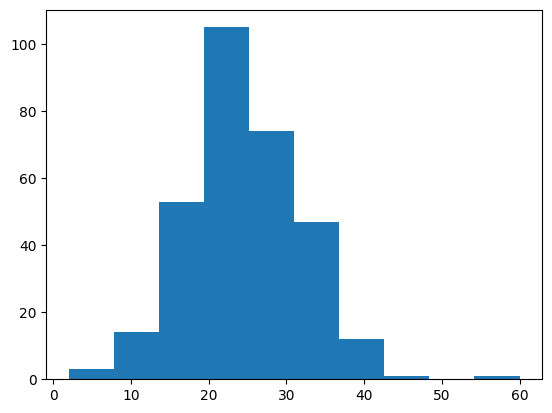

In [5]:
plt.hist(len1)

In [6]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

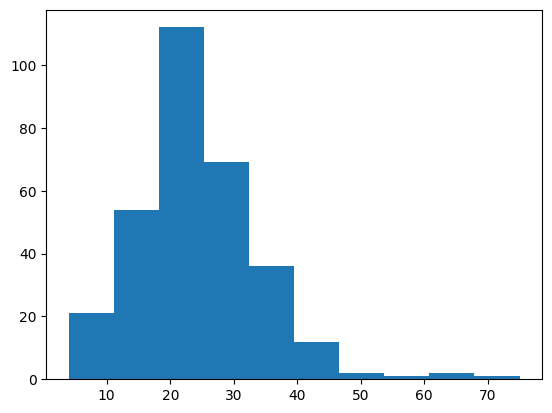

In [7]:
plt.hist(len2)

In [8]:
max(len2)

75

<AxesSubplot:>

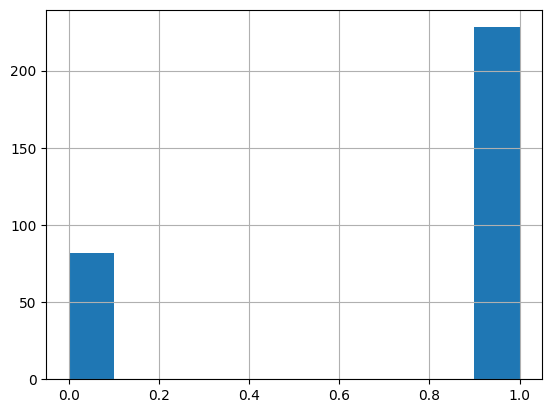

In [9]:
data["Class"].hist()

In [10]:
len(data["Paratope"].unique())

310

In [11]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [57]:
clip_norm = 1

# model name
# model_name = "demo"
# model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
# model_name = "PESI"

use_fine_tune = True
# use_fine_tune = False

# fix_FE = True
fix_FE = False

if use_fine_tune==True:
    model_name += "_ft"

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

# model_list = [
#     "InteractCoattnTransformer", 
#     "SetTransformer", 
#     "SetCoAttnTransformer", 
#     "SetModel", 
#     "SetCoAttnModel"
# ]

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="train")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 1e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=32, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
#         for name, param in model.co_attn_set.named_parameters():
#             param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            param_l2_loss = 0
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    param_l2_loss += torch.norm(param, p=2)
            param_l2_loss = l2_coef * param_l2_loss
            loss += param_l2_loss

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

fold 0 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0196 
 Val Loss	0.6272 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.67it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0117 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0108 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.33it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0039 
 Val Loss	0.6471 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9981 
 Val Loss	0.6534 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9985 
 Val Loss	0.6787 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9930 
 Val Loss	0.6834 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.58it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9855 
 Val Loss	0.7018 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.07it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9785 
 Val Loss	0.7509 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9721 
 Val Loss	0.7612 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9693 
 Val Loss	0.8453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9690 
 Val Loss	0.8870 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.66it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9627 
 Val Loss	0.9182 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9583 
 Val Loss	0.9624 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9561 
 Val Loss	1.0265 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.43it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9573 
 Val Loss	1.0392 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9543 
 Val Loss	1.0797 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.68it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9527 
 Val Loss	1.1152 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9502 
 Val Loss	1.1490 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9503 
 Val Loss	1.1451 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9487 
 Val Loss	1.3275 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4548 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.53it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9476 
 Val Loss	1.3659 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9452 
 Val Loss	1.3473 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4048 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9433 
 Val Loss	1.4761 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9432 
 Val Loss	1.4753 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9419 
 Val Loss	1.4596 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.46it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9404 
 Val Loss	1.4895 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9386 
 Val Loss	1.5037 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9354 
 Val Loss	1.4934 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5190 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.67it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9562 
 Val Loss	1.5838 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5119 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.07it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9576 
 Val Loss	1.5870 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.32it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9679 
 Val Loss	1.5740 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6429 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9676 
 Val Loss	1.5559 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.89it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9635 
 Val Loss	1.5590 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6286 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.26it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9705 
 Val Loss	1.7521 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5762 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.24it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9875 
 Val Loss	1.7482 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5619 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.09it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9838 
 Val Loss	1.7553 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6024 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9813 
 Val Loss	1.7504 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.22it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9775 
 Val Loss	1.7479 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9738 
 Val Loss	1.7386 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4571 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9700 
 Val Loss	1.7400 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5143 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.07it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9657 
 Val Loss	1.7320 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.38it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9621 
 Val Loss	1.7351 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4952 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.60it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9577 
 Val Loss	1.8730 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4571 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9534 
 Val Loss	2.0140 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5190 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.96it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9505 
 Val Loss	2.0746 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5071 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9482 
 Val Loss	2.2118 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4929 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9449 
 Val Loss	2.2755 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5405 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.31it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9505 
 Val Loss	2.3422 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5119 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.62it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9457 
 Val Loss	2.4056 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5595 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.69it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9417 
 Val Loss	2.4590 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9376 
 Val Loss	2.5710 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4857 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9337 
 Val Loss	2.6828 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4667 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9296 
 Val Loss	2.8458 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5119 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9260 
 Val Loss	2.9498 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5143 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9309 
 Val Loss	3.0991 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5571 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9283 
 Val Loss	3.2454 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5548 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.39it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9248 
 Val Loss	3.3900 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5095 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9224 
 Val Loss	3.4810 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4952 
 Val GMean	0.4140 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.9196 
 Val Loss	3.6759 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4810 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.9160 
 Val Loss	3.8616 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4476 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.9137 
 Val Loss	3.9403 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4929 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.43it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.9112 
 Val Loss	4.0193 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5571 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.9101 
 Val Loss	4.1111 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4571 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.9130 
 Val Loss	4.1808 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5857 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.9100 
 Val Loss	4.2413 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5143 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.9083 
 Val Loss	4.3090 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.9057 
 Val Loss	4.4165 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5143 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.39it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.9035 
 Val Loss	4.4869 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4714 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.9003 
 Val Loss	4.5579 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4381 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8991 
 Val Loss	4.6776 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4548 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.28it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8967 
 Val Loss	4.7470 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4833 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.12it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8940 
 Val Loss	4.9009 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4238 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8928 
 Val Loss	5.0564 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4810 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8915 
 Val Loss	5.2098 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4810 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8894 
 Val Loss	5.3426 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5190 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.09it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8878 
 Val Loss	5.4350 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5071 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8863 
 Val Loss	5.5290 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4786 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8835 
 Val Loss	5.6572 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4762 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8814 
 Val Loss	5.7539 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4571 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8795 
 Val Loss	5.8767 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4381 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8773 
 Val Loss	6.0016 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8752 
 Val Loss	6.1542 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4310 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8729 
 Val Loss	6.2686 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4762 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8707 
 Val Loss	6.3791 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4619 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8684 
 Val Loss	6.5021 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4095 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8692 
 Val Loss	6.6215 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4095 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8666 
 Val Loss	6.7645 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4024 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8642 
 Val Loss	6.8971 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3667 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8641 
 Val Loss	6.9588 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4405 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8616 
 Val Loss	7.0202 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4571 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8592 
 Val Loss	7.1114 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3238 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8601 
 Val Loss	7.2054 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4381 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8579 
 Val Loss	7.3235 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.51it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8562 
 Val Loss	7.4078 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5095 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8539 
 Val Loss	7.5222 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4571 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8521 
 Val Loss	7.6346 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3833 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8501 
 Val Loss	7.7466 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4024 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8487 
 Val Loss	7.8581 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4119 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.26it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8469 
 Val Loss	8.0042 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4429 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8452 
 Val Loss	8.1168 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3738 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8470 
 Val Loss	8.2461 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4476 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8450 
 Val Loss	8.3811 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8453 
 Val Loss	8.4829 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4595 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8431 
 Val Loss	8.5878 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4381 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8413 
 Val Loss	8.7149 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8406 
 Val Loss	8.8080 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4238 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.80it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8402 
 Val Loss	8.9614 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4714 
 Val GMean	0.0000 
 Val MCC	-0.1812


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8383 
 Val Loss	9.1027 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4095 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.06it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8363 
 Val Loss	9.2348 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4429 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8341 
 Val Loss	9.3811 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4238 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8329 
 Val Loss	9.5031 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8315 
 Val Loss	9.6146 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8334 
 Val Loss	9.7513 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3690 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8319 
 Val Loss	9.8728 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3952 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8307 
 Val Loss	9.9416 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4810 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8313 
 Val Loss	9.9877 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5429 
 Val GMean	0.4781 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8305 
 Val Loss	10.0812 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4381 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.96it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8294 
 Val Loss	10.1675 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4381 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8278 
 Val Loss	10.2270 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.17it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8289 
 Val Loss	10.3310 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4571 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.14it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8279 
 Val Loss	10.3986 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4429 
 Val GMean	0.0000 
 Val MCC	-0.3026


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.24it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8271 
 Val Loss	10.4712 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	-0.3026


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8252 
 Val Loss	10.5843 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8235 
 Val Loss	10.6845 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	-0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.39it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8224 
 Val Loss	10.8148 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4786 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8204 
 Val Loss	10.9547 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3738 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8186 
 Val Loss	11.0459 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3548 
 Val GMean	0.0000 
 Val MCC	-0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8188 
 Val Loss	11.1414 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4381 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8196 
 Val Loss	11.2399 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.40it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8180 
 Val Loss	11.3241 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4238 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8170 
 Val Loss	11.4052 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8155 
 Val Loss	11.4824 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4286 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8141 
 Val Loss	11.5805 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8124 
 Val Loss	11.6325 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.28it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8108 
 Val Loss	11.6905 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	-0.4070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.35it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8094 
 Val Loss	11.7929 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.70it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8086 
 Val Loss	11.9028 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4119 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8071 
 Val Loss	11.9831 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	-0.3026


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8052 
 Val Loss	12.0971 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4310 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8036 
 Val Loss	12.1955 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3619 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.8023 
 Val Loss	12.2845 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4476 
 Val GMean	0.0000 
 Val MCC	-0.2656


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.36it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.8007 
 Val Loss	12.3522 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4238 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.8039 
 Val Loss	12.4294 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	-0.2259


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.8041 
 Val Loss	12.5031 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4190 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.8024 
 Val Loss	12.5717 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4571 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.69it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.8007 
 Val Loss	12.6298 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4238 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7991 
 Val Loss	12.6884 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4071 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7979 
 Val Loss	12.7878 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3762 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.07it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7966 
 Val Loss	12.9268 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3714 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.06it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7953 
 Val Loss	13.0610 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3190 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7933 
 Val Loss	13.1657 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4262 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7921 
 Val Loss	13.2738 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4048 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.16it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7979 
 Val Loss	13.3955 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3762 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.88it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7966 
 Val Loss	13.4767 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4429 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7955 
 Val Loss	13.5633 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4381 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.29it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7935 
 Val Loss	13.6544 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3452 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.07it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7983 
 Val Loss	13.7736 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4429 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8169 
 Val Loss	13.8431 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5286 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.8158 
 Val Loss	13.9429 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3476 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.8143 
 Val Loss	14.0667 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.42it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.8126 
 Val Loss	14.1552 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4095 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8130 
 Val Loss	14.2736 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3738 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8134 
 Val Loss	14.4008 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3476 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8123 
 Val Loss	14.5143 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3786 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8106 
 Val Loss	14.6093 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3762 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8091 
 Val Loss	14.7146 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4238 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.30it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8070 
 Val Loss	14.8275 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4048 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8056 
 Val Loss	14.9399 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3762 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8059 
 Val Loss	15.0088 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8044 
 Val Loss	15.0770 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4095 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8024 
 Val Loss	15.1668 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4095 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.67it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8056 
 Val Loss	15.2919 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3095 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8037 
 Val Loss	15.3958 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3286 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8019 
 Val Loss	15.4856 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8030 
 Val Loss	15.5359 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4167 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8012 
 Val Loss	15.6308 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3810 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8001 
 Val Loss	15.7326 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3571 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7982 
 Val Loss	15.8444 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.2881 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7966 
 Val Loss	15.9425 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3762 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.56it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7978 
 Val Loss	16.0571 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3095 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.77it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7961 
 Val Loss	16.1446 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3405 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7946 
 Val Loss	16.2448 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3762 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.14it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7930 
 Val Loss	16.3458 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3381 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7915 
 Val Loss	16.4526 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3738 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7921 
 Val Loss	16.5460 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3762 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.14it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7916 
 Val Loss	16.6462 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3548 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7908 
 Val Loss	16.7144 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4190 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7972 
 Val Loss	16.7932 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4095 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7968 
 Val Loss	16.8558 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4500 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7951 
 Val Loss	16.9101 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4262 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.61it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7938 
 Val Loss	16.9797 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4548 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7925 
 Val Loss	17.0751 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3976 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7908 
 Val Loss	17.1703 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3762 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7894 
 Val Loss	17.2538 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3333 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7878 
 Val Loss	17.3200 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3905 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7909 
 Val Loss	17.4030 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4405 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7913 
 Val Loss	17.4754 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4548 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7917 
 Val Loss	17.5567 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4119 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7904 
 Val Loss	17.6477 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3738 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7905 
 Val Loss	17.7472 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3476 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.02it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7915 
 Val Loss	17.8493 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3571 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7904 
 Val Loss	17.9418 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3810 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.21it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7895 
 Val Loss	18.0303 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4190 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.06it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7900 
 Val Loss	18.1186 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.35it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7882 
 Val Loss	18.1887 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4048 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7882 
 Val Loss	18.2659 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7867 
 Val Loss	18.3442 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7867 
 Val Loss	18.4436 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7852 
 Val Loss	18.5633 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3690 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7853 
 Val Loss	18.6837 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3690 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7838 
 Val Loss	18.7902 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3810 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.37it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7848 
 Val Loss	18.8678 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3619 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7842 
 Val Loss	18.9522 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4024 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7828 
 Val Loss	19.0306 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3690 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7813 
 Val Loss	19.0968 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3381 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7803 
 Val Loss	19.1499 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3952 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7805 
 Val Loss	19.1901 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4119 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7788 
 Val Loss	19.2672 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3976 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7776 
 Val Loss	19.3623 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7761 
 Val Loss	19.4415 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3976 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7750 
 Val Loss	19.5341 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3738 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7811 
 Val Loss	19.6273 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3714 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7830 
 Val Loss	19.7212 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3500 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.26it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7861 
 Val Loss	19.7639 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4619 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7878 
 Val Loss	19.8297 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4095 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7887 
 Val Loss	19.8877 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3643 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7894 
 Val Loss	19.9868 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3286 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7931 
 Val Loss	20.0427 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4048 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.28it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7918 
 Val Loss	20.1241 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3286 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7919 
 Val Loss	20.1914 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3738 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7905 
 Val Loss	20.2592 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4024 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7892 
 Val Loss	20.3173 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3929 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7881 
 Val Loss	20.3882 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.2881 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7893 
 Val Loss	20.4508 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.65it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7897 
 Val Loss	20.5281 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3310 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7886 
 Val Loss	20.5915 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3310 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7871 
 Val Loss	20.6625 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3738 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.37it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7882 
 Val Loss	20.7154 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4048 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7891 
 Val Loss	20.7681 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4310 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.44it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7882 
 Val Loss	20.8392 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3738 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7879 
 Val Loss	20.9143 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3500 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7897 
 Val Loss	20.9917 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3286 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7887 
 Val Loss	21.0669 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3333 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7878 
 Val Loss	21.1077 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4405 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7905 
 Val Loss	21.1174 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5405 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7940 
 Val Loss	21.1462 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4286 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7945 
 Val Loss	21.1668 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4310 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7946 
 Val Loss	21.2033 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4690 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7955 
 Val Loss	21.2500 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4405 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7992 
 Val Loss	21.2996 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3548 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7989 
 Val Loss	21.3279 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3619 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7980 
 Val Loss	21.3601 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4167 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7969 
 Val Loss	21.3993 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3595 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.52it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7970 
 Val Loss	21.4356 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4548 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7956 
 Val Loss	21.4768 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3929 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7966 
 Val Loss	21.5152 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4595 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.8007 
 Val Loss	21.5488 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4667 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.8015 
 Val Loss	21.5860 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4548 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.8008 
 Val Loss	21.6243 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4000 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7997 
 Val Loss	21.6674 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4238 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.8001 
 Val Loss	21.7040 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3690 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.8018 
 Val Loss	21.7414 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3929 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.8006 
 Val Loss	21.7733 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4595 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7992 
 Val Loss	21.8050 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4357 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.48it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7979 
 Val Loss	21.8596 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4500 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7977 
 Val Loss	21.9029 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4357 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.51it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7974 
 Val Loss	21.9345 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3929 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.20it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7967 
 Val Loss	21.9812 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4286 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7991 
 Val Loss	22.0232 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4095 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.8037 
 Val Loss	22.0406 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.45it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.8053 
 Val Loss	22.0711 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4452 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.8050 
 Val Loss	22.0863 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5071 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.87it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.8089 
 Val Loss	22.1255 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4167 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.8121 
 Val Loss	22.1579 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4238 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.8121 
 Val Loss	22.1998 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4143 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.13it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.8126 
 Val Loss	22.2204 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.8158 
 Val Loss	22.2212 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5167 
 Val GMean	0.4309 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.8187 
 Val Loss	22.2402 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5333 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.51it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.8174 
 Val Loss	22.2957 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4310 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.96it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.8164 
 Val Loss	22.3240 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5119 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.8163 
 Val Loss	22.3688 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4690 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.8153 
 Val Loss	22.4145 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4286 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.12it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.8156 
 Val Loss	22.4603 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4524 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.8168 
 Val Loss	22.4884 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4929 
 Val GMean	0.4140 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8194 
 Val Loss	22.5046 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5071 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8200 
 Val Loss	22.5382 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4214 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8245 
 Val Loss	22.5781 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4548 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8235 
 Val Loss	22.6153 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4524 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8242 
 Val Loss	22.6653 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4262 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8298 
 Val Loss	22.6997 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4714 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8300 
 Val Loss	22.7326 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4310 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8293 
 Val Loss	22.7706 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4048 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8282 
 Val Loss	22.8088 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4048 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8303 
 Val Loss	22.8474 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3857 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8294 
 Val Loss	22.8927 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8293 
 Val Loss	22.9261 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4310 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.8315 
 Val Loss	22.9611 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3952 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.8336 
 Val Loss	22.9905 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4071 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.8335 
 Val Loss	23.0207 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4071 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.8324 
 Val Loss	23.0519 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4310 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.46it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.8308 
 Val Loss	23.0861 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4310 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.8293 
 Val Loss	23.1266 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4071 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.8291 
 Val Loss	23.1599 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4119 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.8289 
 Val Loss	23.1862 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4143 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.8328 
 Val Loss	23.2191 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4405 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.8321 
 Val Loss	23.2628 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4024 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.44it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8334 
 Val Loss	23.3076 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3976 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8358 
 Val Loss	23.3528 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4190 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8342 
 Val Loss	23.3916 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3952 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8327 
 Val Loss	23.4327 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3929 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.09it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8339 
 Val Loss	23.4698 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3905 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.96it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8326 
 Val Loss	23.5084 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3952 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.71it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.8340 
 Val Loss	23.5446 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4190 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8372 
 Val Loss	23.5752 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3762 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8369 
 Val Loss	23.6064 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3762 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.24it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8367 
 Val Loss	23.6384 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3762 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.66it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8363 
 Val Loss	23.6528 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4381 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.22it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8379 
 Val Loss	23.6690 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4381 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.8364 
 Val Loss	23.6834 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4571 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.75it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.8352 
 Val Loss	23.6878 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4929 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.8350 
 Val Loss	23.7029 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4786 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.8337 
 Val Loss	23.7410 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4048 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.8344 
 Val Loss	23.7781 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4000 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.8342 
 Val Loss	23.7954 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4548 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.8327 
 Val Loss	23.8167 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4738 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.8313 
 Val Loss	23.8325 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5262 
 Val GMean	0.5345 
 Val MCC	0.1143


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.08it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.8315 
 Val Loss	23.8606 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5143 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.8337 
 Val Loss	23.8772 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5571 
 Val GMean	0.4781 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.8366 
 Val Loss	23.8904 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5452 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.45it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.8377 
 Val Loss	23.9009 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5214 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.07it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.8386 
 Val Loss	23.9315 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4286 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.8397 
 Val Loss	23.9684 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4286 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.8410 
 Val Loss	23.9959 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.8462 
 Val Loss	24.0281 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.8533 
 Val Loss	24.0641 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4286 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.8529 
 Val Loss	24.1002 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4429 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.8519 
 Val Loss	24.1409 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4190 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.36it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.8506 
 Val Loss	24.1802 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3976 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.8550 
 Val Loss	24.2191 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3738 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.8559 
 Val Loss	24.2518 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3762 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.8570 
 Val Loss	24.2885 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3952 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.60it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.8558 
 Val Loss	24.3174 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4190 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.8542 
 Val Loss	24.3531 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3952 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.16it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.8571 
 Val Loss	24.3827 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4429 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.8789 
 Val Loss	24.4159 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4000 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.14it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.8850 
 Val Loss	24.4473 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3810 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.49it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.8864 
 Val Loss	24.4723 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4190 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.8849 
 Val Loss	24.4958 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4667 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.42it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.8845 
 Val Loss	24.5232 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3810 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.8849 
 Val Loss	24.5396 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4905 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.8859 
 Val Loss	24.5705 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4262 
 Val GMean	0.3519 
 Val MCC	-0.1810


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.43it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.8879 
 Val Loss	24.5854 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4929 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.45it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.8873 
 Val Loss	24.6075 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5024 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.8869 
 Val Loss	24.6318 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4524 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.8866 
 Val Loss	24.6543 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4595 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.38it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.8871 
 Val Loss	24.6600 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5286 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.8875 
 Val Loss	24.6673 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5167 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.8879 
 Val Loss	24.6956 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4190 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.8885 
 Val Loss	24.7121 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5024 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.8912 
 Val Loss	24.7277 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4738 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.8911 
 Val Loss	24.7516 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4405 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.43it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.8906 
 Val Loss	24.7725 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4619 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.16it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.8931 
 Val Loss	24.7947 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4190 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.8918 
 Val Loss	24.8114 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4310 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.8933 
 Val Loss	24.8263 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4595 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.8966 
 Val Loss	24.8612 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4167 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.9019 
 Val Loss	24.8877 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5167 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.9059 
 Val Loss	24.9090 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4881 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.9090 
 Val Loss	24.9305 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4619 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.9126 
 Val Loss	24.9530 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4619 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.9125 
 Val Loss	24.9628 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4810 
 Val GMean	0.4309 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.9140 
 Val Loss	24.9834 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4548 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.9125 
 Val Loss	25.0089 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4500 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.9111 
 Val Loss	25.0250 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4500 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.9122 
 Val Loss	25.0699 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.9132 
 Val Loss	25.0919 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4833 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.9166 
 Val Loss	25.1037 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4976 
 Val GMean	0.4254 
 Val MCC	0.1461


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.9180 
 Val Loss	25.1228 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5095 
 Val GMean	0.4140 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.9177 
 Val Loss	25.1456 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4190 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.9191 
 Val Loss	25.1583 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4595 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.9203 
 Val Loss	25.1693 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4643 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.86it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.9210 
 Val Loss	25.2056 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3524 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.9200 
 Val Loss	25.2303 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4286 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.9207 
 Val Loss	25.2364 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4786 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.9195 
 Val Loss	25.2467 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4476 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.9191 
 Val Loss	25.2544 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4905 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.02it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.9222 
 Val Loss	25.2670 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4357 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.17it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.9225 
 Val Loss	25.2697 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5286 
 Val GMean	0.4781 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.9247 
 Val Loss	25.2876 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4167 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.9268 
 Val Loss	25.2993 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4214 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.9255 
 Val Loss	25.3207 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3762 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.9303 
 Val Loss	25.3328 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4071 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.9353 
 Val Loss	25.3458 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4548 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.32it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.9446 
 Val Loss	25.3632 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4357 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.9463 
 Val Loss	25.3936 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3833 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.9478 
 Val Loss	25.4213 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3643 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.9482 
 Val Loss	25.4415 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4405 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.9499 
 Val Loss	25.4643 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4024 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.9537 
 Val Loss	25.4786 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3929 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.38it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.9558 
 Val Loss	25.4973 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3929 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.28it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.9606 
 Val Loss	25.5352 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3524 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.9653 
 Val Loss	25.5611 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3810 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.27it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.9655 
 Val Loss	25.5734 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4548 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.9659 
 Val Loss	25.5916 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4619 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.9669 
 Val Loss	25.6064 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4119 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.9671 
 Val Loss	25.6101 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4714 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.39it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.9691 
 Val Loss	25.6092 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4786 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.9705 
 Val Loss	25.6145 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5214 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.26it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.9717 
 Val Loss	25.6281 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4476 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.47it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.9732 
 Val Loss	25.6342 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5238 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.9739 
 Val Loss	25.6388 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5429 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.9750 
 Val Loss	25.6430 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4810 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.35it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.9754 
 Val Loss	25.6398 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5548 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.9773 
 Val Loss	25.6471 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5000 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.9784 
 Val Loss	25.6493 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4548 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.9786 
 Val Loss	25.6593 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4738 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.9790 
 Val Loss	25.6575 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5667 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.9808 
 Val Loss	25.6564 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5381 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.9809 
 Val Loss	25.6552 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5524 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.9815 
 Val Loss	25.6568 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5667 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.9826 
 Val Loss	25.6579 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5524 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.9839 
 Val Loss	25.6672 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4905 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.9848 
 Val Loss	25.6638 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5524 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.9857 
 Val Loss	25.6661 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5429 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.9890 
 Val Loss	25.6725 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4929 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.9899 
 Val Loss	25.6863 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4881 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.9908 
 Val Loss	25.7062 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4810 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.9925 
 Val Loss	25.7269 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4905 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.9933 
 Val Loss	25.7469 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5071 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.9960 
 Val Loss	25.7652 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5071 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.0029 
 Val Loss	25.7916 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4262 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.0056 
 Val Loss	25.8078 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5024 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.0092 
 Val Loss	25.8093 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5571 
 Val GMean	0.4024 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.0162 
 Val Loss	25.8133 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5571 
 Val GMean	0.4629 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.0193 
 Val Loss	25.8323 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4619 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.0200 
 Val Loss	25.8437 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3786 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.0205 
 Val Loss	25.8516 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4429 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.13it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.0239 
 Val Loss	25.8603 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4000 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.0337 
 Val Loss	25.8693 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4214 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.05it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.0355 
 Val Loss	25.8841 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4000 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.0355 
 Val Loss	25.8993 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3786 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.0395 
 Val Loss	25.9205 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3976 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.0398 
 Val Loss	25.9417 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3976 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.0436 
 Val Loss	25.9594 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3952 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.0459 
 Val Loss	25.9817 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4048 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.18it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.0477 
 Val Loss	25.9922 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4333 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.0494 
 Val Loss	26.0005 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5095 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.0494 
 Val Loss	26.0163 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4119 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.0503 
 Val Loss	26.0281 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4452 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.0504 
 Val Loss	26.0431 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4548 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.42it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.0522 
 Val Loss	26.0661 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3738 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.51it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.0525 
 Val Loss	26.0924 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3524 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.0516 
 Val Loss	26.1215 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3405 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.0594 
 Val Loss	26.1418 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4048 
 Val GMean	0.2488 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.0600 
 Val Loss	26.1680 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4167 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.24it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.0674 
 Val Loss	26.1923 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4167 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.38it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.0727 
 Val Loss	26.2027 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.4405 
 Val GMean	0.3381 
 Val MCC	-0.2233


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.0732 
 Val Loss	26.2310 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4024 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.0738 
 Val Loss	26.2678 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3500 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.47it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.0776 
 Val Loss	26.3050 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3500 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.0774 
 Val Loss	26.3383 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3810 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.0766 
 Val Loss	26.3693 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.92it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.0750 
 Val Loss	26.3997 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3857 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.0736 
 Val Loss	26.4225 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3905 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.73it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.0730 
 Val Loss	26.4489 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3857 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.0721 
 Val Loss	26.4830 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3500 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.0715 
 Val Loss	26.5090 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3762 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.0699 
 Val Loss	26.5393 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3714 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.0703 
 Val Loss	26.5722 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3690 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.43it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.0749 
 Val Loss	26.6051 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3476 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.0765 
 Val Loss	26.6324 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4476 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.0773 
 Val Loss	26.6716 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3667 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.37it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.0786 
 Val Loss	26.7041 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3476 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.92it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.0796 
 Val Loss	26.7249 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4190 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.22it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.0800 
 Val Loss	26.7574 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3476 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.0810 
 Val Loss	26.7854 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3500 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.0825 
 Val Loss	26.8021 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4452 
 Val GMean	0.4472 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.0842 
 Val Loss	26.8269 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3524 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.0849 
 Val Loss	26.8477 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3786 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.0837 
 Val Loss	26.8678 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4024 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.10it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.0834 
 Val Loss	26.9058 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3667 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.0846 
 Val Loss	26.9383 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3476 
 Val GMean	0.2582 
 Val MCC	-0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.0838 
 Val Loss	26.9745 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3476 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.0830 
 Val Loss	27.0032 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3524 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.0815 
 Val Loss	27.0288 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3976 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.0817 
 Val Loss	27.0630 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3738 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.0812 
 Val Loss	27.0936 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3714 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.0805 
 Val Loss	27.1093 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4167 
 Val GMean	0.2673 
 Val MCC	-0.2076


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.0798 
 Val Loss	27.1176 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4786 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.0797 
 Val Loss	27.1362 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4143 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.37it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.0782 
 Val Loss	27.1580 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4048 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.93it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.0767 
 Val Loss	27.1695 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4929 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.0781 
 Val Loss	27.1931 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4595 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.17it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.0780 
 Val Loss	27.2167 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4929 
 Val GMean	0.3780 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.32it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.0786 
 Val Loss	27.2395 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4690 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.0772 
 Val Loss	27.2507 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5619 
 Val GMean	0.3651 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.0772 
 Val Loss	27.2630 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5286 
 Val GMean	0.3904 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.0781 
 Val Loss	27.2676 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4810 
 Val GMean	0.4140 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.0804 
 Val Loss	27.2717 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4786 
 Val GMean	0.4254 
 Val MCC	0.1461
fold 1 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0309 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.9970 
 Val Loss	0.6440 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6955 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.9828 
 Val Loss	0.6324 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.9709 
 Val Loss	0.6288 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9626 
 Val Loss	0.6308 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9595 
 Val Loss	0.7589 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.80it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9570 
 Val Loss	0.8542 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6545 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9562 
 Val Loss	0.9868 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9624 
 Val Loss	1.1027 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.76it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9610 
 Val Loss	1.0811 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9554 
 Val Loss	1.0552 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.7273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9561 
 Val Loss	1.1614 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9576 
 Val Loss	1.1982 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6364 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9560 
 Val Loss	1.1684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.7182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9521 
 Val Loss	1.2036 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9513 
 Val Loss	1.2479 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9497 
 Val Loss	1.2617 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.25it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9458 
 Val Loss	1.2749 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9429 
 Val Loss	1.3103 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.13it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9401 
 Val Loss	1.3241 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9397 
 Val Loss	1.3680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9420 
 Val Loss	1.3969 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6591 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9402 
 Val Loss	1.3877 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9381 
 Val Loss	1.4023 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9352 
 Val Loss	1.4101 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9347 
 Val Loss	1.4174 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6136 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9324 
 Val Loss	1.4187 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.15it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9313 
 Val Loss	1.5388 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9294 
 Val Loss	1.5339 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5955 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9294 
 Val Loss	1.6346 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9263 
 Val Loss	1.7360 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9270 
 Val Loss	1.9335 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9267 
 Val Loss	2.1196 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6591 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9262 
 Val Loss	2.2108 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6568 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.86it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9248 
 Val Loss	2.2895 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6682 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9246 
 Val Loss	2.5270 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6432 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9240 
 Val Loss	2.6681 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9218 
 Val Loss	2.7267 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9215 
 Val Loss	2.8611 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5682 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.43it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9202 
 Val Loss	2.9882 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6545 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9178 
 Val Loss	3.0360 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6932 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9150 
 Val Loss	3.2254 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6114 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9137 
 Val Loss	3.2700 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6432 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9114 
 Val Loss	3.5202 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6045 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.10it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9119 
 Val Loss	3.6821 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6273 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9106 
 Val Loss	3.8322 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6136 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.26it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9167 
 Val Loss	3.9753 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9143 
 Val Loss	4.1120 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6409 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9134 
 Val Loss	4.2523 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6545 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9133 
 Val Loss	4.4587 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6500 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.63it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9106 
 Val Loss	4.5839 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6773 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9076 
 Val Loss	4.7613 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6273 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9121 
 Val Loss	4.9910 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6341 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.37it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9094 
 Val Loss	5.0971 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6841 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9068 
 Val Loss	5.2510 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6273 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9048 
 Val Loss	5.3512 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6841 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9018 
 Val Loss	5.4927 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.8995 
 Val Loss	5.6297 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6364 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.8974 
 Val Loss	5.7258 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6182 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.8948 
 Val Loss	5.8572 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.17it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.8926 
 Val Loss	5.9839 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5818 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.8920 
 Val Loss	6.1052 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6273 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.8902 
 Val Loss	6.2256 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6136 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.28it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.8873 
 Val Loss	6.3413 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5545 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.8883 
 Val Loss	6.4517 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8864 
 Val Loss	6.6095 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5341 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8835 
 Val Loss	6.7182 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6045 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8805 
 Val Loss	6.8207 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6045 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8816 
 Val Loss	6.9165 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5864 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8803 
 Val Loss	7.0115 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6091 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8788 
 Val Loss	7.1113 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5091 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8769 
 Val Loss	7.2530 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5636 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8749 
 Val Loss	7.3457 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5682 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8729 
 Val Loss	7.4404 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5364 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8698 
 Val Loss	7.5653 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5432 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8668 
 Val Loss	7.7666 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4795 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8712 
 Val Loss	7.9669 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5295 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8694 
 Val Loss	8.0886 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5682 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8693 
 Val Loss	8.2443 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5636 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8658 
 Val Loss	8.3526 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5682 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8651 
 Val Loss	8.4599 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5636 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8627 
 Val Loss	8.5259 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8601 
 Val Loss	8.6622 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5318 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8621 
 Val Loss	8.7617 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5682 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8599 
 Val Loss	8.9649 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8626 
 Val Loss	9.0943 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8599 
 Val Loss	9.2216 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5545 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.69it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8578 
 Val Loss	9.4136 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.38it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8551 
 Val Loss	9.5777 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5341 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8531 
 Val Loss	9.7297 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5068 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8532 
 Val Loss	9.9451 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4955 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8513 
 Val Loss	10.1254 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8495 
 Val Loss	10.2712 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8465 
 Val Loss	10.4115 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5523 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8448 
 Val Loss	10.5147 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6091 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8422 
 Val Loss	10.6476 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8400 
 Val Loss	10.8117 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5045 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8377 
 Val Loss	11.0047 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8356 
 Val Loss	11.1615 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5091 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8331 
 Val Loss	11.3161 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8354 
 Val Loss	11.4397 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5364 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.17it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8331 
 Val Loss	11.6141 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4705 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8352 
 Val Loss	11.7841 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5250 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8346 
 Val Loss	11.9209 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5500 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8325 
 Val Loss	12.0846 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8351 
 Val Loss	12.2214 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5591 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8536 
 Val Loss	12.3549 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4864 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.17it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8517 
 Val Loss	12.4845 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5409 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8499 
 Val Loss	12.5860 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8492 
 Val Loss	12.7099 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5545 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8465 
 Val Loss	12.8315 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8458 
 Val Loss	12.9270 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5409 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8431 
 Val Loss	13.0724 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8413 
 Val Loss	13.1888 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5591 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8388 
 Val Loss	13.3322 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4705 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8359 
 Val Loss	13.4517 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8329 
 Val Loss	13.5929 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8319 
 Val Loss	13.6875 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5614 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.02it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8304 
 Val Loss	13.8173 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4886 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8287 
 Val Loss	13.9064 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5523 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8270 
 Val Loss	14.0345 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8254 
 Val Loss	14.1369 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5364 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8299 
 Val Loss	14.2367 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4909 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8285 
 Val Loss	14.3583 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4750 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.91it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8264 
 Val Loss	14.4571 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8241 
 Val Loss	14.5346 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5318 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8217 
 Val Loss	14.6576 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5364 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8428 
 Val Loss	14.7590 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.39it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8404 
 Val Loss	14.8757 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4659 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8450 
 Val Loss	14.9675 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5136 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8444 
 Val Loss	15.0573 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8419 
 Val Loss	15.1459 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8394 
 Val Loss	15.2529 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8369 
 Val Loss	15.3565 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4841 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8359 
 Val Loss	15.4686 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4591 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8330 
 Val Loss	15.5717 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4909 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8330 
 Val Loss	15.6752 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4295 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8312 
 Val Loss	15.7799 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5159 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8287 
 Val Loss	15.8765 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8259 
 Val Loss	15.9599 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4818 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8265 
 Val Loss	16.0624 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.8244 
 Val Loss	16.1208 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5114 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.8352 
 Val Loss	16.2117 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5091 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.8326 
 Val Loss	16.2891 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4409 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.8310 
 Val Loss	16.3857 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4545 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.8412 
 Val Loss	16.4753 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5045 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.80it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.8388 
 Val Loss	16.5609 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5091 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.8374 
 Val Loss	16.6452 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5295 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.8349 
 Val Loss	16.7301 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5045 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.8333 
 Val Loss	16.8266 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.8337 
 Val Loss	16.9161 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.8366 
 Val Loss	16.9972 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5045 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8371 
 Val Loss	17.0760 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5295 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.8387 
 Val Loss	17.1570 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4250 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.8573 
 Val Loss	17.2545 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4773 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.8798 
 Val Loss	17.3507 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4773 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.8866 
 Val Loss	17.4250 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4818 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.8874 
 Val Loss	17.5006 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5250 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8925 
 Val Loss	17.5934 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.8900 
 Val Loss	17.6699 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.8889 
 Val Loss	17.7343 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5091 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.8888 
 Val Loss	17.8065 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5659 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.05it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8889 
 Val Loss	17.8771 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8865 
 Val Loss	17.9453 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4886 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8891 
 Val Loss	18.0125 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8911 
 Val Loss	18.0798 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5705 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8892 
 Val Loss	18.1474 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5205 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8892 
 Val Loss	18.2143 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.60it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8866 
 Val Loss	18.2654 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5136 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8866 
 Val Loss	18.3333 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4545 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8839 
 Val Loss	18.4011 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8828 
 Val Loss	18.4659 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8807 
 Val Loss	18.5298 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4955 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8790 
 Val Loss	18.5931 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5159 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8765 
 Val Loss	18.6566 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.80it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8802 
 Val Loss	18.7185 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4659 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8823 
 Val Loss	18.8127 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8829 
 Val Loss	18.8742 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4841 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.8834 
 Val Loss	18.9321 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4795 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.8845 
 Val Loss	18.9894 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5295 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.8903 
 Val Loss	19.0467 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4955 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.8969 
 Val Loss	19.1016 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4886 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.04it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8970 
 Val Loss	19.1568 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4273 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.8952 
 Val Loss	19.2103 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.8931 
 Val Loss	19.2660 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.9009 
 Val Loss	19.3547 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.9008 
 Val Loss	19.3963 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4409 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.9022 
 Val Loss	19.4295 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5227 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.9081 
 Val Loss	19.4824 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5205 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.9063 
 Val Loss	19.5345 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5159 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.9097 
 Val Loss	19.5879 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5409 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.36it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.9075 
 Val Loss	19.6289 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5136 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.9082 
 Val Loss	19.6943 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4773 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.9059 
 Val Loss	19.7301 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4818 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.9038 
 Val Loss	19.7943 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4545 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.9013 
 Val Loss	19.8456 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4795 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8993 
 Val Loss	19.8807 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4636 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8980 
 Val Loss	19.9280 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5500 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8963 
 Val Loss	19.9438 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5841 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8946 
 Val Loss	19.9917 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5409 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8944 
 Val Loss	20.0528 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4773 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8946 
 Val Loss	20.0986 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5091 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8929 
 Val Loss	20.1436 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4841 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8956 
 Val Loss	20.1886 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5045 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8953 
 Val Loss	20.2332 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5500 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8953 
 Val Loss	20.2784 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8952 
 Val Loss	20.3375 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8948 
 Val Loss	20.3949 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.03it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8927 
 Val Loss	20.4559 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4773 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8946 
 Val Loss	20.5153 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8940 
 Val Loss	20.5763 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4727 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.20it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8920 
 Val Loss	20.6354 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8917 
 Val Loss	20.6757 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5045 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.01it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8898 
 Val Loss	20.7193 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8895 
 Val Loss	20.7609 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5250 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.27it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8882 
 Val Loss	20.8009 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5409 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.01it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8912 
 Val Loss	20.8369 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8929 
 Val Loss	20.8751 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5705 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.29it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8975 
 Val Loss	20.9145 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5250 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.9037 
 Val Loss	20.9514 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.9015 
 Val Loss	20.9823 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8994 
 Val Loss	21.0205 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5273 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.9003 
 Val Loss	21.0453 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5682 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8981 
 Val Loss	21.0959 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8982 
 Val Loss	21.1538 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8973 
 Val Loss	21.1999 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5159 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.9038 
 Val Loss	21.2399 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5364 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.9061 
 Val Loss	21.2894 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4659 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.9060 
 Val Loss	21.3242 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.9070 
 Val Loss	21.3583 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5705 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.11it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.9105 
 Val Loss	21.3658 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6250 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.27it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.9132 
 Val Loss	21.3997 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.9132 
 Val Loss	21.4210 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6136 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.32it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.9125 
 Val Loss	21.4540 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5500 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.9122 
 Val Loss	21.4791 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5318 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.95it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.9101 
 Val Loss	21.5016 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5591 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.09it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.9078 
 Val Loss	21.5425 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.92it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.9061 
 Val Loss	21.5859 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4705 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.26it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.9041 
 Val Loss	21.6245 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.9054 
 Val Loss	21.6570 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.9047 
 Val Loss	21.6923 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.77it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.9026 
 Val Loss	21.7235 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5295 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.9015 
 Val Loss	21.7555 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5705 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.9009 
 Val Loss	21.7876 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5659 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.9017 
 Val Loss	21.8221 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4659 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8997 
 Val Loss	21.8646 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4909 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.8975 
 Val Loss	21.9077 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.9024 
 Val Loss	21.9380 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5909 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.9034 
 Val Loss	21.9942 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.9147 
 Val Loss	22.0481 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.9188 
 Val Loss	22.1100 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.9235 
 Val Loss	22.1400 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.51it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.9246 
 Val Loss	22.1794 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4909 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.9256 
 Val Loss	22.2194 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.06it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.9274 
 Val Loss	22.2287 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5159 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.9258 
 Val Loss	22.2601 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.9238 
 Val Loss	22.3088 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.81it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.9281 
 Val Loss	22.3598 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.45it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.9347 
 Val Loss	22.4105 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5205 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.9338 
 Val Loss	22.4799 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3750 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.9332 
 Val Loss	22.5366 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.9344 
 Val Loss	22.5683 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.9341 
 Val Loss	22.6090 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.9339 
 Val Loss	22.6549 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.9367 
 Val Loss	22.6911 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.69it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.9398 
 Val Loss	22.7355 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.12it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.9389 
 Val Loss	22.7763 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.9367 
 Val Loss	22.8189 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.9374 
 Val Loss	22.8660 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.9388 
 Val Loss	22.9065 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.41it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.9405 
 Val Loss	22.9435 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.19it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.9385 
 Val Loss	22.9784 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.9400 
 Val Loss	23.0138 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.9406 
 Val Loss	23.0615 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.9454 
 Val Loss	23.1082 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.07it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.9435 
 Val Loss	23.1659 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4250 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.9495 
 Val Loss	23.2022 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.9513 
 Val Loss	23.2348 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.47it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.9511 
 Val Loss	23.2672 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.32it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.9542 
 Val Loss	23.2993 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.9559 
 Val Loss	23.3318 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.9607 
 Val Loss	23.3635 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.05it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.9638 
 Val Loss	23.3949 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.9678 
 Val Loss	23.4270 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.9770 
 Val Loss	23.4579 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.9835 
 Val Loss	23.4968 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.9846 
 Val Loss	23.5273 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.9899 
 Val Loss	23.5576 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.17it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.9903 
 Val Loss	23.5877 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.9891 
 Val Loss	23.6177 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.94it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.9918 
 Val Loss	23.6498 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.9935 
 Val Loss	23.6829 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.9932 
 Val Loss	23.7122 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.9963 
 Val Loss	23.7522 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.9960 
 Val Loss	23.7848 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.9999 
 Val Loss	23.8279 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	1.0000 
 Val Loss	23.8592 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.9992 
 Val Loss	23.8872 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5659 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.9972 
 Val Loss	23.9152 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.17it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.9969 
 Val Loss	23.9464 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.9975 
 Val Loss	23.9795 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.02it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.9957 
 Val Loss	24.0144 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.9961 
 Val Loss	24.0260 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5818 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.9953 
 Val Loss	24.0644 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.9944 
 Val Loss	24.0913 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.44it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.9923 
 Val Loss	24.1180 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.17it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.9926 
 Val Loss	24.1452 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4773 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.14it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.9940 
 Val Loss	24.1717 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.9953 
 Val Loss	24.1980 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.9944 
 Val Loss	24.2240 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.9939 
 Val Loss	24.2498 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.9917 
 Val Loss	24.2794 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.9907 
 Val Loss	24.3131 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.96it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.9887 
 Val Loss	24.3488 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4727 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.9880 
 Val Loss	24.3747 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.9967 
 Val Loss	24.4099 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	1.0048 
 Val Loss	24.4346 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	1.0100 
 Val Loss	24.4592 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	1.0211 
 Val Loss	24.4837 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	1.0304 
 Val Loss	24.5182 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4977 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	1.0394 
 Val Loss	24.5523 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5205 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	1.0447 
 Val Loss	24.5763 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	1.0474 
 Val Loss	24.6000 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	1.0554 
 Val Loss	24.6255 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.76it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	1.0544 
 Val Loss	24.6543 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	1.0570 
 Val Loss	24.6808 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	1.0582 
 Val Loss	24.7039 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	1.0564 
 Val Loss	24.7270 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	1.0567 
 Val Loss	24.7451 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5114 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	1.0589 
 Val Loss	24.7683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	1.0631 
 Val Loss	24.7925 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.82it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	1.0611 
 Val Loss	24.8147 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5318 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	1.0601 
 Val Loss	24.8420 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	1.0581 
 Val Loss	24.8574 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	1.0570 
 Val Loss	24.8802 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	1.0584 
 Val Loss	24.9023 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	1.0587 
 Val Loss	24.9243 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	1.0579 
 Val Loss	24.9482 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	1.0557 
 Val Loss	24.9797 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	1.0536 
 Val Loss	25.0106 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	1.0527 
 Val Loss	25.0414 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	1.0523 
 Val Loss	25.0719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	1.0516 
 Val Loss	25.1023 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	1.0527 
 Val Loss	25.1325 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	1.0529 
 Val Loss	25.1350 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5955 
 Val GMean	0.5090 
 Val MCC	0.3179


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	1.0510 
 Val Loss	25.1462 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5705 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.09it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	1.0509 
 Val Loss	25.1589 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5909 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.41it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	1.0503 
 Val Loss	25.1770 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5318 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	1.0483 
 Val Loss	25.2009 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5318 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	1.0485 
 Val Loss	25.2165 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	1.0513 
 Val Loss	25.2221 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5773 
 Val GMean	0.4954 
 Val MCC	0.2247


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	1.0535 
 Val Loss	25.2324 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5773 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.15it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	1.0564 
 Val Loss	25.2523 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.86it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	1.0618 
 Val Loss	25.2630 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5295 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	1.0695 
 Val Loss	25.2831 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.64it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	1.0706 
 Val Loss	25.2948 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5545 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	1.0691 
 Val Loss	25.3053 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5091 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	1.0673 
 Val Loss	25.3076 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4864 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	1.0689 
 Val Loss	25.3272 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4773 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	1.0681 
 Val Loss	25.3554 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	1.0682 
 Val Loss	25.3834 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.72it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	1.0673 
 Val Loss	25.4113 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	1.0653 
 Val Loss	25.4391 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.63it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	1.0671 
 Val Loss	25.4667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.61it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	1.0671 
 Val Loss	25.4853 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	1.0664 
 Val Loss	25.5039 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	1.0677 
 Val Loss	25.5223 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	1.0689 
 Val Loss	25.5406 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	1.0698 
 Val Loss	25.5619 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	1.0737 
 Val Loss	25.5800 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.48it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	1.0735 
 Val Loss	25.5984 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5409 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	1.0753 
 Val Loss	25.6163 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	1.0740 
 Val Loss	25.6341 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	1.0731 
 Val Loss	25.6518 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	1.0713 
 Val Loss	25.6695 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	1.0693 
 Val Loss	25.6849 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5409 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	1.0673 
 Val Loss	25.7023 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.00it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	1.0654 
 Val Loss	25.7196 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.91it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	1.0635 
 Val Loss	25.7311 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5659 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	1.0625 
 Val Loss	25.7483 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.77it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.0611 
 Val Loss	25.7582 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.0608 
 Val Loss	25.7752 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.0615 
 Val Loss	25.7921 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.0627 
 Val Loss	25.8174 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5205 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.0623 
 Val Loss	25.8177 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5773 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.0672 
 Val Loss	25.8261 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5705 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.0683 
 Val Loss	25.8428 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5432 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.0674 
 Val Loss	25.8559 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5455 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.0669 
 Val Loss	25.8724 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.74it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.0663 
 Val Loss	25.8888 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.0659 
 Val Loss	25.9052 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5432 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.0649 
 Val Loss	25.9216 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5023 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.0642 
 Val Loss	25.9305 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5409 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.0645 
 Val Loss	25.9432 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5159 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.76it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0637 
 Val Loss	25.9592 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.36it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0641 
 Val Loss	25.9772 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0650 
 Val Loss	26.0012 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.72it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0653 
 Val Loss	26.0220 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0664 
 Val Loss	26.0457 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0699 
 Val Loss	26.0693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.52it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0708 
 Val Loss	26.0855 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.36it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0707 
 Val Loss	26.1014 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0706 
 Val Loss	26.1166 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0692 
 Val Loss	26.1282 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5250 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0704 
 Val Loss	26.1433 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0714 
 Val Loss	26.1584 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0697 
 Val Loss	26.1734 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.95it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0680 
 Val Loss	26.1883 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0670 
 Val Loss	26.2088 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4500 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0687 
 Val Loss	26.2315 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0680 
 Val Loss	26.2594 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4682 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.0684 
 Val Loss	26.2896 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.0704 
 Val Loss	26.3119 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.03it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.0688 
 Val Loss	26.3342 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.0688 
 Val Loss	26.3562 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5182 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.0678 
 Val Loss	26.3715 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5614 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.14it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.0660 
 Val Loss	26.3933 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.0652 
 Val Loss	26.4151 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.0641 
 Val Loss	26.4331 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.78it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.0692 
 Val Loss	26.4547 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.0725 
 Val Loss	26.4761 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.0708 
 Val Loss	26.4975 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.0692 
 Val Loss	26.5059 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.89it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.0682 
 Val Loss	26.5204 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.0666 
 Val Loss	26.5202 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5955 
 Val GMean	0.4954 
 Val MCC	0.2247


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.0714 
 Val Loss	26.5488 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.0840 
 Val Loss	26.5622 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.04it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.0888 
 Val Loss	26.5680 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5705 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.0894 
 Val Loss	26.5812 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.0933 
 Val Loss	26.5944 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.0936 
 Val Loss	26.6076 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.1012 
 Val Loss	26.6145 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5159 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.54it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.1154 
 Val Loss	26.6380 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5159 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.1352 
 Val Loss	26.6659 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4886 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.1559 
 Val Loss	26.6880 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.60it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.1656 
 Val Loss	26.7135 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.1766 
 Val Loss	26.7262 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5409 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.1818 
 Val Loss	26.7395 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.1873 
 Val Loss	26.7593 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.90it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.1926 
 Val Loss	26.7710 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5818 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.1996 
 Val Loss	26.7759 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5659 
 Val GMean	0.5560 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.2092 
 Val Loss	26.7810 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5636 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.2158 
 Val Loss	26.7911 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5659 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2214 
 Val Loss	26.7995 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2256 
 Val Loss	26.8217 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2291 
 Val Loss	26.8444 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4909 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.30it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2338 
 Val Loss	26.8663 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2385 
 Val Loss	26.8855 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4955 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2414 
 Val Loss	26.8980 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5773 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2419 
 Val Loss	26.9212 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2502 
 Val Loss	26.9428 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2585 
 Val Loss	26.9621 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2666 
 Val Loss	26.9849 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.2723 
 Val Loss	26.9938 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5318 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.2738 
 Val Loss	26.9971 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5318 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.2762 
 Val Loss	27.0173 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.2802 
 Val Loss	27.0358 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.2823 
 Val Loss	27.0413 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5045 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.2855 
 Val Loss	27.0469 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5318 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.85it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.2872 
 Val Loss	27.0556 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5614 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.72it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.2899 
 Val Loss	27.0639 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4864 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.2920 
 Val Loss	27.0686 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5705 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.2925 
 Val Loss	27.0737 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5614 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.84it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.2945 
 Val Loss	27.0780 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5705 
 Val GMean	0.4264 
 Val MCC	0.3541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.2963 
 Val Loss	27.0892 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.2974 
 Val Loss	27.1004 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.86it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.2991 
 Val Loss	27.1115 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.2999 
 Val Loss	27.1187 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5614 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.89it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.3002 
 Val Loss	27.1302 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.3009 
 Val Loss	27.1414 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.3023 
 Val Loss	27.1523 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.3013 
 Val Loss	27.1631 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5227 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.3001 
 Val Loss	27.1766 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.98it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.3002 
 Val Loss	27.1890 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.06it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.2990 
 Val Loss	27.2030 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.2978 
 Val Loss	27.2187 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.13it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.2964 
 Val Loss	27.2395 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.2975 
 Val Loss	27.2635 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4750 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.2976 
 Val Loss	27.2740 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5614 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.2984 
 Val Loss	27.2786 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5818 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.2985 
 Val Loss	27.2766 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6295 
 Val GMean	0.5090 
 Val MCC	0.3179


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.2987 
 Val Loss	27.2818 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.6068 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.2989 
 Val Loss	27.2861 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6068 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.2982 
 Val Loss	27.2964 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5409 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.2979 
 Val Loss	27.3008 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5886 
 Val GMean	0.4954 
 Val MCC	0.2247


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.2963 
 Val Loss	27.3153 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5682 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.2968 
 Val Loss	27.3254 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.2968 
 Val Loss	27.3355 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.2948 
 Val Loss	27.3456 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.2947 
 Val Loss	27.3556 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.2960 
 Val Loss	27.3656 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.2955 
 Val Loss	27.3821 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.2945 
 Val Loss	27.3920 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5455 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.2945 
 Val Loss	27.4023 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.3023 
 Val Loss	27.4143 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5227 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.3042 
 Val Loss	27.4306 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4977 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.3109 
 Val Loss	27.4456 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.73it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.3118 
 Val Loss	27.4602 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.3113 
 Val Loss	27.4699 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.3093 
 Val Loss	27.4859 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 2 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.90it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0341 
 Val Loss	0.6421 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0014 
 Val Loss	0.5945 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0101 
 Val Loss	0.5456 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.89it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0055 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9951 
 Val Loss	0.5048 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.98it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9921 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9903 
 Val Loss	0.5115 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9858 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9846 
 Val Loss	0.5364 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9874 
 Val Loss	0.5556 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9874 
 Val Loss	0.5670 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9823 
 Val Loss	0.6024 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.47it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9793 
 Val Loss	0.6303 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.17it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9772 
 Val Loss	0.6532 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5533 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9738 
 Val Loss	0.6759 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9700 
 Val Loss	0.6827 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9680 
 Val Loss	0.7020 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.52it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9656 
 Val Loss	0.7254 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9641 
 Val Loss	0.7242 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9622 
 Val Loss	0.7425 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9627 
 Val Loss	0.7604 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9627 
 Val Loss	0.7708 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6867 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9620 
 Val Loss	0.7698 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9592 
 Val Loss	0.7670 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9572 
 Val Loss	0.7615 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.49it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9540 
 Val Loss	0.7689 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6533 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.91it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9517 
 Val Loss	0.7664 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.66it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9505 
 Val Loss	0.7636 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.60it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9484 
 Val Loss	0.7921 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9477 
 Val Loss	0.7869 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9458 
 Val Loss	0.7910 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9427 
 Val Loss	0.8020 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9407 
 Val Loss	0.7961 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9384 
 Val Loss	0.7867 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.95it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9366 
 Val Loss	0.7888 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.54it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9339 
 Val Loss	0.7845 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.37it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9332 
 Val Loss	0.8753 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9312 
 Val Loss	0.8732 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9307 
 Val Loss	0.8713 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9275 
 Val Loss	0.8705 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9256 
 Val Loss	0.8737 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9242 
 Val Loss	0.9777 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6900 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.04it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9248 
 Val Loss	0.9856 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9224 
 Val Loss	1.0035 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.29it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9206 
 Val Loss	1.0808 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.63it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9185 
 Val Loss	1.0877 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9162 
 Val Loss	1.1623 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9147 
 Val Loss	1.3020 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9117 
 Val Loss	1.4374 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9095 
 Val Loss	1.4390 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9077 
 Val Loss	1.5008 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.99it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9047 
 Val Loss	1.7342 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.11it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9094 
 Val Loss	1.8509 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9070 
 Val Loss	1.9032 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5033 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.98it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9050 
 Val Loss	1.9027 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.32it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9087 
 Val Loss	1.9562 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9062 
 Val Loss	2.0108 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.77it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9030 
 Val Loss	2.1084 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.00it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9010 
 Val Loss	2.2035 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.16it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.8986 
 Val Loss	2.1969 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4967 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.8967 
 Val Loss	2.2371 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.65it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.8939 
 Val Loss	2.3252 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.8907 
 Val Loss	2.4541 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5033 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.68it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.8878 
 Val Loss	2.4383 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.84it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.8845 
 Val Loss	2.5232 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.67it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8818 
 Val Loss	2.5494 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8789 
 Val Loss	2.5281 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.74it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8768 
 Val Loss	2.5086 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.01it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8752 
 Val Loss	2.5401 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8747 
 Val Loss	2.5244 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6867 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.65it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8727 
 Val Loss	2.5084 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8748 
 Val Loss	2.6580 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8773 
 Val Loss	2.7219 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8789 
 Val Loss	2.8242 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8819 
 Val Loss	2.9253 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.01it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8796 
 Val Loss	2.9099 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8775 
 Val Loss	2.9731 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8752 
 Val Loss	2.9908 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5100 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.20it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8725 
 Val Loss	3.0840 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8699 
 Val Loss	3.1724 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8668 
 Val Loss	3.2570 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4700 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8638 
 Val Loss	3.3044 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5667 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8618 
 Val Loss	3.3874 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.23it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8591 
 Val Loss	3.4684 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4767 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8571 
 Val Loss	3.5481 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8548 
 Val Loss	3.6294 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5233 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8562 
 Val Loss	3.7473 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8589 
 Val Loss	3.8234 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8569 
 Val Loss	3.8620 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4533 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8540 
 Val Loss	3.9002 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5067 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8525 
 Val Loss	3.9725 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8501 
 Val Loss	4.0090 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8482 
 Val Loss	4.0757 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4300 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8466 
 Val Loss	4.1424 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8453 
 Val Loss	4.2059 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3633 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8425 
 Val Loss	4.3017 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8401 
 Val Loss	4.3959 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8434 
 Val Loss	4.4281 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8448 
 Val Loss	4.4592 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5867 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8422 
 Val Loss	4.5503 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4633 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.19it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8399 
 Val Loss	4.6061 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8378 
 Val Loss	4.6640 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5700 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8355 
 Val Loss	4.7190 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5600 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8337 
 Val Loss	4.7154 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.4967 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8313 
 Val Loss	4.7980 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.4467 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.01it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8293 
 Val Loss	4.8783 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8272 
 Val Loss	4.9326 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.4600 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.21it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8251 
 Val Loss	4.9527 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8244 
 Val Loss	4.9998 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8220 
 Val Loss	5.0540 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4867 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8216 
 Val Loss	5.1556 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4233 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.35it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8194 
 Val Loss	5.2313 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4033 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8168 
 Val Loss	5.2519 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3967 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8147 
 Val Loss	5.3213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8138 
 Val Loss	5.3666 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5633 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8121 
 Val Loss	5.3853 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.01it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8102 
 Val Loss	5.3783 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6300 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8079 
 Val Loss	5.4197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5433 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.76it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8056 
 Val Loss	5.4367 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5633 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8058 
 Val Loss	5.5002 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5533 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8035 
 Val Loss	5.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5967 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8019 
 Val Loss	5.5806 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.4867 
 Val GMean	0.4082 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.63it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8007 
 Val Loss	5.5970 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.71it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7986 
 Val Loss	5.6118 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6100 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.02it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7969 
 Val Loss	5.6242 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4867 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.85it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7954 
 Val Loss	5.6375 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.53it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7933 
 Val Loss	5.6512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.73it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7913 
 Val Loss	5.6650 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5067 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.74it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7899 
 Val Loss	5.6993 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5500 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7878 
 Val Loss	5.7574 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.14it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7860 
 Val Loss	5.7683 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5133 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7882 
 Val Loss	5.8235 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.54it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7865 
 Val Loss	5.8544 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5567 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7844 
 Val Loss	5.8858 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6000 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7826 
 Val Loss	5.9186 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.7810 
 Val Loss	5.9548 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3433 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7793 
 Val Loss	6.0077 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7776 
 Val Loss	6.0407 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.69it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7754 
 Val Loss	6.0918 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5333 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7746 
 Val Loss	6.1011 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7760 
 Val Loss	6.1520 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7767 
 Val Loss	6.1831 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7753 
 Val Loss	6.1937 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7732 
 Val Loss	6.2223 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5100 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7713 
 Val Loss	6.2730 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4067 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7695 
 Val Loss	6.3035 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7677 
 Val Loss	6.3498 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5067 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7664 
 Val Loss	6.3782 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4000 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7656 
 Val Loss	6.4046 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5467 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7637 
 Val Loss	6.4516 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4933 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7618 
 Val Loss	6.4974 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4867 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7602 
 Val Loss	6.5230 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5467 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.33it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7607 
 Val Loss	6.5885 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3700 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7642 
 Val Loss	6.6179 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3933 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7622 
 Val Loss	6.6417 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7605 
 Val Loss	6.7066 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4100 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7616 
 Val Loss	6.7488 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.72it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7599 
 Val Loss	6.7958 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.81it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7614 
 Val Loss	6.8379 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7599 
 Val Loss	6.8847 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3467 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7581 
 Val Loss	6.9268 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4400 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.19it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7561 
 Val Loss	6.9560 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4900 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7593 
 Val Loss	6.9662 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5133 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7619 
 Val Loss	6.9915 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7604 
 Val Loss	7.0347 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4533 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7584 
 Val Loss	7.0759 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4533 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7565 
 Val Loss	7.1151 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4400 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7547 
 Val Loss	7.1549 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7533 
 Val Loss	7.1770 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5867 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7565 
 Val Loss	7.2233 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7573 
 Val Loss	7.2808 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4733 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7577 
 Val Loss	7.3189 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4533 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7601 
 Val Loss	7.3577 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7609 
 Val Loss	7.3939 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5400 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7636 
 Val Loss	7.4319 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4867 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7656 
 Val Loss	7.4814 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5167 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.51it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7701 
 Val Loss	7.5325 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4667 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7684 
 Val Loss	7.5824 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5000 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7686 
 Val Loss	7.6330 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5000 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7668 
 Val Loss	7.6846 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4333 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7655 
 Val Loss	7.7335 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4833 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.40it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7644 
 Val Loss	7.7850 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4833 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7626 
 Val Loss	7.8365 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4933 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7633 
 Val Loss	7.8871 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7622 
 Val Loss	7.9348 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5400 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7630 
 Val Loss	7.9668 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4867 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7667 
 Val Loss	8.0018 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3933 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7656 
 Val Loss	8.0468 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5333 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7681 
 Val Loss	8.1049 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7672 
 Val Loss	8.1575 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4767 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.09it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7656 
 Val Loss	8.1664 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.6133 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7641 
 Val Loss	8.2159 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7630 
 Val Loss	8.2469 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5867 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7617 
 Val Loss	8.2836 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5133 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7607 
 Val Loss	8.2893 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4933 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.01it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7589 
 Val Loss	8.3306 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7594 
 Val Loss	8.3693 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7618 
 Val Loss	8.4020 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.74it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7659 
 Val Loss	8.4276 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5667 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7662 
 Val Loss	8.4540 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7646 
 Val Loss	8.5092 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4600 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7637 
 Val Loss	8.5385 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5900 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7627 
 Val Loss	8.5650 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.6033 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.44it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7613 
 Val Loss	8.5906 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7598 
 Val Loss	8.6174 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5167 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7583 
 Val Loss	8.6719 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4767 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.02it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7582 
 Val Loss	8.7098 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5867 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.91it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7566 
 Val Loss	8.7610 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7549 
 Val Loss	8.7861 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5567 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.68it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7535 
 Val Loss	8.7921 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6267 
 Val GMean	0.6325 
 Val MCC	0.2709


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7520 
 Val Loss	8.8423 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5267 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.57it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7558 
 Val Loss	8.8794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7545 
 Val Loss	8.9251 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7546 
 Val Loss	8.9740 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4767 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7529 
 Val Loss	9.0224 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7514 
 Val Loss	9.0707 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.54it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7520 
 Val Loss	9.1191 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4433 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.25it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7532 
 Val Loss	9.1667 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4767 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.26it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7528 
 Val Loss	9.2118 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4767 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7512 
 Val Loss	9.2584 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4433 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.50it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7496 
 Val Loss	9.3045 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4933 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7489 
 Val Loss	9.3518 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3933 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.63it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7477 
 Val Loss	9.3969 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7463 
 Val Loss	9.4418 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.19it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7449 
 Val Loss	9.4789 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7448 
 Val Loss	9.5245 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4867 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7435 
 Val Loss	9.5679 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7433 
 Val Loss	9.6116 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7418 
 Val Loss	9.6560 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4267 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7404 
 Val Loss	9.7001 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4267 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7391 
 Val Loss	9.7402 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7383 
 Val Loss	9.7821 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.3600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.16it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7376 
 Val Loss	9.8109 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5467 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7361 
 Val Loss	9.8281 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6733 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7368 
 Val Loss	9.8734 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4100 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7408 
 Val Loss	9.9277 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3700 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.76it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7405 
 Val Loss	9.9555 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5467 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7390 
 Val Loss	9.9952 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4767 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7375 
 Val Loss	10.0227 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5400 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7359 
 Val Loss	10.0618 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7378 
 Val Loss	10.0892 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7380 
 Val Loss	10.1159 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5933 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7410 
 Val Loss	10.1416 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7434 
 Val Loss	10.1669 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7434 
 Val Loss	10.2044 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5267 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7423 
 Val Loss	10.2416 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5267 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7407 
 Val Loss	10.2667 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4200 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7393 
 Val Loss	10.2907 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5333 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7378 
 Val Loss	10.3160 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.46it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7394 
 Val Loss	10.3400 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5200 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7382 
 Val Loss	10.3649 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5867 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7369 
 Val Loss	10.4007 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7369 
 Val Loss	10.4245 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5867 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7385 
 Val Loss	10.4475 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7386 
 Val Loss	10.4702 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7417 
 Val Loss	10.4829 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6500 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7419 
 Val Loss	10.5056 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5800 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7407 
 Val Loss	10.5283 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5733 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7397 
 Val Loss	10.5503 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6067 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7385 
 Val Loss	10.5730 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6000 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7370 
 Val Loss	10.6067 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7372 
 Val Loss	10.6401 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5300 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7358 
 Val Loss	10.6670 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7364 
 Val Loss	10.6999 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5433 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7370 
 Val Loss	10.7238 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4833 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7356 
 Val Loss	10.7465 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5233 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7346 
 Val Loss	10.7673 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.7401 
 Val Loss	10.7893 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.00it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.7414 
 Val Loss	10.8109 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5200 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.42it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.7414 
 Val Loss	10.8426 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4967 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.57it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.7417 
 Val Loss	10.8741 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4967 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.7430 
 Val Loss	10.8975 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.7449 
 Val Loss	10.9310 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4300 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.7462 
 Val Loss	10.9672 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4800 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.7464 
 Val Loss	11.0009 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4433 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.7463 
 Val Loss	11.0315 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4767 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.7450 
 Val Loss	11.0615 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.7478 
 Val Loss	11.0853 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5167 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.7581 
 Val Loss	11.1157 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4933 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.7658 
 Val Loss	11.1472 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4800 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.7686 
 Val Loss	11.1775 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.7712 
 Val Loss	11.2174 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4700 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.7768 
 Val Loss	11.2475 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.7819 
 Val Loss	11.2764 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4567 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.7927 
 Val Loss	11.3161 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8023 
 Val Loss	11.3444 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8073 
 Val Loss	11.3725 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.01it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8073 
 Val Loss	11.4053 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3700 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.98it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8108 
 Val Loss	11.4329 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5433 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8107 
 Val Loss	11.4664 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4467 
 Val GMean	0.5033 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8095 
 Val Loss	11.4953 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8084 
 Val Loss	11.5251 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.31it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8070 
 Val Loss	11.5561 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4367 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.84it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8062 
 Val Loss	11.5884 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4700 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8050 
 Val Loss	11.6279 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.57it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8085 
 Val Loss	11.6470 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.17it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8140 
 Val Loss	11.6646 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5400 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.64it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.8183 
 Val Loss	11.6801 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5333 
 Val GMean	0.5164 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.8213 
 Val Loss	11.7064 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.8256 
 Val Loss	11.7365 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5200 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.8259 
 Val Loss	11.7780 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4967 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.8379 
 Val Loss	11.7940 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.61it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.8428 
 Val Loss	11.8444 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2633 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.8476 
 Val Loss	11.8589 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.8468 
 Val Loss	11.8740 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5867 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.02it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.8469 
 Val Loss	11.8910 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4567 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.8492 
 Val Loss	11.9162 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4100 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8510 
 Val Loss	11.9408 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5100 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.24it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8523 
 Val Loss	11.9752 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8512 
 Val Loss	11.9994 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4933 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.17it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8506 
 Val Loss	12.0233 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8490 
 Val Loss	12.0470 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8488 
 Val Loss	12.0710 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.8505 
 Val Loss	12.0950 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4900 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8491 
 Val Loss	12.1182 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.60it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8490 
 Val Loss	12.1452 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3633 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8489 
 Val Loss	12.1681 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5100 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.89it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8477 
 Val Loss	12.1935 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4100 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8489 
 Val Loss	12.2199 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3700 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.25it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.8482 
 Val Loss	12.2411 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4967 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.73it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.8472 
 Val Loss	12.2654 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.8470 
 Val Loss	12.2875 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5100 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.8509 
 Val Loss	12.3002 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.91it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.8536 
 Val Loss	12.3200 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4200 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.8569 
 Val Loss	12.3507 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3733 
 Val GMean	0.4163 
 Val MCC	-0.1164


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.04it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.8605 
 Val Loss	12.3729 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.8657 
 Val Loss	12.4070 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.93it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.8660 
 Val Loss	12.4381 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.76it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.8667 
 Val Loss	12.4689 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.8691 
 Val Loss	12.4760 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.6433 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.41it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.8722 
 Val Loss	12.4975 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4800 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.72it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.8728 
 Val Loss	12.5214 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4600 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.8714 
 Val Loss	12.5451 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4133 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.8702 
 Val Loss	12.5655 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.8707 
 Val Loss	12.5866 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.8702 
 Val Loss	12.6068 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.8696 
 Val Loss	12.6272 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4767 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.8684 
 Val Loss	12.6396 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.8679 
 Val Loss	12.6441 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4867 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.78it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.8675 
 Val Loss	12.6654 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4767 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.8670 
 Val Loss	12.6773 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4733 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.82it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.8675 
 Val Loss	12.7089 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3800 
 Val GMean	0.3162 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.8678 
 Val Loss	12.7153 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5133 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.8677 
 Val Loss	12.7348 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4600 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.8672 
 Val Loss	12.7551 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5100 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.8667 
 Val Loss	12.7937 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.8663 
 Val Loss	12.8220 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.8680 
 Val Loss	12.8500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.8694 
 Val Loss	12.8686 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5100 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.8708 
 Val Loss	12.8872 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5433 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.8723 
 Val Loss	12.9057 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5300 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.8732 
 Val Loss	12.9169 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5167 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.8752 
 Val Loss	12.9272 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5633 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.8805 
 Val Loss	12.9466 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5133 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.8830 
 Val Loss	12.9663 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4967 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.13it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.8855 
 Val Loss	12.9851 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.8880 
 Val Loss	13.0071 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4967 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.8884 
 Val Loss	13.0371 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4933 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.8884 
 Val Loss	13.0656 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4033 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.8877 
 Val Loss	13.0836 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.8914 
 Val Loss	13.1011 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.8970 
 Val Loss	13.1185 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.9039 
 Val Loss	13.1357 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5600 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.55it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.9125 
 Val Loss	13.1494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.9190 
 Val Loss	13.1590 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6133 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.9245 
 Val Loss	13.1760 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5600 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.9378 
 Val Loss	13.1928 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5600 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.9458 
 Val Loss	13.2130 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.09it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.9490 
 Val Loss	13.2341 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5367 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.9476 
 Val Loss	13.2528 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.9488 
 Val Loss	13.2702 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5433 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.9512 
 Val Loss	13.2963 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5233 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.9566 
 Val Loss	13.3126 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4767 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.9672 
 Val Loss	13.3325 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4933 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.9758 
 Val Loss	13.3410 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5400 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.9795 
 Val Loss	13.3498 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5667 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.29it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.9840 
 Val Loss	13.3722 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.9833 
 Val Loss	13.3730 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5933 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.82it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.9823 
 Val Loss	13.3768 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6133 
 Val GMean	0.5292 
 Val MCC	0.1733


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.42it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.9820 
 Val Loss	13.3925 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5433 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.9837 
 Val Loss	13.4154 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4400 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.01it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.9889 
 Val Loss	13.4439 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4333 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.9895 
 Val Loss	13.4647 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4200 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.97it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.9879 
 Val Loss	13.4830 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4867 
 Val GMean	0.5164 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.91it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.9886 
 Val Loss	13.4924 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4800 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.9971 
 Val Loss	13.5000 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.0089 
 Val Loss	13.5834 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4600 
 Val GMean	0.4690 
 Val MCC	-0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.37it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.0272 
 Val Loss	13.6127 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4600 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.0322 
 Val Loss	13.6389 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.0330 
 Val Loss	13.6840 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4933 
 Val GMean	0.3162 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.88it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.0317 
 Val Loss	13.7133 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4867 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.0339 
 Val Loss	13.7408 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.0342 
 Val Loss	13.7618 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.0335 
 Val Loss	13.7994 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5200 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0352 
 Val Loss	13.8142 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5200 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0346 
 Val Loss	13.8236 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4933 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0365 
 Val Loss	13.8381 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4933 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.20it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0378 
 Val Loss	13.8530 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4100 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.57it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0402 
 Val Loss	13.8684 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4967 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.31it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0434 
 Val Loss	13.8835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4033 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0433 
 Val Loss	13.8974 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.83it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0435 
 Val Loss	13.8999 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5967 
 Val GMean	0.5416 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.17it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0450 
 Val Loss	13.9215 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.37it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0468 
 Val Loss	13.9430 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0485 
 Val Loss	13.9565 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5433 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.51it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0548 
 Val Loss	13.9643 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5333 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.32it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0625 
 Val Loss	13.9777 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4800 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.09it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0676 
 Val Loss	13.9950 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4867 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0769 
 Val Loss	14.0067 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5033 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.43it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0835 
 Val Loss	14.0167 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0885 
 Val Loss	14.0236 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5333 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.55it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.0919 
 Val Loss	14.0346 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4833 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.0940 
 Val Loss	14.0481 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.32it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.0958 
 Val Loss	14.0614 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.41it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.0975 
 Val Loss	14.0746 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.0990 
 Val Loss	14.0880 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.72it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.1005 
 Val Loss	14.1026 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.43it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.1032 
 Val Loss	14.1185 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5100 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.1044 
 Val Loss	14.1322 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.1066 
 Val Loss	14.1485 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4933 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.1072 
 Val Loss	14.1631 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.1087 
 Val Loss	14.1831 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4800 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.03it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.1130 
 Val Loss	14.2007 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.1137 
 Val Loss	14.2164 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.1170 
 Val Loss	14.2389 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4733 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.41it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.1209 
 Val Loss	14.2548 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4900 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.1260 
 Val Loss	14.2738 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.1349 
 Val Loss	14.2952 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5033 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.1384 
 Val Loss	14.3075 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5533 
 Val GMean	0.5033 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.1446 
 Val Loss	14.3168 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.6000 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.1467 
 Val Loss	14.3319 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.55it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.1493 
 Val Loss	14.3522 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.55it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.1529 
 Val Loss	14.3813 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.45it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.1574 
 Val Loss	14.4016 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4800 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.27it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.1621 
 Val Loss	14.4188 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4933 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.1674 
 Val Loss	14.4492 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4800 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.14it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.1745 
 Val Loss	14.4658 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5400 
 Val GMean	0.3651 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.1790 
 Val Loss	14.4696 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6367 
 Val GMean	0.5164 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.20it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.1850 
 Val Loss	14.4845 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6133 
 Val GMean	0.6164 
 Val MCC	0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.1920 
 Val Loss	14.4973 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4900 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.39it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.1976 
 Val Loss	14.5086 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5033 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.2036 
 Val Loss	14.5233 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5133 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.2072 
 Val Loss	14.5386 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4900 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.38it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2119 
 Val Loss	14.5498 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5933 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.80it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2207 
 Val Loss	14.5611 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5067 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.89it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2290 
 Val Loss	14.5723 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5367 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2390 
 Val Loss	14.5983 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.23it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2456 
 Val Loss	14.6164 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4933 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2525 
 Val Loss	14.6583 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2592 
 Val Loss	14.6759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2690 
 Val Loss	14.7243 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2757 
 Val Loss	14.7763 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4267 
 Val GMean	0.4163 
 Val MCC	-0.1164


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2868 
 Val Loss	14.7927 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.3010 
 Val Loss	14.8037 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.3086 
 Val Loss	14.8138 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3967 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.3169 
 Val Loss	14.8247 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.77it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.3215 
 Val Loss	14.8451 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2400 
 Val GMean	0.0000 
 Val MCC	-0.2889


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.3251 
 Val Loss	14.8858 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2567 
 Val GMean	0.0000 
 Val MCC	-0.3633


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.3272 
 Val Loss	14.9533 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.3133 
 Val GMean	0.2828 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.74it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.3302 
 Val Loss	14.9702 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.35it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.3340 
 Val Loss	14.9868 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.3345 
 Val Loss	15.0033 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.3349 
 Val Loss	15.0198 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.3347 
 Val Loss	15.0363 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.3353 
 Val Loss	15.0525 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.3354 
 Val Loss	15.0645 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.3354 
 Val Loss	15.0806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.3358 
 Val Loss	15.0970 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.3367 
 Val Loss	15.1119 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.65it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.3353 
 Val Loss	15.1368 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.3347 
 Val Loss	15.1597 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.02it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.3343 
 Val Loss	15.1826 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3600 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.3336 
 Val Loss	15.2053 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.3368 
 Val Loss	15.2404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.3388 
 Val Loss	15.2562 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4967 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.3423 
 Val Loss	15.2783 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4633 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.28it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.3516 
 Val Loss	15.2928 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.3526 
 Val Loss	15.3088 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4800 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.80it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.3516 
 Val Loss	15.3363 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.2967 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.3512 
 Val Loss	15.3448 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4600 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.3581 
 Val Loss	15.3716 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.2400 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.3568 
 Val Loss	15.3910 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3600 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.69it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.3555 
 Val Loss	15.4075 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.53it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.3541 
 Val Loss	15.4241 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.3527 
 Val Loss	15.4394 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.3513 
 Val Loss	15.4545 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3600 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.3543 
 Val Loss	15.4703 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3200 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.11it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.3528 
 Val Loss	15.4850 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.3515 
 Val Loss	15.4996 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.27it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.3509 
 Val Loss	15.5142 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.93it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.3495 
 Val Loss	15.5290 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.3495 
 Val Loss	15.5456 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3400 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.73it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.3488 
 Val Loss	15.5604 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.46it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.3481 
 Val Loss	15.5748 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.3476 
 Val Loss	15.5900 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.25it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.3485 
 Val Loss	15.6043 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.77it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.3486 
 Val Loss	15.6185 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.3473 
 Val Loss	15.6325 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.3459 
 Val Loss	15.6465 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.3447 
 Val Loss	15.6605 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1287
fold 3 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.93it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0268 
 Val Loss	0.6884 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6849 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0417 
 Val Loss	0.7268 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5840 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.39it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0170 
 Val Loss	0.7299 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6513 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0024 
 Val Loss	0.7333 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6639 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9928 
 Val Loss	0.7599 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6891 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9835 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6891 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.54it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9723 
 Val Loss	0.8108 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6765 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.21it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9653 
 Val Loss	0.8635 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6639 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9622 
 Val Loss	0.9156 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6849 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9577 
 Val Loss	1.0508 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6197 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9572 
 Val Loss	1.1371 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6345 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9542 
 Val Loss	1.4229 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6639 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.67it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9536 
 Val Loss	1.4332 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6786 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9539 
 Val Loss	1.6884 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6555 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9533 
 Val Loss	1.6741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6513 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9487 
 Val Loss	1.6752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6597 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9465 
 Val Loss	1.6879 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6513 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.00it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9468 
 Val Loss	1.6610 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.6513 
 Val GMean	0.2673 
 Val MCC	0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.48it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9432 
 Val Loss	1.6441 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6597 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.28it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9419 
 Val Loss	1.6465 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.6303 
 Val GMean	0.3550 
 Val MCC	0.0374


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.75it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9393 
 Val Loss	1.6297 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6513 
 Val GMean	0.4674 
 Val MCC	0.0573


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9356 
 Val Loss	1.6415 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6050 
 Val GMean	0.5226 
 Val MCC	0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.64it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9364 
 Val Loss	1.6653 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6471 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9367 
 Val Loss	1.8185 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.6282 
 Val GMean	0.3550 
 Val MCC	0.0374


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9387 
 Val Loss	1.9883 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.6155 
 Val GMean	0.3550 
 Val MCC	0.0374


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9389 
 Val Loss	2.0992 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5567 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9360 
 Val Loss	2.1959 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6450 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.91it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9337 
 Val Loss	2.2949 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6639 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9350 
 Val Loss	2.2798 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6681 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9351 
 Val Loss	2.3686 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6471 
 Val GMean	0.4201 
 Val MCC	0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.12it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9361 
 Val Loss	2.5808 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6345 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9341 
 Val Loss	2.6429 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6450 
 Val GMean	0.5226 
 Val MCC	0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.33it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9301 
 Val Loss	2.7535 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5945 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.73it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9299 
 Val Loss	2.7397 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6176 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.30it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9276 
 Val Loss	3.0946 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5819 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9372 
 Val Loss	3.1745 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6218 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.47it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9457 
 Val Loss	3.2387 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6071 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9425 
 Val Loss	3.3790 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6071 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9389 
 Val Loss	3.5053 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.84it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9349 
 Val Loss	3.8511 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5924 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.50it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9403 
 Val Loss	4.0988 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6471 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.76it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9391 
 Val Loss	4.5674 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5861 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.86it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9356 
 Val Loss	4.8727 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6303 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9346 
 Val Loss	5.0945 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6261 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9318 
 Val Loss	5.2983 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6261 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9300 
 Val Loss	5.4848 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6639 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.31it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9366 
 Val Loss	5.7385 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6134 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.32it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9326 
 Val Loss	5.9835 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6471 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.49it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9328 
 Val Loss	6.2689 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.70it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9306 
 Val Loss	6.4865 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6513 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.26it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9285 
 Val Loss	6.6287 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6471 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9257 
 Val Loss	6.7648 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6723 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9220 
 Val Loss	6.9572 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6534 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9191 
 Val Loss	7.2045 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6261 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9180 
 Val Loss	7.3293 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6471 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9221 
 Val Loss	7.5527 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6345 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9260 
 Val Loss	7.6141 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6891 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.40it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9238 
 Val Loss	7.8286 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6303 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9213 
 Val Loss	7.8859 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6239 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.9175 
 Val Loss	8.1350 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6092 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.9141 
 Val Loss	8.2791 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6534 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.9107 
 Val Loss	8.4252 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6576 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.78it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.9078 
 Val Loss	8.5696 
 Val Acc	0.6774 
 Val F1		0.7500 
 Val AUC	0.6492 
 Val GMean	0.6149 
 Val MCC	0.3536


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.9045 
 Val Loss	8.6134 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6029 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.30it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.9131 
 Val Loss	8.7441 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6576 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.9103 
 Val Loss	8.8668 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6744 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.9078 
 Val Loss	8.8588 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.7059 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.9043 
 Val Loss	8.9390 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6555 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.42it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.9022 
 Val Loss	9.1408 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6345 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8996 
 Val Loss	9.1693 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.7080 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8971 
 Val Loss	9.3223 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6597 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.9004 
 Val Loss	9.5124 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6534 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8982 
 Val Loss	9.6528 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6513 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.9013 
 Val Loss	9.7601 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5840 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8986 
 Val Loss	9.8144 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.7185 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8953 
 Val Loss	9.8606 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6807 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8926 
 Val Loss	9.9871 
 Val Acc	0.7097 
 Val F1		0.7805 
 Val AUC	0.6849 
 Val GMean	0.6351 
 Val MCC	0.4401


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.92it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8905 
 Val Loss	10.1104 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6639 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.77it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8868 
 Val Loss	10.2320 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6723 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8883 
 Val Loss	10.3911 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6261 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.81it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8852 
 Val Loss	10.5077 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6681 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.78it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8967 
 Val Loss	10.5444 
 Val Acc	0.7097 
 Val F1		0.7805 
 Val AUC	0.7143 
 Val GMean	0.6351 
 Val MCC	0.4401


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.60it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8945 
 Val Loss	10.6551 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6891 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.03it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8920 
 Val Loss	10.6258 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6765 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8891 
 Val Loss	10.7019 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6975 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.20it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8864 
 Val Loss	10.7740 
 Val Acc	0.7097 
 Val F1		0.7907 
 Val AUC	0.7038 
 Val GMean	0.5976 
 Val MCC	0.4832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8831 
 Val Loss	10.8452 
 Val Acc	0.7097 
 Val F1		0.7907 
 Val AUC	0.6996 
 Val GMean	0.5976 
 Val MCC	0.4832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.98it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8847 
 Val Loss	10.9531 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5714 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8957 
 Val Loss	11.1237 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6008 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.56it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8924 
 Val Loss	11.2219 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6639 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8891 
 Val Loss	11.3221 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6849 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.75it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8870 
 Val Loss	11.4170 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6218 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8858 
 Val Loss	11.5424 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6345 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8833 
 Val Loss	11.6328 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6933 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8808 
 Val Loss	11.7523 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6660 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.79it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8785 
 Val Loss	11.8724 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6492 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.80it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8759 
 Val Loss	11.9581 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6891 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8730 
 Val Loss	12.0058 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.7290 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8699 
 Val Loss	12.1490 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6218 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8683 
 Val Loss	12.2889 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6639 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.50it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8663 
 Val Loss	12.3352 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6471 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8641 
 Val Loss	12.4401 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6197 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8620 
 Val Loss	12.5730 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6303 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8633 
 Val Loss	12.6105 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.7101 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.35it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8609 
 Val Loss	12.7096 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6576 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.31it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8606 
 Val Loss	12.7483 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6597 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.09it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8591 
 Val Loss	12.8425 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6450 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8566 
 Val Loss	12.8809 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6555 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8579 
 Val Loss	13.0023 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6429 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.46it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8555 
 Val Loss	13.0390 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.7038 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8558 
 Val Loss	13.1567 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6176 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.39it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8537 
 Val Loss	13.2200 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6849 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8517 
 Val Loss	13.3330 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6345 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8495 
 Val Loss	13.4435 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6513 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.41it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8469 
 Val Loss	13.5520 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6345 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.91it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8457 
 Val Loss	13.6877 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8438 
 Val Loss	13.7661 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6765 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8426 
 Val Loss	13.8457 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6345 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.89it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8402 
 Val Loss	13.8991 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6891 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.43it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8378 
 Val Loss	13.9993 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6513 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8357 
 Val Loss	14.0767 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6324 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.40it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8350 
 Val Loss	14.1270 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6975 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8355 
 Val Loss	14.2491 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6324 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8370 
 Val Loss	14.3225 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6366 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8360 
 Val Loss	14.4164 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6345 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8336 
 Val Loss	14.4638 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6639 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.47it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8321 
 Val Loss	14.5568 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6218 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8298 
 Val Loss	14.6046 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6303 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.70it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8289 
 Val Loss	14.6482 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6218 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.81it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8267 
 Val Loss	14.6915 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.02it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8268 
 Val Loss	14.8503 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4916 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.41it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8274 
 Val Loss	14.8979 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6029 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.36it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8254 
 Val Loss	14.9354 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6303 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8227 
 Val Loss	14.9769 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6744 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.79it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8201 
 Val Loss	15.0388 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6618 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8179 
 Val Loss	15.0992 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6303 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.33it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8236 
 Val Loss	15.1323 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6639 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8305 
 Val Loss	15.1892 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6849 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.49it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8317 
 Val Loss	15.2442 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6366 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.73it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8296 
 Val Loss	15.3489 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6008 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8299 
 Val Loss	15.4499 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6092 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.66it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.8277 
 Val Loss	15.5055 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6849 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.8252 
 Val Loss	15.5799 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.87it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.8275 
 Val Loss	15.7181 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5378 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.52it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.8285 
 Val Loss	15.7690 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6303 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.8271 
 Val Loss	15.8180 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6113 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.8251 
 Val Loss	15.9089 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6134 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.8227 
 Val Loss	15.9567 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6576 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.24it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.8210 
 Val Loss	15.9869 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.7017 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.8185 
 Val Loss	16.0956 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5588 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.88it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.8163 
 Val Loss	16.1208 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6513 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.95it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.8141 
 Val Loss	16.2101 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8173 
 Val Loss	16.2379 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.7185 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.64it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.8162 
 Val Loss	16.2818 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6807 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.92it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.8203 
 Val Loss	16.3248 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6618 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.30it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.8209 
 Val Loss	16.3485 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6807 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.8215 
 Val Loss	16.4100 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6387 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.8215 
 Val Loss	16.4705 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6303 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8264 
 Val Loss	16.5700 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5798 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.8292 
 Val Loss	16.6483 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6176 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.8301 
 Val Loss	16.6880 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6807 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.8284 
 Val Loss	16.7256 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6765 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.60it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8261 
 Val Loss	16.8031 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6050 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.20it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8283 
 Val Loss	16.8397 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6345 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8311 
 Val Loss	16.8960 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6429 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.28it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8290 
 Val Loss	16.9908 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5756 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.64it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8266 
 Val Loss	17.0650 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6555 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8245 
 Val Loss	17.1558 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6008 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8250 
 Val Loss	17.2265 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6408 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.57it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8232 
 Val Loss	17.2984 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6134 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8253 
 Val Loss	17.3694 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6324 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.84it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8283 
 Val Loss	17.4580 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5924 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8263 
 Val Loss	17.5264 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6134 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.84it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8242 
 Val Loss	17.5962 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5861 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.03it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8285 
 Val Loss	17.6814 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5924 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8295 
 Val Loss	17.7643 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5798 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8296 
 Val Loss	17.7943 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6513 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.62it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8277 
 Val Loss	17.8433 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6429 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.8266 
 Val Loss	17.9248 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.80it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.8246 
 Val Loss	18.0046 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5798 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.37it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.8229 
 Val Loss	18.0834 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6218 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.49it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.8211 
 Val Loss	18.1096 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6807 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8223 
 Val Loss	18.1883 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6218 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.8211 
 Val Loss	18.2664 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6176 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.8242 
 Val Loss	18.3256 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6282 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.8231 
 Val Loss	18.4008 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5798 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.64it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.8281 
 Val Loss	18.4587 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6134 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.13it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.8322 
 Val Loss	18.4819 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6660 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.21it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.8330 
 Val Loss	18.5225 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6387 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.78it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.8312 
 Val Loss	18.5781 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6029 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.19it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.8300 
 Val Loss	18.6498 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5798 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.8361 
 Val Loss	18.7052 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5903 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.94it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.8380 
 Val Loss	18.7610 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6092 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.10it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.8362 
 Val Loss	18.8309 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.8343 
 Val Loss	18.8999 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.08it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.8328 
 Val Loss	18.9550 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6050 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.22it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8387 
 Val Loss	19.0227 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6008 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.89it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8413 
 Val Loss	19.0740 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6282 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.46it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8440 
 Val Loss	19.1245 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5945 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.23it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8454 
 Val Loss	19.1745 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5714 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.46it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8449 
 Val Loss	19.2094 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6134 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8522 
 Val Loss	19.2439 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6008 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.49it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8525 
 Val Loss	19.2787 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5798 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.29it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8525 
 Val Loss	19.3116 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6303 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.97it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8562 
 Val Loss	19.3755 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.02it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8570 
 Val Loss	19.4384 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.18it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8612 
 Val Loss	19.5019 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.69it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8624 
 Val Loss	19.5637 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5714 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.21it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8812 
 Val Loss	19.5816 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6492 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8839 
 Val Loss	19.6121 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6429 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8910 
 Val Loss	19.6722 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5798 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.98it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8932 
 Val Loss	19.7173 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6366 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.27it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8968 
 Val Loss	19.7184 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6471 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.49it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8957 
 Val Loss	19.7187 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.7101 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8974 
 Val Loss	19.7775 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6176 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.59it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8972 
 Val Loss	19.7767 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6891 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8967 
 Val Loss	19.8213 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6786 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.56it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8957 
 Val Loss	19.8640 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5987 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8935 
 Val Loss	19.9062 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6176 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.06it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8921 
 Val Loss	19.9197 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6576 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.8937 
 Val Loss	19.9470 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6303 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8922 
 Val Loss	19.9904 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6092 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.71it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.8918 
 Val Loss	20.0182 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6050 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.97it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8903 
 Val Loss	20.0323 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6408 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.57it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8882 
 Val Loss	20.0449 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6807 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8866 
 Val Loss	20.0668 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6639 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8863 
 Val Loss	20.1033 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6218 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.79it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.8901 
 Val Loss	20.1070 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6870 
 Val GMean	0.5226 
 Val MCC	0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.66it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.8913 
 Val Loss	20.1601 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5588 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.27it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.8925 
 Val Loss	20.1885 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6429 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.01it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.8905 
 Val Loss	20.2000 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6828 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.16it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.8889 
 Val Loss	20.2521 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6429 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.78it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8932 
 Val Loss	20.2787 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6891 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.83it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8913 
 Val Loss	20.3175 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6366 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.9090 
 Val Loss	20.3191 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6975 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.14it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.9238 
 Val Loss	20.3442 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6471 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.9255 
 Val Loss	20.3824 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6366 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.25it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.9324 
 Val Loss	20.3959 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6996 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.9323 
 Val Loss	20.4200 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6555 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.05it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.9353 
 Val Loss	20.4578 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6092 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.66it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.9378 
 Val Loss	20.5070 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5798 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.9376 
 Val Loss	20.5563 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5588 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.62it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.9355 
 Val Loss	20.5938 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5399 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.9338 
 Val Loss	20.6417 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5798 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.77it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.9317 
 Val Loss	20.6797 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6555 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.90it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.9412 
 Val Loss	20.7280 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6429 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.9449 
 Val Loss	20.7622 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6366 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.63it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.9456 
 Val Loss	20.8088 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.06it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.9579 
 Val Loss	20.8569 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6176 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.88it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.9742 
 Val Loss	20.9158 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.6071 
 Val GMean	0.2673 
 Val MCC	0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.75it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.9790 
 Val Loss	20.9624 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6218 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.42it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.9854 
 Val Loss	21.0201 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6071 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.9851 
 Val Loss	21.0151 
 Val Acc	0.6774 
 Val F1		0.7500 
 Val AUC	0.7395 
 Val GMean	0.6149 
 Val MCC	0.3536


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.9859 
 Val Loss	21.0344 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6513 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.9857 
 Val Loss	21.0426 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6471 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.05it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.9850 
 Val Loss	21.0636 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6597 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.9830 
 Val Loss	21.0856 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6681 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.61it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.9808 
 Val Loss	21.1050 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6681 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.9807 
 Val Loss	21.1237 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6723 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.96it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.9796 
 Val Loss	21.1559 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6555 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.14it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.9803 
 Val Loss	21.1869 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6555 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.90it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.9788 
 Val Loss	21.2052 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6639 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.04it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.9780 
 Val Loss	21.2240 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6681 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.9759 
 Val Loss	21.2431 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6492 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.92it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.9739 
 Val Loss	21.2854 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.50it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.9732 
 Val Loss	21.3166 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6513 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.9741 
 Val Loss	21.3348 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6387 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.31it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.9740 
 Val Loss	21.3522 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6303 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.55it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.9773 
 Val Loss	21.3696 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6471 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.68it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.9781 
 Val Loss	21.3885 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6387 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.23it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.9776 
 Val Loss	21.4054 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6345 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.9756 
 Val Loss	21.4126 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.7185 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.40it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.9750 
 Val Loss	21.4526 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.08it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.9740 
 Val Loss	21.4924 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6176 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.63it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.9721 
 Val Loss	21.5124 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6092 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.38it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.9738 
 Val Loss	21.5405 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6597 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.06it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.9777 
 Val Loss	21.5569 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6849 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.28it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.9780 
 Val Loss	21.5657 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6702 
 Val GMean	0.6417 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.9772 
 Val Loss	21.5716 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6723 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.39it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.9753 
 Val Loss	21.5947 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6050 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.9750 
 Val Loss	21.6220 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6366 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.85it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.9807 
 Val Loss	21.6603 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.16it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.9926 
 Val Loss	21.6882 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6282 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.79it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.9944 
 Val Loss	21.6926 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.7038 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.44it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.9937 
 Val Loss	21.6970 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6954 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.99it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.9954 
 Val Loss	21.7116 
 Val Acc	0.7097 
 Val F1		0.7805 
 Val AUC	0.6765 
 Val GMean	0.6351 
 Val MCC	0.4401


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.97it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.9959 
 Val Loss	21.7268 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6723 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.9951 
 Val Loss	21.7654 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5882 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.9956 
 Val Loss	21.7910 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6282 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.69it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.9946 
 Val Loss	21.7942 
 Val Acc	0.7097 
 Val F1		0.7692 
 Val AUC	0.6933 
 Val GMean	0.6642 
 Val MCC	0.4192


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.94it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.9941 
 Val Loss	21.8092 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6261 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.80it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.9932 
 Val Loss	21.8451 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.45it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.9922 
 Val Loss	21.8705 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6092 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.34it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.9953 
 Val Loss	21.8879 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6429 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.41it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.9945 
 Val Loss	21.9031 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6471 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.98it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.9924 
 Val Loss	21.9185 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6513 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.43it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.9909 
 Val Loss	21.9496 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6113 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.63it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.9907 
 Val Loss	21.9754 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6282 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.52it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.9895 
 Val Loss	21.9946 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.9936 
 Val Loss	22.0230 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6197 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	1.0058 
 Val Loss	22.0470 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6513 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	1.0065 
 Val Loss	22.0630 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6387 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	1.0080 
 Val Loss	22.0991 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5714 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.68it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	1.0097 
 Val Loss	22.1124 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6681 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	1.0125 
 Val Loss	22.1375 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6471 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	1.0174 
 Val Loss	22.1521 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6303 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	1.0182 
 Val Loss	22.1769 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5735 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	1.0184 
 Val Loss	22.2099 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6218 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	1.0182 
 Val Loss	22.2144 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6324 
 Val GMean	0.4674 
 Val MCC	0.0573


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	1.0247 
 Val Loss	22.2270 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.20it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	1.0229 
 Val Loss	22.2191 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6765 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.05it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	1.0214 
 Val Loss	22.1941 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.7143 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	1.0219 
 Val Loss	22.1991 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6366 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	1.0197 
 Val Loss	22.2136 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6597 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	1.0259 
 Val Loss	22.2277 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6723 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	1.0241 
 Val Loss	22.2510 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	1.0224 
 Val Loss	22.2748 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6513 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	1.0266 
 Val Loss	22.2874 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6639 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	1.0271 
 Val Loss	22.3090 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6786 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	1.0276 
 Val Loss	22.3411 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5756 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.89it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	1.0316 
 Val Loss	22.3640 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	1.0328 
 Val Loss	22.3791 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	1.0332 
 Val Loss	22.4103 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6176 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	1.0322 
 Val Loss	22.4536 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5609 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.63it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	1.0317 
 Val Loss	22.4645 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6471 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.49it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	1.0308 
 Val Loss	22.4874 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6324 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.03it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	1.0293 
 Val Loss	22.5209 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5252 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.72it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	1.0318 
 Val Loss	22.5423 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6513 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	1.0301 
 Val Loss	22.5651 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	1.0325 
 Val Loss	22.5953 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5966 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.44it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	1.0349 
 Val Loss	22.6270 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6050 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	1.0361 
 Val Loss	22.6564 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.4201 
 Val MCC	0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.01it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	1.0381 
 Val Loss	22.6872 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5924 
 Val GMean	0.4201 
 Val MCC	0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	1.0380 
 Val Loss	22.7175 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6029 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	1.0391 
 Val Loss	22.7380 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6134 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	1.0397 
 Val Loss	22.7790 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5588 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	1.0387 
 Val Loss	22.8071 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6218 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	1.0393 
 Val Loss	22.8255 
 Val Acc	0.7097 
 Val F1		0.7907 
 Val AUC	0.6408 
 Val GMean	0.5976 
 Val MCC	0.4832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	1.0398 
 Val Loss	22.8537 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5588 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	1.0398 
 Val Loss	22.8726 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6366 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	1.0412 
 Val Loss	22.9016 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5210 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	1.0401 
 Val Loss	22.9114 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6303 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.94it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	1.0401 
 Val Loss	22.9388 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.04it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	1.0450 
 Val Loss	22.9558 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6008 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.06it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	1.0485 
 Val Loss	22.9746 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6366 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	1.0545 
 Val Loss	23.0037 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5672 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.11it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	1.0547 
 Val Loss	23.0120 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6597 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.32it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	1.0569 
 Val Loss	23.0298 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6345 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.85it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	1.0575 
 Val Loss	23.0495 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6155 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.09it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	1.0595 
 Val Loss	23.0491 
 Val Acc	0.7097 
 Val F1		0.7429 
 Val AUC	0.7080 
 Val GMean	0.7011 
 Val MCC	0.4110


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.28it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	1.0671 
 Val Loss	23.0759 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6261 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.64it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	1.0705 
 Val Loss	23.1091 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5714 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.31it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	1.0752 
 Val Loss	23.1313 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6008 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	1.0805 
 Val Loss	23.1576 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5924 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	1.0834 
 Val Loss	23.1836 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5756 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.21it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	1.0845 
 Val Loss	23.2182 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5840 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	1.0878 
 Val Loss	23.2436 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6008 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.56it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	1.0947 
 Val Loss	23.2713 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5756 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.12it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	1.1051 
 Val Loss	23.2804 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6387 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.64it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	1.1048 
 Val Loss	23.2986 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5861 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.08it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	1.1067 
 Val Loss	23.3298 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5378 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	1.1062 
 Val Loss	23.3624 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5546 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	1.1051 
 Val Loss	23.3884 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5987 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.02it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	1.1062 
 Val Loss	23.4140 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5756 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	1.1083 
 Val Loss	23.4296 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6366 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	1.1083 
 Val Loss	23.4462 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6555 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	1.1105 
 Val Loss	23.4707 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5504 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	1.1112 
 Val Loss	23.4952 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5462 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	1.1177 
 Val Loss	23.5278 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5378 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	1.1186 
 Val Loss	23.5517 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5504 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.75it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	1.1167 
 Val Loss	23.5755 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5798 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.12it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	1.1158 
 Val Loss	23.5994 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5798 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	1.1151 
 Val Loss	23.6229 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5294 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.82it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	1.1130 
 Val Loss	23.6467 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5924 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.92it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	1.1111 
 Val Loss	23.6699 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.41it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	1.1091 
 Val Loss	23.7016 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5378 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	1.1094 
 Val Loss	23.7244 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5798 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	1.1101 
 Val Loss	23.7487 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5966 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.08it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	1.1127 
 Val Loss	23.7739 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5504 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	1.1180 
 Val Loss	23.7999 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5378 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.1217 
 Val Loss	23.8333 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5105 
 Val GMean	0.4201 
 Val MCC	0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.1230 
 Val Loss	23.8688 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5294 
 Val GMean	0.4201 
 Val MCC	0.0476


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.1254 
 Val Loss	23.8769 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6008 
 Val GMean	0.5226 
 Val MCC	0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.1299 
 Val Loss	23.8992 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5462 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.1353 
 Val Loss	23.9213 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5252 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.22it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.1354 
 Val Loss	23.9435 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5714 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.1368 
 Val Loss	23.9508 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6555 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.1378 
 Val Loss	23.9644 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6366 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.1384 
 Val Loss	23.9779 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6324 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.1393 
 Val Loss	23.9910 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6176 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.60it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.1401 
 Val Loss	24.0066 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6134 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.1411 
 Val Loss	24.0203 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6176 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.40it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.1422 
 Val Loss	24.0417 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5798 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.1452 
 Val Loss	24.0632 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.1460 
 Val Loss	24.0784 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6324 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.1451 
 Val Loss	24.0998 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5966 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.1445 
 Val Loss	24.1286 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5378 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.1451 
 Val Loss	24.1420 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6050 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.91it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.1440 
 Val Loss	24.1468 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6681 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.1447 
 Val Loss	24.1596 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6555 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.79it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.1463 
 Val Loss	24.1804 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5924 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.93it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.1497 
 Val Loss	24.2005 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6218 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.07it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.1505 
 Val Loss	24.2285 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5378 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.1506 
 Val Loss	24.2424 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6429 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.05it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.1523 
 Val Loss	24.2623 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6218 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.00it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.1576 
 Val Loss	24.2826 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6176 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.1589 
 Val Loss	24.3025 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5672 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.1604 
 Val Loss	24.3305 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5483 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.1638 
 Val Loss	24.3658 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.1672 
 Val Loss	24.3857 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5798 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.00it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.1720 
 Val Loss	24.3981 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5966 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.1772 
 Val Loss	24.4103 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6429 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.1821 
 Val Loss	24.4219 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6239 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.1936 
 Val Loss	24.4415 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5882 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.2004 
 Val Loss	24.4541 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6282 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.19it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.2044 
 Val Loss	24.4659 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6008 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.83it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.2142 
 Val Loss	24.4780 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5840 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.2205 
 Val Loss	24.5048 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5567 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.48it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.2256 
 Val Loss	24.5238 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.2253 
 Val Loss	24.5355 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6092 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.2243 
 Val Loss	24.5468 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6176 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.24it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.2268 
 Val Loss	24.5652 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5798 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.2271 
 Val Loss	24.5836 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5756 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.2291 
 Val Loss	24.5880 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6429 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.09it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.2306 
 Val Loss	24.6001 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6134 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.33it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.2305 
 Val Loss	24.6059 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6597 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.50it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.2303 
 Val Loss	24.6174 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6366 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.41it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.2305 
 Val Loss	24.6289 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6555 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.75it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.2309 
 Val Loss	24.6468 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6008 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.2312 
 Val Loss	24.6661 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5924 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.2323 
 Val Loss	24.6921 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6071 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.63it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.2345 
 Val Loss	24.7178 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6071 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.2390 
 Val Loss	24.7428 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5609 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.2392 
 Val Loss	24.7535 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6092 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.2394 
 Val Loss	24.7586 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.6261 
 Val GMean	0.5423 
 Val MCC	0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.2390 
 Val Loss	24.7697 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6050 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.2394 
 Val Loss	24.7799 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6324 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.99it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.2405 
 Val Loss	24.7903 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6324 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.2418 
 Val Loss	24.8019 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6008 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.2423 
 Val Loss	24.7984 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6765 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.39it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.2478 
 Val Loss	24.7938 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6555 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.2564 
 Val Loss	24.7976 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6387 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.05it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.2576 
 Val Loss	24.7955 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6513 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.88it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2611 
 Val Loss	24.8054 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6176 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2624 
 Val Loss	24.8163 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5882 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.77it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2635 
 Val Loss	24.8261 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.6218 
 Val GMean	0.5614 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2639 
 Val Loss	24.8358 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6366 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2635 
 Val Loss	24.8394 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6303 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.69it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2629 
 Val Loss	24.8495 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5861 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2625 
 Val Loss	24.8552 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6261 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2632 
 Val Loss	24.8864 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5378 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.02it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2635 
 Val Loss	24.9068 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5756 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2621 
 Val Loss	24.9255 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6008 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.00it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.2649 
 Val Loss	24.9430 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5441 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.22it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.2680 
 Val Loss	24.9571 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6050 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.2727 
 Val Loss	24.9805 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5714 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.2747 
 Val Loss	24.9903 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6471 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.2763 
 Val Loss	24.9992 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6408 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.2774 
 Val Loss	25.0169 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5672 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.2799 
 Val Loss	25.0351 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6092 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.65it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.2810 
 Val Loss	25.0534 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5840 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.2822 
 Val Loss	25.0631 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6092 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.2862 
 Val Loss	25.0676 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6303 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.2881 
 Val Loss	25.0860 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.81it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.2898 
 Val Loss	25.0884 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6555 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.2907 
 Val Loss	25.0990 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6239 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.2904 
 Val Loss	25.1013 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6366 
 Val GMean	0.5021 
 Val MCC	0.2117


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.2921 
 Val Loss	25.1116 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5966 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.2937 
 Val Loss	25.1085 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6870 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.2979 
 Val Loss	25.0995 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6933 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.3045 
 Val Loss	25.0958 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6345 
 Val GMean	0.4851 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.62it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.3070 
 Val Loss	25.0931 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6639 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.02it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.3102 
 Val Loss	25.0948 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6345 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.3186 
 Val Loss	25.0980 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6261 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.3225 
 Val Loss	25.1078 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5966 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.99it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.3241 
 Val Loss	25.1111 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.3268 
 Val Loss	25.1200 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5966 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.3274 
 Val Loss	25.1289 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6282 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.3289 
 Val Loss	25.1326 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6134 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.3291 
 Val Loss	25.1491 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5378 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.3286 
 Val Loss	25.1660 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5336 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.3286 
 Val Loss	25.1758 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5819 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.3274 
 Val Loss	25.1794 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6429 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.36it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.3262 
 Val Loss	25.1814 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6639 
 Val GMean	0.5345 
 Val MCC	0.4241


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.27it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.3248 
 Val Loss	25.1905 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6555 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.43it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.3235 
 Val Loss	25.1929 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6555 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.3230 
 Val Loss	25.1968 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6471 
 Val GMean	0.5798 
 Val MCC	0.3758


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.3231 
 Val Loss	25.2058 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6239 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.3240 
 Val Loss	25.2140 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6239 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.3234 
 Val Loss	25.2350 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5798 
 Val GMean	0.3780 
 Val MCC	0.2894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.19it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.3278 
 Val Loss	25.2564 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5525 
 Val GMean	0.3550 
 Val MCC	0.0374


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.96it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.3292 
 Val Loss	25.2773 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5609 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.3358 
 Val Loss	25.2981 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5609 
 Val GMean	0.4348 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.45it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.3365 
 Val Loss	25.3123 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6008 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.3365 
 Val Loss	25.3329 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5609 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.3358 
 Val Loss	25.3470 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5966 
 Val GMean	0.5186 
 Val MCC	0.3070


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.3362 
 Val Loss	25.3612 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5924 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.63it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.3356 
 Val Loss	25.3752 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5924 
 Val GMean	0.4491 
 Val MCC	0.2308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.3358 
 Val Loss	25.3899 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5924 
 Val GMean	0.4629 
 Val MCC	0.3607


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.3358 
 Val Loss	25.4102 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5567 
 Val GMean	0.4491 
 Val MCC	0.2308
fold 4 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0284 
 Val Loss	0.5823 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.0000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0179 
 Val Loss	0.4933 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0016 
 Val Loss	0.4242 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.9941 
 Val Loss	0.3702 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9898 
 Val Loss	0.3263 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9873 
 Val Loss	0.2909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9870 
 Val Loss	0.2727 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.43it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9822 
 Val Loss	0.2535 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9789 
 Val Loss	0.2386 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9783 
 Val Loss	0.2306 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9752 
 Val Loss	0.2197 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9734 
 Val Loss	0.2169 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.69it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9712 
 Val Loss	0.2143 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9675 
 Val Loss	0.2078 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9663 
 Val Loss	0.2047 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9637 
 Val Loss	0.1994 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9621 
 Val Loss	0.1946 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9626 
 Val Loss	0.1908 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.34it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9675 
 Val Loss	0.1897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.23it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9654 
 Val Loss	0.1897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.40it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9643 
 Val Loss	0.1876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9634 
 Val Loss	0.1872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9631 
 Val Loss	0.1854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9617 
 Val Loss	0.1910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9601 
 Val Loss	0.1896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9571 
 Val Loss	0.1875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9548 
 Val Loss	0.1893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9536 
 Val Loss	0.1894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.73it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9542 
 Val Loss	0.1900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9522 
 Val Loss	0.1891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.65it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9499 
 Val Loss	0.1890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9517 
 Val Loss	0.1909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9498 
 Val Loss	0.1923 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.94it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9486 
 Val Loss	0.1916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.73it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9463 
 Val Loss	0.1910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.09it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9438 
 Val Loss	0.1906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9422 
 Val Loss	0.1901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.91it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9395 
 Val Loss	0.1897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.85it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9364 
 Val Loss	0.1887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9334 
 Val Loss	0.1903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9306 
 Val Loss	0.1902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9287 
 Val Loss	0.1902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9283 
 Val Loss	0.1970 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9259 
 Val Loss	0.1987 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9238 
 Val Loss	0.1982 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9237 
 Val Loss	0.1998 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9216 
 Val Loss	0.1987 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.08it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9192 
 Val Loss	0.2008 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9176 
 Val Loss	0.2032 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9157 
 Val Loss	0.2043 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.95it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9139 
 Val Loss	0.2037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.75it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9117 
 Val Loss	0.2050 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.11it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9092 
 Val Loss	0.2037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.10it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9067 
 Val Loss	0.2051 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9054 
 Val Loss	0.2044 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	1.0000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9051 
 Val Loss	0.2057 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.87it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9051 
 Val Loss	0.2050 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.77it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9025 
 Val Loss	0.2044 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9007 
 Val Loss	0.2036 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.01it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.9012 
 Val Loss	0.2055 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.8994 
 Val Loss	0.2048 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.8971 
 Val Loss	0.2048 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.8948 
 Val Loss	0.2040 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.8939 
 Val Loss	0.2049 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.91it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.8925 
 Val Loss	0.2052 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.90it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8903 
 Val Loss	0.2052 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.61it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8885 
 Val Loss	0.2048 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8866 
 Val Loss	0.2053 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8842 
 Val Loss	0.2052 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8817 
 Val Loss	0.2055 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.49it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8803 
 Val Loss	0.2108 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8785 
 Val Loss	0.2144 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.38it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8767 
 Val Loss	0.2190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8758 
 Val Loss	0.2253 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8741 
 Val Loss	0.2266 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.09it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8727 
 Val Loss	0.2287 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8700 
 Val Loss	0.2277 
 Val Acc	0.9677 
 Val F1		0.9831 
 Val AUC	1.0000 
 Val GMean	0.9832 
 Val MCC	0.6952


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8680 
 Val Loss	0.2309 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8662 
 Val Loss	0.2390 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.12it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8646 
 Val Loss	0.2380 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.9333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8631 
 Val Loss	0.2378 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	1.0000 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.98it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8611 
 Val Loss	0.2391 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8587 
 Val Loss	0.2406 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.9667 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8560 
 Val Loss	0.2406 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	1.0000 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8543 
 Val Loss	0.2773 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8528 
 Val Loss	0.2786 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8522 
 Val Loss	0.2777 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	0.9667 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8504 
 Val Loss	0.2770 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	1.0000 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8483 
 Val Loss	0.2851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8463 
 Val Loss	0.2914 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8448 
 Val Loss	0.2934 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.88it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8433 
 Val Loss	0.2962 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8415 
 Val Loss	0.2973 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	0.9667 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8399 
 Val Loss	0.3326 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8381 
 Val Loss	0.3380 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8364 
 Val Loss	0.3468 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.00it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8344 
 Val Loss	0.3498 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.70it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8331 
 Val Loss	0.3505 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	0.9667 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.64it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8306 
 Val Loss	0.3528 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8298 
 Val Loss	0.3848 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8319 
 Val Loss	0.4145 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8302 
 Val Loss	0.4149 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8284 
 Val Loss	0.4201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8278 
 Val Loss	0.4214 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.59it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8266 
 Val Loss	0.4310 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8243 
 Val Loss	0.4365 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8231 
 Val Loss	0.4430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8262 
 Val Loss	0.4721 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8321 
 Val Loss	0.4756 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8321 
 Val Loss	0.4756 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	0.9667 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8310 
 Val Loss	0.4811 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.5500 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8305 
 Val Loss	0.4877 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.97it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8291 
 Val Loss	0.4972 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8274 
 Val Loss	0.4974 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8251 
 Val Loss	0.5080 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8231 
 Val Loss	0.5100 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8210 
 Val Loss	0.5135 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8197 
 Val Loss	0.5369 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8183 
 Val Loss	0.5628 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.2167 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8172 
 Val Loss	0.5645 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8157 
 Val Loss	0.5806 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8151 
 Val Loss	0.5996 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8129 
 Val Loss	0.5997 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8117 
 Val Loss	0.6012 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8111 
 Val Loss	0.6245 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8159 
 Val Loss	0.6278 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8142 
 Val Loss	0.6338 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8126 
 Val Loss	0.6383 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	0.9000 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.33it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8111 
 Val Loss	0.6422 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8093 
 Val Loss	0.6462 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8083 
 Val Loss	0.6627 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8074 
 Val Loss	0.6919 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8072 
 Val Loss	0.6927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8064 
 Val Loss	0.7018 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.8667 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8044 
 Val Loss	0.7237 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.30it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8041 
 Val Loss	0.7500 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8024 
 Val Loss	0.7696 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.25it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8011 
 Val Loss	0.7925 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.99it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7993 
 Val Loss	0.8269 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.71it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7979 
 Val Loss	0.8611 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.68it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7962 
 Val Loss	0.8836 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.41it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7946 
 Val Loss	0.9287 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7926 
 Val Loss	0.9667 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7908 
 Val Loss	0.9917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.38it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7896 
 Val Loss	1.0218 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7940 
 Val Loss	1.0599 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7927 
 Val Loss	1.0933 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7909 
 Val Loss	1.1104 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7901 
 Val Loss	1.1353 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.79it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7889 
 Val Loss	1.1784 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7941 
 Val Loss	1.2304 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.90it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7990 
 Val Loss	1.2742 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8001 
 Val Loss	1.3299 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7983 
 Val Loss	1.3780 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7962 
 Val Loss	1.4200 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7949 
 Val Loss	1.4561 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7936 
 Val Loss	1.4918 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7916 
 Val Loss	1.5518 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7898 
 Val Loss	1.6143 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7886 
 Val Loss	1.6477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.15it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7875 
 Val Loss	1.7024 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7865 
 Val Loss	1.7276 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7856 
 Val Loss	1.7505 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7837 
 Val Loss	1.7801 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.91it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7821 
 Val Loss	1.8018 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7808 
 Val Loss	1.8234 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7790 
 Val Loss	1.8512 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7793 
 Val Loss	1.8740 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.57it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7802 
 Val Loss	1.8933 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.47it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7789 
 Val Loss	1.9112 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7777 
 Val Loss	1.9278 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7787 
 Val Loss	1.9449 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7771 
 Val Loss	1.9579 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7765 
 Val Loss	1.9672 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7770 
 Val Loss	1.9797 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7757 
 Val Loss	1.9861 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7741 
 Val Loss	1.9959 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7727 
 Val Loss	2.0096 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7724 
 Val Loss	2.0167 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.72it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7708 
 Val Loss	2.0378 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7710 
 Val Loss	2.0607 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7719 
 Val Loss	2.0878 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7708 
 Val Loss	2.1417 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.9000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7709 
 Val Loss	2.1739 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7710 
 Val Loss	2.1873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.38it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7703 
 Val Loss	2.1893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7693 
 Val Loss	2.1925 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7679 
 Val Loss	2.2108 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7663 
 Val Loss	2.2230 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7665 
 Val Loss	2.2359 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.68it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7649 
 Val Loss	2.2500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7639 
 Val Loss	2.2645 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7624 
 Val Loss	2.2793 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7610 
 Val Loss	2.3196 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7599 
 Val Loss	2.3582 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7589 
 Val Loss	2.3921 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7574 
 Val Loss	2.3993 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7577 
 Val Loss	2.4076 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7580 
 Val Loss	2.4355 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7586 
 Val Loss	2.4663 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7620 
 Val Loss	2.4928 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8333 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7609 
 Val Loss	2.5298 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8333 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7596 
 Val Loss	2.5820 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.7589 
 Val Loss	2.6332 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.7581 
 Val Loss	2.6769 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.7570 
 Val Loss	2.7281 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.7562 
 Val Loss	2.7811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.7555 
 Val Loss	2.8304 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.7549 
 Val Loss	2.8722 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.7533 
 Val Loss	2.9046 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.7520 
 Val Loss	2.9243 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.7506 
 Val Loss	2.9620 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.7513 
 Val Loss	3.0060 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.7524 
 Val Loss	3.0411 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.7511 
 Val Loss	3.0954 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.7523 
 Val Loss	3.1322 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.93it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.7561 
 Val Loss	3.1695 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.7548 
 Val Loss	3.2153 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.7541 
 Val Loss	3.2602 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.7578 
 Val Loss	3.2902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.7601 
 Val Loss	3.3294 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.7586 
 Val Loss	3.3653 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.7570 
 Val Loss	3.4025 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.7577 
 Val Loss	3.4512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.7615 
 Val Loss	3.4911 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.88it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.7605 
 Val Loss	3.5301 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.7612 
 Val Loss	3.5704 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7605 
 Val Loss	3.6205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7612 
 Val Loss	3.6767 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7598 
 Val Loss	3.7417 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7584 
 Val Loss	3.7919 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7577 
 Val Loss	3.8462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.7593 
 Val Loss	3.9083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.15it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.7597 
 Val Loss	3.9497 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.02it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.7588 
 Val Loss	4.0012 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.7594 
 Val Loss	4.0591 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.7618 
 Val Loss	4.1194 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.7606 
 Val Loss	4.1616 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.7622 
 Val Loss	4.2046 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.7637 
 Val Loss	4.2522 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.7629 
 Val Loss	4.3011 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.7647 
 Val Loss	4.3368 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.7633 
 Val Loss	4.3807 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.7680 
 Val Loss	4.4219 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.7701 
 Val Loss	4.4733 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.7702 
 Val Loss	4.5118 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.7690 
 Val Loss	4.5475 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.63it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.7684 
 Val Loss	4.5810 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.7688 
 Val Loss	4.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.7844 
 Val Loss	4.6136 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.7988 
 Val Loss	4.6165 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.7986 
 Val Loss	4.6500 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.7977 
 Val Loss	4.6776 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.7983 
 Val Loss	4.7136 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.7975 
 Val Loss	4.7512 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.99it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.7960 
 Val Loss	4.7844 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.7961 
 Val Loss	4.8234 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8667 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.7967 
 Val Loss	4.8563 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.7954 
 Val Loss	4.8887 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.7944 
 Val Loss	4.9093 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.7935 
 Val Loss	4.9196 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.92it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.7921 
 Val Loss	4.9319 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.7936 
 Val Loss	4.9642 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8333 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.7951 
 Val Loss	4.9760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.7975 
 Val Loss	4.9849 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.7998 
 Val Loss	4.9929 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.77it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.7985 
 Val Loss	4.9967 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.8667 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.8010 
 Val Loss	5.0163 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.8031 
 Val Loss	5.0225 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.8017 
 Val Loss	5.0267 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.8031 
 Val Loss	5.0312 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.9000 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.79it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.8051 
 Val Loss	5.0533 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.8052 
 Val Loss	5.0763 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.8081 
 Val Loss	5.1094 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.8106 
 Val Loss	5.1400 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.8095 
 Val Loss	5.1669 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.8119 
 Val Loss	5.1929 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.8115 
 Val Loss	5.2050 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.00it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.8108 
 Val Loss	5.2196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.8108 
 Val Loss	5.2412 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.8114 
 Val Loss	5.2610 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.8124 
 Val Loss	5.2859 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.8118 
 Val Loss	5.3065 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.8115 
 Val Loss	5.3223 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.9000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.8101 
 Val Loss	5.3554 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.9000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8098 
 Val Loss	5.3824 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.82it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8094 
 Val Loss	5.4244 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8135 
 Val Loss	5.4482 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8149 
 Val Loss	5.4522 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8151 
 Val Loss	5.4742 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8142 
 Val Loss	5.5081 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8139 
 Val Loss	5.5494 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8127 
 Val Loss	5.5869 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8115 
 Val Loss	5.6153 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.59it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8140 
 Val Loss	5.6350 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8153 
 Val Loss	5.6610 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8228 
 Val Loss	5.6768 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.8223 
 Val Loss	5.7012 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.8226 
 Val Loss	5.7347 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.8226 
 Val Loss	5.7712 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.8282 
 Val Loss	5.7964 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.8273 
 Val Loss	5.8405 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.8259 
 Val Loss	5.8680 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.8258 
 Val Loss	5.8832 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.8333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.8256 
 Val Loss	5.9072 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.8253 
 Val Loss	5.9361 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.8259 
 Val Loss	5.9776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8306 
 Val Loss	6.0069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8317 
 Val Loss	6.0474 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8338 
 Val Loss	6.0765 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8367 
 Val Loss	6.0977 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8437 
 Val Loss	6.1135 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8460 
 Val Loss	6.1377 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.8458 
 Val Loss	6.1625 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8455 
 Val Loss	6.1921 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8453 
 Val Loss	6.2031 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8450 
 Val Loss	6.2273 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.73it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8440 
 Val Loss	6.2570 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8428 
 Val Loss	6.2864 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.8413 
 Val Loss	6.3074 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.8401 
 Val Loss	6.3401 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.8388 
 Val Loss	6.3681 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.61it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.8376 
 Val Loss	6.4065 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.8371 
 Val Loss	6.4270 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.69it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.8366 
 Val Loss	6.4493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.8407 
 Val Loss	6.4909 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.8473 
 Val Loss	6.5088 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.16it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.8494 
 Val Loss	6.5270 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.8521 
 Val Loss	6.5429 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.8568 
 Val Loss	6.5539 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.8667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.74it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.8591 
 Val Loss	6.5696 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.09it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.8682 
 Val Loss	6.6168 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.8742 
 Val Loss	6.6619 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.8740 
 Val Loss	6.6966 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.8775 
 Val Loss	6.7271 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.8793 
 Val Loss	6.7574 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.8796 
 Val Loss	6.7878 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.8807 
 Val Loss	6.8176 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.8812 
 Val Loss	6.8496 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.8825 
 Val Loss	6.8821 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.84it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.8822 
 Val Loss	6.9068 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.8813 
 Val Loss	6.9372 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.8821 
 Val Loss	6.9598 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.8816 
 Val Loss	6.9793 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.8820 
 Val Loss	7.0020 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.8838 
 Val Loss	7.0214 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.8857 
 Val Loss	7.0521 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.8877 
 Val Loss	7.0849 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.05it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.8863 
 Val Loss	7.1223 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.8858 
 Val Loss	7.1516 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.94it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.8863 
 Val Loss	7.1748 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.8915 
 Val Loss	7.2007 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9167 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.8942 
 Val Loss	7.2030 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.9000 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.8939 
 Val Loss	7.2207 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.28it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.8941 
 Val Loss	7.2390 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.8985 
 Val Loss	7.2535 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.9063 
 Val Loss	7.2754 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.64it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.9241 
 Val Loss	7.2835 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.9330 
 Val Loss	7.2918 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.72it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.9403 
 Val Loss	7.3248 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.6333 
 Val GMean	0.7528 
 Val MCC	0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.9477 
 Val Loss	7.3312 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.9499 
 Val Loss	7.3469 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.9585 
 Val Loss	7.3747 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.9610 
 Val Loss	7.3990 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.9333 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.9623 
 Val Loss	7.4148 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.9625 
 Val Loss	7.4425 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8333 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.9650 
 Val Loss	7.4749 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.9167 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.43it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.9657 
 Val Loss	7.5041 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.9683 
 Val Loss	7.5359 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.9675 
 Val Loss	7.5632 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.9666 
 Val Loss	7.5937 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.9651 
 Val Loss	7.6300 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.9636 
 Val Loss	7.6511 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.9631 
 Val Loss	7.6665 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.9643 
 Val Loss	7.6810 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.9645 
 Val Loss	7.7071 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.9648 
 Val Loss	7.7375 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.9683 
 Val Loss	7.7661 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.90it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.9791 
 Val Loss	7.8004 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.9795 
 Val Loss	7.8313 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.9814 
 Val Loss	7.8571 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.9827 
 Val Loss	7.8801 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.9815 
 Val Loss	7.9069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.9812 
 Val Loss	7.9334 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.9810 
 Val Loss	7.9616 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.9841 
 Val Loss	7.9897 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.9860 
 Val Loss	8.0250 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.9000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.9874 
 Val Loss	8.0604 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.9861 
 Val Loss	8.0959 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.9855 
 Val Loss	8.1292 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.9938 
 Val Loss	8.1625 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.7667 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.30it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.9995 
 Val Loss	8.2024 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.9985 
 Val Loss	8.2436 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.9997 
 Val Loss	8.2770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0008 
 Val Loss	8.2996 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0002 
 Val Loss	8.3249 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0003 
 Val Loss	8.3495 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0024 
 Val Loss	8.3741 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.8333 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0037 
 Val Loss	8.4067 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.57it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0021 
 Val Loss	8.4463 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0051 
 Val Loss	8.4852 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0059 
 Val Loss	8.5140 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0063 
 Val Loss	8.5417 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0083 
 Val Loss	8.5696 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.64it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0098 
 Val Loss	8.5920 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0124 
 Val Loss	8.6271 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0115 
 Val Loss	8.6480 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0099 
 Val Loss	8.6633 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0083 
 Val Loss	8.6807 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0112 
 Val Loss	8.7214 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0130 
 Val Loss	8.7560 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.0123 
 Val Loss	8.7739 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7333 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.0131 
 Val Loss	8.7805 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.0124 
 Val Loss	8.7988 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.0168 
 Val Loss	8.8365 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.0173 
 Val Loss	8.8736 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.0202 
 Val Loss	8.8988 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.82it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.0209 
 Val Loss	8.9263 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.0210 
 Val Loss	8.9401 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.63it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.0202 
 Val Loss	8.9542 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.0204 
 Val Loss	8.9767 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.0197 
 Val Loss	9.0053 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.57it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.0189 
 Val Loss	9.0267 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.0198 
 Val Loss	9.0562 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.0186 
 Val Loss	9.0739 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.0190 
 Val Loss	9.0975 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.0204 
 Val Loss	9.1233 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.0200 
 Val Loss	9.1430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.0211 
 Val Loss	9.1585 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.0242 
 Val Loss	9.1775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.0225 
 Val Loss	9.2030 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.70it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.0211 
 Val Loss	9.2195 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.0220 
 Val Loss	9.2457 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.0221 
 Val Loss	9.2778 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.79it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.0206 
 Val Loss	9.3093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.22it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.0200 
 Val Loss	9.3420 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.10it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.0186 
 Val Loss	9.3758 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.0178 
 Val Loss	9.4050 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.0162 
 Val Loss	9.4242 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.0147 
 Val Loss	9.4410 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.76it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.0131 
 Val Loss	9.4610 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.53it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.0133 
 Val Loss	9.4865 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.37it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.0125 
 Val Loss	9.5101 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.26it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.0130 
 Val Loss	9.5252 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.0178 
 Val Loss	9.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.58it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.0163 
 Val Loss	9.5727 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.66it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.0163 
 Val Loss	9.5905 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.0168 
 Val Loss	9.6089 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9167 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.40it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.0189 
 Val Loss	9.6231 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.8000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.31it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.0215 
 Val Loss	9.6521 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8833 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.0265 
 Val Loss	9.6760 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.9000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.0333 
 Val Loss	9.6838 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.0350 
 Val Loss	9.6880 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.0383 
 Val Loss	9.7100 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.9000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.0397 
 Val Loss	9.7306 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.77it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.0425 
 Val Loss	9.7492 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.0486 
 Val Loss	9.7676 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.0560 
 Val Loss	9.7907 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.10it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.0586 
 Val Loss	9.8165 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.9000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.0643 
 Val Loss	9.8368 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.0738 
 Val Loss	9.8687 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3500 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.0794 
 Val Loss	9.8958 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.0825 
 Val Loss	9.9146 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.0849 
 Val Loss	9.9355 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.73it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.0914 
 Val Loss	9.9571 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.7333 
 Val GMean	0.8165 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.0978 
 Val Loss	9.9694 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.1833 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.1044 
 Val Loss	9.9710 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.1071 
 Val Loss	9.9740 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.27it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.1143 
 Val Loss	9.9839 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.1162 
 Val Loss	9.9816 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.1215 
 Val Loss	9.9759 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.1279 
 Val Loss	9.9710 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.1418 
 Val Loss	9.9620 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.1532 
 Val Loss	9.9479 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.1623 
 Val Loss	9.9393 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.1704 
 Val Loss	9.9253 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.1825 
 Val Loss	9.9138 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.1876 
 Val Loss	9.8935 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.9667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.1931 
 Val Loss	9.8745 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	0.9333 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.2005 
 Val Loss	9.8587 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.2059 
 Val Loss	9.8403 
 Val Acc	0.9355 
 Val F1		0.9655 
 Val AUC	0.9667 
 Val GMean	0.9661 
 Val MCC	0.5578


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.2090 
 Val Loss	9.8208 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.9333 
 Val GMean	0.9309 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.2090 
 Val Loss	9.8029 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	1.0000 
 Val GMean	0.8756 
 Val MCC	0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.2087 
 Val Loss	9.7849 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	0.9667 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.2120 
 Val Loss	9.7669 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.2138 
 Val Loss	9.7492 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	1.0000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.2128 
 Val Loss	9.7321 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	0.9333 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.2114 
 Val Loss	9.7197 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.02it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.2115 
 Val Loss	9.7045 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	0.9667 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.2112 
 Val Loss	9.6951 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	1.0000 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.2102 
 Val Loss	9.6812 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	1.0000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.2113 
 Val Loss	9.6633 
 Val Acc	0.9032 
 Val F1		0.9474 
 Val AUC	1.0000 
 Val GMean	0.9487 
 Val MCC	0.4743


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.2112 
 Val Loss	9.6497 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	1.0000 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.2125 
 Val Loss	9.6365 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.76it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.2114 
 Val Loss	9.6210 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9667 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.2103 
 Val Loss	9.6064 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.94it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.2093 
 Val Loss	9.5977 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.9333 
 Val GMean	0.9129 
 Val MCC	0.3727


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.90it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.2082 
 Val Loss	9.5897 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9333 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.2071 
 Val Loss	9.5797 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.2062 
 Val Loss	9.5703 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.9667 
 Val GMean	0.8944 
 Val MCC	0.3381
fold 5 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0349 
 Val Loss	0.6592 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4402 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0205 
 Val Loss	0.6573 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5652 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0802 
 Val Loss	0.6267 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7011 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0604 
 Val Loss	0.6132 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6522 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	1.0425 
 Val Loss	0.6035 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5707 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	1.0344 
 Val Loss	0.6540 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5870 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	1.0231 
 Val Loss	0.6486 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6087 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	1.0131 
 Val Loss	0.6643 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6902 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	1.0053 
 Val Loss	0.6779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5870 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9982 
 Val Loss	0.7167 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5707 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9932 
 Val Loss	0.7628 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5924 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9895 
 Val Loss	0.7778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5815 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9851 
 Val Loss	0.8011 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5978 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9793 
 Val Loss	0.8577 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6087 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.55it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9780 
 Val Loss	0.8852 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9788 
 Val Loss	0.9284 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5489 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9764 
 Val Loss	0.9523 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5245 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9746 
 Val Loss	1.1598 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.72it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9979 
 Val Loss	1.3418 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5082 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.77it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	1.0023 
 Val Loss	1.3650 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5598 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9984 
 Val Loss	1.5237 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5245 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	1.0109 
 Val Loss	1.6750 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	1.0122 
 Val Loss	1.8040 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5326 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	1.0089 
 Val Loss	1.9210 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4592 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.96it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	1.0053 
 Val Loss	2.2629 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5516 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	1.0009 
 Val Loss	2.4645 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	1.0132 
 Val Loss	2.8694 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5489 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.76it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	1.0123 
 Val Loss	3.0395 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4891 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	1.0112 
 Val Loss	3.2211 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4592 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	1.0187 
 Val Loss	3.3732 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5190 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	1.0266 
 Val Loss	3.5135 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5245 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	1.0340 
 Val Loss	3.7389 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	1.0317 
 Val Loss	3.9606 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5109 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	1.0283 
 Val Loss	4.0689 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5163 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.66it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	1.0433 
 Val Loss	4.2732 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5408 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	1.0373 
 Val Loss	4.3849 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5326 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	1.0325 
 Val Loss	4.4711 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5489 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	1.0280 
 Val Loss	4.5582 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5707 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.79it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	1.0264 
 Val Loss	4.6433 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6033 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	1.0336 
 Val Loss	4.7272 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5815 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	1.0288 
 Val Loss	4.8117 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5326 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	1.0249 
 Val Loss	4.9010 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5652 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	1.0211 
 Val Loss	4.9807 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6141 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	1.0251 
 Val Loss	5.0515 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5870 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.13it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	1.0250 
 Val Loss	5.1258 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6087 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	1.0207 
 Val Loss	5.1895 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6522 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.79it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	1.0166 
 Val Loss	5.2739 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6359 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	1.0222 
 Val Loss	5.3465 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6413 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	1.0197 
 Val Loss	5.4095 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6087 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	1.0148 
 Val Loss	5.4744 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5761 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	1.0109 
 Val Loss	5.5381 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6087 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.49it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	1.0075 
 Val Loss	5.6419 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4755 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	1.0117 
 Val Loss	5.7483 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6005 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.74it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	1.0148 
 Val Loss	5.8538 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.6087 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	1.0237 
 Val Loss	5.9076 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6359 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	1.0343 
 Val Loss	6.0046 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5897 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	1.0303 
 Val Loss	6.0871 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.6495 
 Val GMean	0.3458 
 Val MCC	0.1452


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	1.0278 
 Val Loss	6.0773 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5870 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	1.0244 
 Val Loss	6.0733 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6359 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	1.0220 
 Val Loss	6.1182 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5761 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.86it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	1.0178 
 Val Loss	6.1712 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5978 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.53it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	1.0138 
 Val Loss	6.2679 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5543 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	1.0150 
 Val Loss	6.4056 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5272 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.46it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	1.0164 
 Val Loss	6.5287 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4946 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	1.0130 
 Val Loss	6.6520 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5598 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	1.0091 
 Val Loss	6.7789 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5380 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	1.0098 
 Val Loss	6.9464 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5217 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	1.0252 
 Val Loss	7.0732 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5652 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	1.0232 
 Val Loss	7.1525 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6005 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	1.0195 
 Val Loss	7.2441 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5815 
 Val GMean	0.3458 
 Val MCC	0.1452


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	1.0207 
 Val Loss	7.3494 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5380 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.42it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	1.0172 
 Val Loss	7.4123 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5652 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	1.0136 
 Val Loss	7.4664 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6467 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.63it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	1.0106 
 Val Loss	7.5272 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5679 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	1.0087 
 Val Loss	7.5736 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5299 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	1.0082 
 Val Loss	7.5914 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5435 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	1.0277 
 Val Loss	7.7241 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5408 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	1.0289 
 Val Loss	7.7331 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4891 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.85it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	1.0260 
 Val Loss	7.8205 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	1.0237 
 Val Loss	7.8311 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4674 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.06it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	1.0195 
 Val Loss	7.9172 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4728 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	1.0157 
 Val Loss	7.9928 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5163 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	1.0113 
 Val Loss	8.0774 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5000 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	1.0126 
 Val Loss	8.1564 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5054 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	1.0097 
 Val Loss	8.2281 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4837 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	1.0072 
 Val Loss	8.3370 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4565 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	1.0041 
 Val Loss	8.4055 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5163 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.53it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	1.0005 
 Val Loss	8.4702 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5054 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.9975 
 Val Loss	8.5388 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4837 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.9938 
 Val Loss	8.5998 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5000 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.9902 
 Val Loss	8.6601 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4946 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.9885 
 Val Loss	8.7256 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4891 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.70it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.9855 
 Val Loss	8.7537 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4946 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.9820 
 Val Loss	8.8068 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5598 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.9793 
 Val Loss	8.8642 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5435 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.9765 
 Val Loss	8.9253 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5707 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.9729 
 Val Loss	9.0164 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4701 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.9691 
 Val Loss	9.0702 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5543 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.9665 
 Val Loss	9.0945 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5299 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.9629 
 Val Loss	9.1807 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4864 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.9597 
 Val Loss	9.2677 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4810 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.9565 
 Val Loss	9.3548 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4484 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.9532 
 Val Loss	9.4402 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4755 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.65it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.9500 
 Val Loss	9.5242 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4484 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.9467 
 Val Loss	9.6047 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4647 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.9433 
 Val Loss	9.6593 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4783 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.9398 
 Val Loss	9.7093 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4837 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.9366 
 Val Loss	9.7829 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4484 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.9346 
 Val Loss	9.8367 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4620 
 Val GMean	0.3040 
 Val MCC	-0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.9324 
 Val Loss	9.8631 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5136 
 Val GMean	0.2949 
 Val MCC	-0.1793


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.9293 
 Val Loss	9.9143 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5054 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.9262 
 Val Loss	9.9458 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5543 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.9242 
 Val Loss	10.0035 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4946 
 Val GMean	0.3040 
 Val MCC	-0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.9219 
 Val Loss	10.0539 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4674 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.9197 
 Val Loss	10.0731 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6304 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.77it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.9170 
 Val Loss	10.0899 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5571 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.9152 
 Val Loss	10.1027 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5842 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.9131 
 Val Loss	10.1195 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5734 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.9146 
 Val Loss	10.1620 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5054 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.9122 
 Val Loss	10.2077 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.9095 
 Val Loss	10.2515 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5109 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.84it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.9101 
 Val Loss	10.2890 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.90it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.9072 
 Val Loss	10.3248 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4783 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.08it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.9048 
 Val Loss	10.3614 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4837 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.42it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.9023 
 Val Loss	10.3983 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5000 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.32it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8993 
 Val Loss	10.4373 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5054 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8966 
 Val Loss	10.4744 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4891 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.08it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8936 
 Val Loss	10.5390 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4565 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.15it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8910 
 Val Loss	10.5571 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5054 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8894 
 Val Loss	10.6232 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4565 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8868 
 Val Loss	10.6640 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5054 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.62it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8843 
 Val Loss	10.6949 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5815 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8842 
 Val Loss	10.6968 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.6060 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8817 
 Val Loss	10.7229 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5543 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8789 
 Val Loss	10.7494 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5435 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.85it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8846 
 Val Loss	10.7742 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5326 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.51it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8834 
 Val Loss	10.7965 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5054 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8813 
 Val Loss	10.7979 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5951 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8816 
 Val Loss	10.8013 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5598 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.84it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8819 
 Val Loss	10.8065 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6250 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8793 
 Val Loss	10.8092 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6060 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.8770 
 Val Loss	10.8112 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5734 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.8747 
 Val Loss	10.8447 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5951 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.8731 
 Val Loss	10.8833 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5353 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.72it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.8713 
 Val Loss	10.8964 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5408 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.8689 
 Val Loss	10.9420 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5027 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.8665 
 Val Loss	10.9912 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4484 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.8657 
 Val Loss	11.0253 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4783 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.8635 
 Val Loss	11.0727 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4837 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.8624 
 Val Loss	11.1103 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4837 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.8612 
 Val Loss	11.1561 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4592 
 Val GMean	0.0000 
 Val MCC	-0.2270


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.8588 
 Val Loss	11.2073 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4457 
 Val GMean	0.0000 
 Val MCC	-0.2586


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.65it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8574 
 Val Loss	11.2295 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5462 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.8626 
 Val Loss	11.2932 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.8615 
 Val Loss	11.3310 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5000 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.8668 
 Val Loss	11.3588 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5380 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.8647 
 Val Loss	11.3706 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5842 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.8625 
 Val Loss	11.4017 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5870 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.56it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8626 
 Val Loss	11.4240 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5299 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.8649 
 Val Loss	11.4750 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5054 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.8660 
 Val Loss	11.4883 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.8638 
 Val Loss	11.5190 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5652 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8616 
 Val Loss	11.5399 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5462 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8601 
 Val Loss	11.5913 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5000 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.95it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8621 
 Val Loss	11.6369 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5245 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8652 
 Val Loss	11.6769 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5625 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8627 
 Val Loss	11.6924 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6413 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8648 
 Val Loss	11.7185 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5707 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8624 
 Val Loss	11.7448 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5652 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8622 
 Val Loss	11.7931 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4973 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8600 
 Val Loss	11.8391 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5217 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8585 
 Val Loss	11.8780 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5761 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8602 
 Val Loss	11.8963 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.6033 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.57it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8602 
 Val Loss	11.9273 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5761 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.00it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8585 
 Val Loss	11.9469 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.6413 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8621 
 Val Loss	11.9856 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5897 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8659 
 Val Loss	12.0269 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5516 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8673 
 Val Loss	12.0669 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5897 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.8651 
 Val Loss	12.1015 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5707 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.8653 
 Val Loss	12.1484 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5761 
 Val GMean	0.3458 
 Val MCC	0.1452


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.8698 
 Val Loss	12.1936 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5408 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.8713 
 Val Loss	12.2332 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5326 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8690 
 Val Loss	12.2882 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.8691 
 Val Loss	12.3464 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5380 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.8694 
 Val Loss	12.4186 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4565 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.8720 
 Val Loss	12.4552 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5272 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.8740 
 Val Loss	12.4891 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5707 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.8796 
 Val Loss	12.5075 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6277 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.8808 
 Val Loss	12.5375 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5516 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.8791 
 Val Loss	12.5841 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4837 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.22it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.8792 
 Val Loss	12.6319 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5163 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.8769 
 Val Loss	12.6735 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5190 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.8784 
 Val Loss	12.7128 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5408 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.8762 
 Val Loss	12.7487 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.5870 
 Val GMean	0.6255 
 Val MCC	0.2724


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.8760 
 Val Loss	12.7753 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6141 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.8781 
 Val Loss	12.8255 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5707 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8882 
 Val Loss	12.8649 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5272 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8899 
 Val Loss	12.9126 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.2586


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8883 
 Val Loss	12.9708 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5217 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8882 
 Val Loss	13.0001 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5408 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8885 
 Val Loss	13.0052 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6141 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8876 
 Val Loss	13.0311 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5543 
 Val GMean	0.3040 
 Val MCC	-0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8854 
 Val Loss	13.0830 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5489 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.31it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8871 
 Val Loss	13.1533 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5000 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8925 
 Val Loss	13.2130 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5516 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8949 
 Val Loss	13.2298 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6413 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.38it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8984 
 Val Loss	13.3169 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4891 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8986 
 Val Loss	13.3701 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5435 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.72it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8961 
 Val Loss	13.4324 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8941 
 Val Loss	13.5018 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4728 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8923 
 Val Loss	13.5724 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4810 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8959 
 Val Loss	13.6036 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5326 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8987 
 Val Loss	13.6552 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5027 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8999 
 Val Loss	13.7227 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5109 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.86it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8980 
 Val Loss	13.7833 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5109 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8961 
 Val Loss	13.8228 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5054 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.77it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8981 
 Val Loss	13.8525 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5217 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8977 
 Val Loss	13.9130 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4783 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8959 
 Val Loss	13.9700 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5082 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8988 
 Val Loss	14.0028 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5761 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.9051 
 Val Loss	14.0538 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5217 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.9031 
 Val Loss	14.1174 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4837 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.9009 
 Val Loss	14.1733 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5054 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.9023 
 Val Loss	14.2381 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4837 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.9021 
 Val Loss	14.2853 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8998 
 Val Loss	14.3403 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5027 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8977 
 Val Loss	14.4034 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4918 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.8971 
 Val Loss	14.4734 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4674 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.8949 
 Val Loss	14.5279 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5489 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.8926 
 Val Loss	14.5800 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5543 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.86it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.8998 
 Val Loss	14.6325 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5326 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.69it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.8982 
 Val Loss	14.6793 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5543 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.28it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8965 
 Val Loss	14.7262 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5326 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8976 
 Val Loss	14.7708 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5543 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.8960 
 Val Loss	14.8111 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6060 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.8947 
 Val Loss	14.8524 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4891 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.8930 
 Val Loss	14.9057 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5435 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.8919 
 Val Loss	14.9402 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5598 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.8966 
 Val Loss	14.9785 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5815 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.8986 
 Val Loss	15.0257 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4918 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.9004 
 Val Loss	15.0677 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5000 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.37it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.8985 
 Val Loss	15.1172 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5380 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.8977 
 Val Loss	15.1510 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5652 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.8977 
 Val Loss	15.1899 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.5761 
 Val GMean	0.6255 
 Val MCC	0.2724


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.76it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.9015 
 Val Loss	15.2198 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5815 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8993 
 Val Loss	15.2501 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5924 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.77it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.9064 
 Val Loss	15.2764 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6168 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.75it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.9061 
 Val Loss	15.3063 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5000 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.36it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.9074 
 Val Loss	15.3192 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6087 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.9071 
 Val Loss	15.3283 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6168 
 Val GMean	0.6594 
 Val MCC	0.2881


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.9050 
 Val Loss	15.3430 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6087 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.94it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.9052 
 Val Loss	15.3523 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6168 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.46it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.9060 
 Val Loss	15.3652 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6304 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.93it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.9055 
 Val Loss	15.3874 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6196 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.9052 
 Val Loss	15.4032 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6060 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.29it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.9060 
 Val Loss	15.4108 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6332 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.9093 
 Val Loss	15.4690 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5000 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.29it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.9185 
 Val Loss	15.5028 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5408 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.63it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.9224 
 Val Loss	15.5631 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4348 
 Val GMean	0.0000 
 Val MCC	-0.1930


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.31it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.9297 
 Val Loss	15.6155 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4647 
 Val GMean	0.0000 
 Val MCC	-0.2270


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.05it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.9341 
 Val Loss	15.6560 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5707 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.9338 
 Val Loss	15.6893 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5707 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.9371 
 Val Loss	15.7148 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6033 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.9401 
 Val Loss	15.7399 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5924 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.9418 
 Val Loss	15.8170 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4783 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.9405 
 Val Loss	15.8611 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5109 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.9397 
 Val Loss	15.8925 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6087 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.9416 
 Val Loss	15.9266 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5571 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.9480 
 Val Loss	15.9787 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5761 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.66it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.9513 
 Val Loss	16.0270 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5408 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.9588 
 Val Loss	16.0712 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5353 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.9689 
 Val Loss	16.0983 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.6033 
 Val GMean	0.6255 
 Val MCC	0.2724


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.23it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.9798 
 Val Loss	16.1288 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5707 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.9823 
 Val Loss	16.1523 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.6087 
 Val GMean	0.6255 
 Val MCC	0.2724


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.9850 
 Val Loss	16.1632 
 Val Acc	0.7419 
 Val F1		0.8261 
 Val AUC	0.6467 
 Val GMean	0.6427 
 Val MCC	0.3261


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	1.0021 
 Val Loss	16.1728 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6413 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	1.0163 
 Val Loss	16.2077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	1.0239 
 Val Loss	16.2449 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5054 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	1.0242 
 Val Loss	16.2793 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	1.0246 
 Val Loss	16.3119 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5190 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.64it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	1.0237 
 Val Loss	16.3352 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4864 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	1.0282 
 Val Loss	16.3638 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4946 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	1.0297 
 Val Loss	16.3993 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5000 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	1.0315 
 Val Loss	16.4355 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4755 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	1.0315 
 Val Loss	16.4777 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5326 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	1.0306 
 Val Loss	16.5212 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5326 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	1.0367 
 Val Loss	16.5656 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5217 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	1.0370 
 Val Loss	16.6119 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5190 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	1.0356 
 Val Loss	16.6607 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5272 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	1.0367 
 Val Loss	16.7088 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5082 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	1.0361 
 Val Loss	16.7635 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4864 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	1.0415 
 Val Loss	16.8047 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5272 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	1.0406 
 Val Loss	16.8509 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5109 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	1.0417 
 Val Loss	16.8966 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4647 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	1.0422 
 Val Loss	16.9256 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5136 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.38it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	1.0554 
 Val Loss	16.9748 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5082 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	1.0542 
 Val Loss	17.0146 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5163 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	1.0520 
 Val Loss	17.0452 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5788 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	1.0510 
 Val Loss	17.0569 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6087 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.75it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	1.0489 
 Val Loss	17.0604 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6984 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	1.0510 
 Val Loss	17.0595 
 Val Acc	0.7419 
 Val F1		0.8261 
 Val AUC	0.7038 
 Val GMean	0.6427 
 Val MCC	0.3261


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.32it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	1.0534 
 Val Loss	17.0651 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6603 
 Val GMean	0.5710 
 Val MCC	0.2709


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	1.0545 
 Val Loss	17.0808 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6141 
 Val GMean	0.5710 
 Val MCC	0.2709


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	1.0605 
 Val Loss	17.0947 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5788 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	1.0740 
 Val Loss	17.1051 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6277 
 Val GMean	0.5710 
 Val MCC	0.2709


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.64it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	1.0786 
 Val Loss	17.1096 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5951 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	1.0863 
 Val Loss	17.1403 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4837 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	1.0907 
 Val Loss	17.1832 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4511 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	1.0997 
 Val Loss	17.2172 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4647 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	1.1098 
 Val Loss	17.2452 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5190 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	1.1230 
 Val Loss	17.2888 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5054 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	1.1276 
 Val Loss	17.3104 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5408 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	1.1280 
 Val Loss	17.3286 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6522 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	1.1280 
 Val Loss	17.3403 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5978 
 Val GMean	0.4778 
 Val MCC	0.2128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	1.1297 
 Val Loss	17.3822 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5299 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	1.1340 
 Val Loss	17.4214 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4755 
 Val GMean	0.3213 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	1.1413 
 Val Loss	17.4514 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5136 
 Val GMean	0.3128 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.51it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	1.1523 
 Val Loss	17.4685 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5516 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	1.1645 
 Val Loss	17.4839 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5978 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.02it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	1.1751 
 Val Loss	17.4876 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6413 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	1.1839 
 Val Loss	17.5209 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5163 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	1.1857 
 Val Loss	17.5546 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5000 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	1.1919 
 Val Loss	17.5787 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5761 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	1.1949 
 Val Loss	17.5868 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6386 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	1.1938 
 Val Loss	17.6225 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5109 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.35it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	1.1957 
 Val Loss	17.6588 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4946 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	1.1997 
 Val Loss	17.6959 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5109 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	1.2015 
 Val Loss	17.7314 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5326 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	1.2002 
 Val Loss	17.7574 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5571 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	1.2063 
 Val Loss	17.7936 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5163 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	1.2113 
 Val Loss	17.8116 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5815 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	1.2111 
 Val Loss	17.8360 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5380 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	1.2112 
 Val Loss	17.8648 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5000 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	1.2161 
 Val Loss	17.9010 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4946 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	1.2192 
 Val Loss	17.9267 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4973 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.82it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	1.2219 
 Val Loss	17.9668 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4810 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	1.2239 
 Val Loss	17.9894 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5897 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	1.2340 
 Val Loss	18.0086 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5978 
 Val GMean	0.5710 
 Val MCC	0.2709


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	1.2444 
 Val Loss	18.0553 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5326 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	1.2516 
 Val Loss	18.0975 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5435 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	1.2605 
 Val Loss	18.1392 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	1.2658 
 Val Loss	18.1707 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5679 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.68it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	1.2677 
 Val Loss	18.1996 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5109 
 Val GMean	0.2855 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	1.2698 
 Val Loss	18.2398 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4946 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	1.2744 
 Val Loss	18.2608 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6114 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.38it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	1.2789 
 Val Loss	18.2910 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5272 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	1.2843 
 Val Loss	18.3113 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5435 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	1.2958 
 Val Loss	18.3329 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5435 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	1.3041 
 Val Loss	18.3577 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5408 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	1.3147 
 Val Loss	18.4058 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4457 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	1.3171 
 Val Loss	18.4498 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4647 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	1.3275 
 Val Loss	18.4811 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5516 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	1.3346 
 Val Loss	18.5121 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5598 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	1.3387 
 Val Loss	18.5534 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5000 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	1.3385 
 Val Loss	18.5909 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4864 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	1.3364 
 Val Loss	18.6289 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	1.3351 
 Val Loss	18.6728 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4620 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.74it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	1.3334 
 Val Loss	18.7073 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4891 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	1.3330 
 Val Loss	18.7466 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5109 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	1.3312 
 Val Loss	18.7921 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4620 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.99it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	1.3309 
 Val Loss	18.8353 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4783 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	1.3324 
 Val Loss	18.8860 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4946 
 Val GMean	0.5710 
 Val MCC	0.1367


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	1.3516 
 Val Loss	18.9508 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4620 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	1.3537 
 Val Loss	18.9823 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5163 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	1.3637 
 Val Loss	19.0191 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5163 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.91it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	1.3678 
 Val Loss	19.0537 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5272 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	1.3716 
 Val Loss	19.1010 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4946 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.92it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	1.3770 
 Val Loss	19.1250 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5326 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.00it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	1.3857 
 Val Loss	19.1619 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5082 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	1.4056 
 Val Loss	19.2028 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5054 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	1.4151 
 Val Loss	19.2443 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5082 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	1.4220 
 Val Loss	19.2633 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5598 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	1.4330 
 Val Loss	19.2794 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5625 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.40it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	1.4449 
 Val Loss	19.3010 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5489 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.68it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	1.4564 
 Val Loss	19.3231 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5489 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	1.4668 
 Val Loss	19.3463 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5326 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	1.4696 
 Val Loss	19.3728 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5217 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	1.4704 
 Val Loss	19.3868 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5788 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	1.4720 
 Val Loss	19.4092 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	1.4754 
 Val Loss	19.4354 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5625 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.4780 
 Val Loss	19.4524 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5870 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.4891 
 Val Loss	19.4741 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5842 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.4899 
 Val Loss	19.4884 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6060 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.4952 
 Val Loss	19.5019 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5842 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.4994 
 Val Loss	19.5194 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5652 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.68it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.4995 
 Val Loss	19.5462 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5598 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.5009 
 Val Loss	19.5793 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5489 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.5073 
 Val Loss	19.6066 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5408 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.65it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.5064 
 Val Loss	19.6526 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5000 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.5070 
 Val Loss	19.6892 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5054 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.5077 
 Val Loss	19.7214 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5516 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.01it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.5130 
 Val Loss	19.7585 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5380 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.5138 
 Val Loss	19.8011 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5190 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.5110 
 Val Loss	19.8289 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5489 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.5122 
 Val Loss	19.8686 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4864 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.5179 
 Val Loss	19.8999 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4946 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.5190 
 Val Loss	19.9316 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.5192 
 Val Loss	19.9636 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5326 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.5198 
 Val Loss	20.0024 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4402 
 Val GMean	0.3040 
 Val MCC	-0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.22it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.5195 
 Val Loss	20.0437 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4212 
 Val GMean	0.2949 
 Val MCC	-0.1793


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.5261 
 Val Loss	20.0916 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5082 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.5281 
 Val Loss	20.1299 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5299 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.5254 
 Val Loss	20.1680 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5435 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.5327 
 Val Loss	20.2059 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.5369 
 Val Loss	20.2436 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5272 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.72it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.5365 
 Val Loss	20.2817 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5217 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.5378 
 Val Loss	20.3191 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.5369 
 Val Loss	20.3563 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5435 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.33it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.5342 
 Val Loss	20.3933 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5408 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.5322 
 Val Loss	20.4268 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5462 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.5338 
 Val Loss	20.4635 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5272 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.84it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.5379 
 Val Loss	20.5001 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5516 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.5375 
 Val Loss	20.5406 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4891 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.5386 
 Val Loss	20.5881 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4674 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.5399 
 Val Loss	20.6447 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4321 
 Val GMean	0.2855 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.23it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.5436 
 Val Loss	20.6866 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5299 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.5443 
 Val Loss	20.7157 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5380 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.5445 
 Val Loss	20.7358 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5598 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.11it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.5470 
 Val Loss	20.7556 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5870 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.5525 
 Val Loss	20.7749 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5951 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.5546 
 Val Loss	20.7953 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.5552 
 Val Loss	20.8173 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5734 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.33it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.5535 
 Val Loss	20.8506 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5380 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.5556 
 Val Loss	20.8785 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5679 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.5603 
 Val Loss	20.9075 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.42it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.5616 
 Val Loss	20.9361 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.5681 
 Val Loss	20.9707 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.5677 
 Val Loss	20.9852 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5109 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.59it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.5680 
 Val Loss	21.0000 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6495 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.22it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.5699 
 Val Loss	21.0240 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5163 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.39it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.5715 
 Val Loss	21.0519 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5734 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.5750 
 Val Loss	21.0552 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6060 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.5757 
 Val Loss	21.0824 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.77it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.5786 
 Val Loss	21.0924 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6413 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.37it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.5804 
 Val Loss	21.1021 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.6495 
 Val GMean	0.6255 
 Val MCC	0.2724


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.5809 
 Val Loss	21.1178 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6413 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.58it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.5815 
 Val Loss	21.1350 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6522 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.5818 
 Val Loss	21.1527 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6413 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.5825 
 Val Loss	21.1705 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6304 
 Val GMean	0.6079 
 Val MCC	0.2238


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.5844 
 Val Loss	21.1992 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6196 
 Val GMean	0.5898 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.5837 
 Val Loss	21.2130 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5489 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.5836 
 Val Loss	21.2279 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5489 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.5832 
 Val Loss	21.2499 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.5834 
 Val Loss	21.2670 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5489 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.5852 
 Val Loss	21.2917 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5516 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.5863 
 Val Loss	21.3172 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.5860 
 Val Loss	21.3489 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5163 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.70it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.5887 
 Val Loss	21.3805 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5163 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.5951 
 Val Loss	21.4092 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5217 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.5981 
 Val Loss	21.4292 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5707 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.5991 
 Val Loss	21.4468 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.74it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.5995 
 Val Loss	21.4627 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5679 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.6001 
 Val Loss	21.4746 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5625 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.68it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.5990 
 Val Loss	21.4922 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.5986 
 Val Loss	21.5089 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5951 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.77it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.5988 
 Val Loss	21.5284 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5734 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.6039 
 Val Loss	21.5471 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5761 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.6069 
 Val Loss	21.5602 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5734 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.82it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.6104 
 Val Loss	21.5741 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5027 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.6214 
 Val Loss	21.5909 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.31it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.6230 
 Val Loss	21.6009 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5543 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.19it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.6233 
 Val Loss	21.6056 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5978 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.83it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.6271 
 Val Loss	21.6160 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6359 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.6323 
 Val Loss	21.6252 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5652 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.98it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.6428 
 Val Loss	21.6383 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6005 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.6506 
 Val Loss	21.6532 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4946 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.34it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.6603 
 Val Loss	21.6699 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5027 
 Val GMean	0.3297 
 Val MCC	-0.0071


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.6770 
 Val Loss	21.6819 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.6821 
 Val Loss	21.7010 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5489 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.11it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.6897 
 Val Loss	21.7166 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5516 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.7015 
 Val Loss	21.7299 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5543 
 Val GMean	0.4663 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.7085 
 Val Loss	21.7389 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5842 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.7138 
 Val Loss	21.7431 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6359 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.7190 
 Val Loss	21.7499 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5870 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.7251 
 Val Loss	21.7587 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5924 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.7303 
 Val Loss	21.7757 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.7339 
 Val Loss	21.7881 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5842 
 Val GMean	0.5566 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.7346 
 Val Loss	21.8092 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5272 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.7367 
 Val Loss	21.8270 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5761 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.7390 
 Val Loss	21.8441 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5761 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.93it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.7479 
 Val Loss	21.8629 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.31it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.7500 
 Val Loss	21.8881 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5516 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.7533 
 Val Loss	21.9068 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.7548 
 Val Loss	21.9211 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5679 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.7627 
 Val Loss	21.9360 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5353 
 Val GMean	0.4544 
 Val MCC	0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.7679 
 Val Loss	21.9538 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4565 
 Val GMean	0.4299 
 Val MCC	-0.0109


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.7795 
 Val Loss	21.9816 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5408 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.7906 
 Val Loss	22.0093 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.90it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.7981 
 Val Loss	22.0356 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.84it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.8015 
 Val Loss	22.0577 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.8091 
 Val Loss	22.0815 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.62it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.8145 
 Val Loss	22.1073 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.8180 
 Val Loss	22.1316 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.8247 
 Val Loss	22.1521 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5788 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.8277 
 Val Loss	22.1714 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5734 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.8296 
 Val Loss	22.1833 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5870 
 Val GMean	0.5417 
 Val MCC	0.1576


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.8319 
 Val Loss	22.2047 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5516 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.8333 
 Val Loss	22.2270 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5571 
 Val GMean	0.5265 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.8346 
 Val Loss	22.2497 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5217 
 Val GMean	0.4423 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.8367 
 Val Loss	22.2752 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5652 
 Val GMean	0.5265 
 Val MCC	0.1100
fold 6 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.82it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0308 
 Val Loss	0.6433 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0208 
 Val Loss	0.6251 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6615 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0000 
 Val Loss	0.5842 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.77it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0000 
 Val Loss	0.5630 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6923 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9951 
 Val Loss	0.5407 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6769 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9841 
 Val Loss	0.5240 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6846 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9776 
 Val Loss	0.5141 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9747 
 Val Loss	0.5040 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6769 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.10it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9682 
 Val Loss	0.4969 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.53it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9657 
 Val Loss	0.4945 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6846 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9625 
 Val Loss	0.4951 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9608 
 Val Loss	0.5002 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.63it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9604 
 Val Loss	0.5014 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6077 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9575 
 Val Loss	0.5006 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9542 
 Val Loss	0.5136 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9542 
 Val Loss	0.5160 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6923 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9511 
 Val Loss	0.5218 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.09it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9500 
 Val Loss	0.6891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7077 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9510 
 Val Loss	0.6817 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.82it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9483 
 Val Loss	0.6794 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.7154 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9468 
 Val Loss	0.6816 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.7192 
 Val GMean	0.4472 
 Val MCC	0.4163


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9445 
 Val Loss	0.6789 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9432 
 Val Loss	0.8039 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9404 
 Val Loss	0.8060 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6538 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9383 
 Val Loss	0.8097 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5885 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9352 
 Val Loss	0.9164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6231 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.74it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9344 
 Val Loss	0.9092 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6615 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9334 
 Val Loss	1.0068 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5885 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.82it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9321 
 Val Loss	1.0975 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1688


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9309 
 Val Loss	1.1801 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6692 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9286 
 Val Loss	1.1772 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5692 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9263 
 Val Loss	1.2544 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6654 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9335 
 Val Loss	1.3245 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6692 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9307 
 Val Loss	1.4037 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.6231 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9285 
 Val Loss	1.4654 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6500 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9260 
 Val Loss	1.5452 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9250 
 Val Loss	1.6166 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.04it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9225 
 Val Loss	1.6910 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9284 
 Val Loss	1.7518 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6692 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.56it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9257 
 Val Loss	1.8997 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5385 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.82it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9251 
 Val Loss	2.0463 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4846 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.08it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9292 
 Val Loss	2.1687 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5923 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9272 
 Val Loss	2.2963 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5192 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.51it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9255 
 Val Loss	2.4049 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5769 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.95it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9229 
 Val Loss	2.5151 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5615 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9219 
 Val Loss	2.6183 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5231 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9222 
 Val Loss	2.6588 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5846 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.12it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9192 
 Val Loss	2.7811 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5231 
 Val GMean	0.3823 
 Val MCC	-0.0582


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9168 
 Val Loss	2.9385 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5231 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.84it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9140 
 Val Loss	3.0404 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5654 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.76it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9123 
 Val Loss	3.0529 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5462 
 Val GMean	0.3616 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.60it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9096 
 Val Loss	3.0933 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5654 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.38it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9074 
 Val Loss	3.2524 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4462 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.08it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9041 
 Val Loss	3.3919 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4846 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.91it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9010 
 Val Loss	3.5507 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4538 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.8995 
 Val Loss	3.7292 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4769 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.04it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.8974 
 Val Loss	3.8869 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5269 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.35it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9010 
 Val Loss	4.0028 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5577 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.8994 
 Val Loss	4.1128 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4962 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.18it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.8968 
 Val Loss	4.2419 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4846 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.8939 
 Val Loss	4.3262 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5308 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.33it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.8972 
 Val Loss	4.4413 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5269 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.23it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.8998 
 Val Loss	4.5507 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4962 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.17it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.9018 
 Val Loss	4.6486 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5385 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.26it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.9003 
 Val Loss	4.6894 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5346 
 Val GMean	0.3616 
 Val MCC	-0.1150


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.97it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8974 
 Val Loss	4.7846 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5231 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.44it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8952 
 Val Loss	4.8820 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5077 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.79it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8936 
 Val Loss	4.9322 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5077 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.38it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8912 
 Val Loss	4.9457 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5846 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.38it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8886 
 Val Loss	5.0468 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4846 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8858 
 Val Loss	5.1307 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5115 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8829 
 Val Loss	5.2203 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5077 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8801 
 Val Loss	5.3237 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4538 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.77it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8774 
 Val Loss	5.4084 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5462 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8759 
 Val Loss	5.5054 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4769 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.74it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8736 
 Val Loss	5.5811 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5269 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8767 
 Val Loss	5.6559 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5385 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8746 
 Val Loss	5.6669 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5231 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8724 
 Val Loss	5.7346 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5846 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8700 
 Val Loss	5.8089 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5192 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.66it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8679 
 Val Loss	5.8873 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4885 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8699 
 Val Loss	5.9565 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4731 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8674 
 Val Loss	6.0195 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5500 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.13it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8650 
 Val Loss	6.0936 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4923 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8621 
 Val Loss	6.1751 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4923 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8604 
 Val Loss	6.2335 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6115 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8619 
 Val Loss	6.2958 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5462 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8619 
 Val Loss	6.3815 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4923 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8601 
 Val Loss	6.4542 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5115 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8576 
 Val Loss	6.5181 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5538 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8552 
 Val Loss	6.5969 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4923 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8524 
 Val Loss	6.6624 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5500 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8499 
 Val Loss	6.7268 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5577 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8470 
 Val Loss	6.7895 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5808 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.00it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8451 
 Val Loss	6.8653 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4692 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8428 
 Val Loss	6.9260 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5885 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.42it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8418 
 Val Loss	7.0029 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5346 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8395 
 Val Loss	7.0626 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5885 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8374 
 Val Loss	7.1150 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5500 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8358 
 Val Loss	7.1645 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5192 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8335 
 Val Loss	7.2110 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5000 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8313 
 Val Loss	7.2727 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4615 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8288 
 Val Loss	7.3369 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5346 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.59it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8308 
 Val Loss	7.4113 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5346 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.91it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8285 
 Val Loss	7.4675 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5231 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8263 
 Val Loss	7.5128 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5577 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8239 
 Val Loss	7.5929 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5154 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8252 
 Val Loss	7.6534 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5423 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8231 
 Val Loss	7.6961 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5462 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8208 
 Val Loss	7.7536 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5192 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.44it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8190 
 Val Loss	7.7967 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4923 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.65it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8177 
 Val Loss	7.8440 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5269 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8154 
 Val Loss	7.8822 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5385 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8134 
 Val Loss	7.9317 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5154 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8118 
 Val Loss	7.9742 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5385 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8098 
 Val Loss	8.0219 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5731 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.11it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8077 
 Val Loss	8.1279 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4500 
 Val GMean	0.3721 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.22it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8058 
 Val Loss	8.1621 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5385 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8048 
 Val Loss	8.1956 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5385 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.96it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8029 
 Val Loss	8.2323 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5885 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8009 
 Val Loss	8.2780 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5154 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.53it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7989 
 Val Loss	8.3218 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5269 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.70it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7979 
 Val Loss	8.3679 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5231 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.02it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.7963 
 Val Loss	8.4009 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5769 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7948 
 Val Loss	8.4314 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5769 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7937 
 Val Loss	8.4662 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5577 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7920 
 Val Loss	8.4989 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5615 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.27it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7903 
 Val Loss	8.5233 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5500 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.51it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7923 
 Val Loss	8.5557 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5692 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7910 
 Val Loss	8.6011 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5500 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.53it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.7900 
 Val Loss	8.6308 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5231 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.7888 
 Val Loss	8.6685 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5577 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.09it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.7896 
 Val Loss	8.7068 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.5962 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.7929 
 Val Loss	8.7430 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6115 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.63it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.7990 
 Val Loss	8.7786 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8001 
 Val Loss	8.8124 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.29it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.7998 
 Val Loss	8.8465 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8014 
 Val Loss	8.8700 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.33it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8013 
 Val Loss	8.9125 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7994 
 Val Loss	8.9452 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5654 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.69it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7980 
 Val Loss	8.9884 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.02it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7963 
 Val Loss	9.0073 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.5846 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7972 
 Val Loss	9.0256 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5923 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7955 
 Val Loss	9.0612 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5346 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7936 
 Val Loss	9.0918 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5423 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7917 
 Val Loss	9.1274 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.57it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7900 
 Val Loss	9.1617 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5577 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7905 
 Val Loss	9.1974 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5538 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.29it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7919 
 Val Loss	9.2270 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5577 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.42it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7926 
 Val Loss	9.2692 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5308 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.40it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7931 
 Val Loss	9.3048 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5346 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7936 
 Val Loss	9.3355 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5577 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.21it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7948 
 Val Loss	9.3888 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5308 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7972 
 Val Loss	9.4436 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5115 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.26it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7976 
 Val Loss	9.5000 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4808 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7985 
 Val Loss	9.5137 
 Val Acc	0.8710 
 Val F1		0.9259 
 Val AUC	0.6038 
 Val GMean	0.6202 
 Val MCC	0.4498


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.66it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.8000 
 Val Loss	9.5371 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5846 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.8025 
 Val Loss	9.5558 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.99it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8032 
 Val Loss	9.5865 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5577 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.40it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.8034 
 Val Loss	9.6561 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5115 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.24it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.8036 
 Val Loss	9.7176 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5000 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.8038 
 Val Loss	9.7518 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5538 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8040 
 Val Loss	9.7973 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5423 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.69it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8022 
 Val Loss	9.8852 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4731 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.19it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8010 
 Val Loss	9.9145 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.00it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8016 
 Val Loss	9.9196 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6154 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8041 
 Val Loss	9.9613 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5115 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8043 
 Val Loss	9.9780 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5731 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8044 
 Val Loss	9.9944 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5731 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8026 
 Val Loss	10.0613 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5115 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.98it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8031 
 Val Loss	10.0979 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5385 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.71it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8013 
 Val Loss	10.1115 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7994 
 Val Loss	10.1371 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5577 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7978 
 Val Loss	10.1747 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5346 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.65it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7960 
 Val Loss	10.2095 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7945 
 Val Loss	10.2501 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5115 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7927 
 Val Loss	10.2783 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7912 
 Val Loss	10.3079 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5692 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7894 
 Val Loss	10.3266 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5846 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7878 
 Val Loss	10.3592 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.5731 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7913 
 Val Loss	10.4447 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4769 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7970 
 Val Loss	10.4678 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8010 
 Val Loss	10.5007 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5577 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7991 
 Val Loss	10.5353 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5615 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7974 
 Val Loss	10.5597 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5654 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7956 
 Val Loss	10.5949 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5615 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7939 
 Val Loss	10.6222 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7921 
 Val Loss	10.6616 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7903 
 Val Loss	10.6742 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.54it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7909 
 Val Loss	10.6967 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7915 
 Val Loss	10.7622 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5000 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7901 
 Val Loss	10.7896 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.74it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.7890 
 Val Loss	10.8076 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5962 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.7891 
 Val Loss	10.8519 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5423 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.7880 
 Val Loss	10.8687 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.95it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.7905 
 Val Loss	10.9335 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5308 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.7892 
 Val Loss	10.9437 
 Val Acc	0.8710 
 Val F1		0.9259 
 Val AUC	0.6154 
 Val GMean	0.6202 
 Val MCC	0.4498


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.7878 
 Val Loss	10.9659 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6000 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.7867 
 Val Loss	10.9912 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.7850 
 Val Loss	11.0010 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.7875 
 Val Loss	11.0293 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5808 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.7860 
 Val Loss	11.0331 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.7883 
 Val Loss	11.0850 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5423 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8032 
 Val Loss	11.1377 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4885 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8119 
 Val Loss	11.1480 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.83it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8131 
 Val Loss	11.1627 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8140 
 Val Loss	11.1764 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5962 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.69it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8126 
 Val Loss	11.1891 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.97it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8128 
 Val Loss	11.2235 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5154 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8118 
 Val Loss	11.2427 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6000 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.35it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8114 
 Val Loss	11.2684 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5885 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8097 
 Val Loss	11.2866 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8080 
 Val Loss	11.3203 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5577 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8070 
 Val Loss	11.3436 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5885 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8059 
 Val Loss	11.3725 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5923 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8060 
 Val Loss	11.4177 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5769 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.72it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8064 
 Val Loss	11.4454 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5808 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8081 
 Val Loss	11.4691 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5769 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8073 
 Val Loss	11.5147 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8115 
 Val Loss	11.5215 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.88it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.8135 
 Val Loss	11.5453 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5654 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.36it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8122 
 Val Loss	11.5671 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.63it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.8153 
 Val Loss	11.5741 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8182 
 Val Loss	11.5970 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5654 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.08it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8189 
 Val Loss	11.6152 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.5885 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.97it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8214 
 Val Loss	11.6508 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8251 
 Val Loss	11.6582 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6154 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.8319 
 Val Loss	11.6851 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5423 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.8332 
 Val Loss	11.6948 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.8332 
 Val Loss	11.7010 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.8368 
 Val Loss	11.7187 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.8377 
 Val Loss	11.7261 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6038 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8366 
 Val Loss	11.7454 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5577 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.27it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8381 
 Val Loss	11.7987 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5308 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.8378 
 Val Loss	11.8117 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.8364 
 Val Loss	11.8203 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5808 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.8346 
 Val Loss	11.8385 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.38it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.8346 
 Val Loss	11.8392 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.43it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.8356 
 Val Loss	11.8983 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5077 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.34it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.8362 
 Val Loss	11.9133 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5654 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.01it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.8365 
 Val Loss	11.9431 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.8377 
 Val Loss	11.9501 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.84it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.8402 
 Val Loss	11.9503 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.8400 
 Val Loss	11.9796 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.8383 
 Val Loss	11.9776 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6385 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8469 
 Val Loss	11.9759 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6154 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.8452 
 Val Loss	11.9770 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.62it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.8450 
 Val Loss	11.9775 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6000 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.8437 
 Val Loss	11.9804 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.52it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.8420 
 Val Loss	11.9797 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5923 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.32it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.8405 
 Val Loss	12.0209 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5231 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.8412 
 Val Loss	12.0424 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.8457 
 Val Loss	12.0404 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6154 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.8445 
 Val Loss	12.0436 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6000 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.8431 
 Val Loss	12.0442 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5962 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.8423 
 Val Loss	12.0717 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.54it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.8412 
 Val Loss	12.0906 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5615 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.73it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.8399 
 Val Loss	12.1204 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5154 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.8454 
 Val Loss	12.1436 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.8455 
 Val Loss	12.1688 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5731 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.36it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.8439 
 Val Loss	12.1858 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.95it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.8443 
 Val Loss	12.1958 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5731 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.8430 
 Val Loss	12.1987 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.8441 
 Val Loss	12.2277 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.8425 
 Val Loss	12.2541 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.78it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.8409 
 Val Loss	12.2779 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5654 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.60it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.8396 
 Val Loss	12.2805 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.8396 
 Val Loss	12.3212 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.8396 
 Val Loss	12.3373 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5731 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.8408 
 Val Loss	12.3451 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.8418 
 Val Loss	12.3646 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5577 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.8414 
 Val Loss	12.3845 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.8440 
 Val Loss	12.4042 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.8496 
 Val Loss	12.4208 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5692 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.8527 
 Val Loss	12.4324 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5808 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.8542 
 Val Loss	12.4377 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.8538 
 Val Loss	12.4428 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5885 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.81it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.8521 
 Val Loss	12.4555 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.13it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.8504 
 Val Loss	12.4710 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5808 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.8548 
 Val Loss	12.4735 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6000 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.8671 
 Val Loss	12.4720 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6077 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.77it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.8657 
 Val Loss	12.4728 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.8648 
 Val Loss	12.4769 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.18it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.8653 
 Val Loss	12.4786 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6038 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.8644 
 Val Loss	12.4840 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5885 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8629 
 Val Loss	12.5087 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8614 
 Val Loss	12.5320 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8630 
 Val Loss	12.5283 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6269 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.82it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8639 
 Val Loss	12.5399 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5577 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.46it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8650 
 Val Loss	12.5530 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5577 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8644 
 Val Loss	12.5728 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5692 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8628 
 Val Loss	12.5761 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6000 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8614 
 Val Loss	12.5754 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6077 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.31it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8618 
 Val Loss	12.5878 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5615 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.05it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8639 
 Val Loss	12.5835 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.61it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8662 
 Val Loss	12.5905 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5500 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8656 
 Val Loss	12.5867 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6038 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.8670 
 Val Loss	12.5810 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.8716 
 Val Loss	12.5754 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5615 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.8753 
 Val Loss	12.5663 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6192 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.25it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.8739 
 Val Loss	12.5768 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.16it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.8806 
 Val Loss	12.5675 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6538 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.8820 
 Val Loss	12.5615 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.8889 
 Val Loss	12.5547 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.17it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.8872 
 Val Loss	12.5504 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5808 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.8869 
 Val Loss	12.5442 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.14it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.8862 
 Val Loss	12.5387 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5962 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8860 
 Val Loss	12.5342 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8855 
 Val Loss	12.5378 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6000 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8839 
 Val Loss	12.5379 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8873 
 Val Loss	12.5364 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5769 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8859 
 Val Loss	12.5329 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6154 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.23it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8859 
 Val Loss	12.5259 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6538 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.76it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.8862 
 Val Loss	12.5271 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5962 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.91it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8880 
 Val Loss	12.5205 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6308 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8905 
 Val Loss	12.5363 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5500 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8927 
 Val Loss	12.5351 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6154 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8928 
 Val Loss	12.5361 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8958 
 Val Loss	12.5358 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.33it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.8974 
 Val Loss	12.5356 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6038 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.8977 
 Val Loss	12.5477 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.9193 
 Val Loss	12.5712 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5731 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.9281 
 Val Loss	12.5811 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5885 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.9295 
 Val Loss	12.5765 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6115 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.9310 
 Val Loss	12.5812 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.9340 
 Val Loss	12.5778 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6038 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.28it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.9348 
 Val Loss	12.5759 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.89it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.9395 
 Val Loss	12.5888 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.44it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.9409 
 Val Loss	12.5972 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.72it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.9414 
 Val Loss	12.5948 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.16it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.9408 
 Val Loss	12.5974 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.41it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.9405 
 Val Loss	12.6037 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.87it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.9411 
 Val Loss	12.6111 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6000 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.9418 
 Val Loss	12.6265 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5731 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.9418 
 Val Loss	12.6440 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5808 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.9429 
 Val Loss	12.6497 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6038 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.9433 
 Val Loss	12.6518 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.96it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.9455 
 Val Loss	12.6565 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6038 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.84it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.9459 
 Val Loss	12.6497 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6423 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.9493 
 Val Loss	12.6662 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5731 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.9569 
 Val Loss	12.7064 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5308 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.71it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.9645 
 Val Loss	12.7384 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5423 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.9681 
 Val Loss	12.7514 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6077 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.9689 
 Val Loss	12.7741 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5654 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.66it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.9713 
 Val Loss	12.7897 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5423 
 Val GMean	0.3922 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.9774 
 Val Loss	12.8163 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5192 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.60it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.9777 
 Val Loss	12.8402 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5808 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.79it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.9781 
 Val Loss	12.8562 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.31it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.9794 
 Val Loss	12.8728 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5731 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.9792 
 Val Loss	12.8963 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.9832 
 Val Loss	12.8937 
 Val Acc	0.8710 
 Val F1		0.9259 
 Val AUC	0.6462 
 Val GMean	0.6202 
 Val MCC	0.4498


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.9921 
 Val Loss	12.8882 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6577 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.9907 
 Val Loss	12.8822 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.74it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.9933 
 Val Loss	12.8769 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.9956 
 Val Loss	12.8691 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6423 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.9989 
 Val Loss	12.8761 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6077 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	1.0007 
 Val Loss	12.8789 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6077 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.18it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	1.0045 
 Val Loss	12.8768 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	1.0079 
 Val Loss	12.8949 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5846 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	1.0094 
 Val Loss	12.9093 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	1.0081 
 Val Loss	12.9269 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.90it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	1.0082 
 Val Loss	12.9306 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6269 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.54it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	1.0074 
 Val Loss	12.9525 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5808 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	1.0088 
 Val Loss	12.9664 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5885 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	1.0104 
 Val Loss	12.9853 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	1.0140 
 Val Loss	13.0092 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	1.0275 
 Val Loss	13.0312 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6077 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	1.0320 
 Val Loss	13.0540 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6077 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	1.0352 
 Val Loss	13.0730 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	1.0375 
 Val Loss	13.0892 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5808 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	1.0390 
 Val Loss	13.1031 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5885 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.55it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	1.0391 
 Val Loss	13.1171 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	1.0409 
 Val Loss	13.1380 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5577 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	1.0412 
 Val Loss	13.1587 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.59it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	1.0410 
 Val Loss	13.1735 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	1.0403 
 Val Loss	13.1916 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	1.0398 
 Val Loss	13.2131 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5577 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	1.0413 
 Val Loss	13.2282 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5577 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.30it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	1.0428 
 Val Loss	13.2534 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	1.0449 
 Val Loss	13.2773 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5654 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.43it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.0491 
 Val Loss	13.2995 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5654 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.59it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.0493 
 Val Loss	13.3183 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.88it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.0487 
 Val Loss	13.3304 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6154 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.0505 
 Val Loss	13.3401 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.75it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.0534 
 Val Loss	13.3463 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.0532 
 Val Loss	13.3552 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.0524 
 Val Loss	13.3626 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.0505 
 Val Loss	13.3762 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.0502 
 Val Loss	13.3914 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.0493 
 Val Loss	13.4084 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5885 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.0485 
 Val Loss	13.4167 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6269 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.0472 
 Val Loss	13.4206 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6308 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.10it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.0453 
 Val Loss	13.4297 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.0435 
 Val Loss	13.4459 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0437 
 Val Loss	13.4486 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6269 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0438 
 Val Loss	13.4677 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5808 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0424 
 Val Loss	13.4688 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6308 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0419 
 Val Loss	13.4868 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0435 
 Val Loss	13.5029 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6077 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0446 
 Val Loss	13.5244 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0456 
 Val Loss	13.5508 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5769 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.61it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0472 
 Val Loss	13.5705 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.82it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0473 
 Val Loss	13.5852 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0649 
 Val Loss	13.6104 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5731 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0751 
 Val Loss	13.6356 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5500 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0805 
 Val Loss	13.6473 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0817 
 Val Loss	13.6505 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0805 
 Val Loss	13.6526 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6269 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0869 
 Val Loss	13.6543 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6038 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0916 
 Val Loss	13.6561 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5769 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0911 
 Val Loss	13.6562 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6038 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.0909 
 Val Loss	13.6702 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.0951 
 Val Loss	13.6917 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5538 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.78it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.0953 
 Val Loss	13.7133 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5538 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.0969 
 Val Loss	13.7356 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5500 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.0986 
 Val Loss	13.7569 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5500 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.82it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.1055 
 Val Loss	13.7840 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5308 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.1134 
 Val Loss	13.8058 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5346 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.1164 
 Val Loss	13.8279 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5269 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.59it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.1189 
 Val Loss	13.8500 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.1205 
 Val Loss	13.8761 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5346 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.1217 
 Val Loss	13.8967 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5577 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.99it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.1251 
 Val Loss	13.9173 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5808 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.1260 
 Val Loss	13.9398 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.33it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.1346 
 Val Loss	13.9520 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.1438 
 Val Loss	13.9583 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.1490 
 Val Loss	13.9745 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5654 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.04it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.1581 
 Val Loss	13.9875 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6077 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.1741 
 Val Loss	13.9954 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5885 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.1857 
 Val Loss	14.0032 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6038 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.1937 
 Val Loss	14.0160 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6077 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.2020 
 Val Loss	14.0288 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5885 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.2066 
 Val Loss	14.0398 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6000 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.20it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.2087 
 Val Loss	14.0429 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.2118 
 Val Loss	14.0388 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6115 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.2133 
 Val Loss	14.0523 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5577 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.2139 
 Val Loss	14.0443 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6385 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.2209 
 Val Loss	14.0390 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6192 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.2249 
 Val Loss	14.0341 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.5885 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.2233 
 Val Loss	14.0366 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.2256 
 Val Loss	14.0295 
 Val Acc	0.8710 
 Val F1		0.9259 
 Val AUC	0.6385 
 Val GMean	0.6202 
 Val MCC	0.4498


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.2253 
 Val Loss	14.0349 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5500 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.90it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.2233 
 Val Loss	14.0285 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6500 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.09it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2244 
 Val Loss	14.0193 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6462 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2257 
 Val Loss	14.0120 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.6385 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.96it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2262 
 Val Loss	14.0130 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2258 
 Val Loss	14.0156 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.50it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2275 
 Val Loss	14.0141 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2274 
 Val Loss	14.0125 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6192 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2280 
 Val Loss	14.0106 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6385 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.87it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2332 
 Val Loss	14.0131 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5808 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2329 
 Val Loss	14.0135 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2338 
 Val Loss	14.0104 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6154 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.60it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.2342 
 Val Loss	14.0116 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.2361 
 Val Loss	14.0217 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.2359 
 Val Loss	14.0422 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.2368 
 Val Loss	14.0700 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5077 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.2429 
 Val Loss	14.1069 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5192 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.61it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.2469 
 Val Loss	14.1215 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5654 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.2513 
 Val Loss	14.1305 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.2526 
 Val Loss	14.1474 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5346 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.37it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.2521 
 Val Loss	14.1560 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.89it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.2509 
 Val Loss	14.1566 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.2509 
 Val Loss	14.1584 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.60it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.2523 
 Val Loss	14.1589 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6308 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.2526 
 Val Loss	14.1579 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.57it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.2530 
 Val Loss	14.1752 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.2533 
 Val Loss	14.1936 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.2557 
 Val Loss	14.1985 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.6038 
 Val GMean	0.4114 
 Val MCC	0.0462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.2591 
 Val Loss	14.2062 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.77it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.2588 
 Val Loss	14.2229 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5885 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.2568 
 Val Loss	14.2209 
 Val Acc	0.8387 
 Val F1		0.9057 
 Val AUC	0.6231 
 Val GMean	0.6076 
 Val MCC	0.3545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.2586 
 Val Loss	14.2248 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.54it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.2567 
 Val Loss	14.2364 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5731 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.2585 
 Val Loss	14.2484 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5500 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.2589 
 Val Loss	14.2626 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5462 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.2592 
 Val Loss	14.2694 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.2598 
 Val Loss	14.2671 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6231 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.2626 
 Val Loss	14.2691 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6308 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.2666 
 Val Loss	14.2753 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.2703 
 Val Loss	14.2859 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.2727 
 Val Loss	14.2938 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6038 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.46it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.2753 
 Val Loss	14.2971 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6115 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.2762 
 Val Loss	14.3017 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6154 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.54it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.2758 
 Val Loss	14.3081 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.2775 
 Val Loss	14.3137 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6192 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.2794 
 Val Loss	14.3199 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6115 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.2790 
 Val Loss	14.3324 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.2793 
 Val Loss	14.3386 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.2838 
 Val Loss	14.3563 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5808 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.2872 
 Val Loss	14.3671 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5962 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.27it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.2923 
 Val Loss	14.3735 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6038 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.3006 
 Val Loss	14.3786 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.6115 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.70it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.3041 
 Val Loss	14.3975 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5538 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.3065 
 Val Loss	14.4051 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5962 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.3080 
 Val Loss	14.4087 
 Val Acc	0.8065 
 Val F1		0.8846 
 Val AUC	0.6231 
 Val GMean	0.5948 
 Val MCC	0.2846


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.44it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.3090 
 Val Loss	14.4144 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5846 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.3111 
 Val Loss	14.4203 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.3115 
 Val Loss	14.4250 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.3138 
 Val Loss	14.4278 
 Val Acc	0.7742 
 Val F1		0.8627 
 Val AUC	0.5923 
 Val GMean	0.5818 
 Val MCC	0.2292
fold 7 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.81it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0311 
 Val Loss	0.6549 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5202 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0699 
 Val Loss	0.6470 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	1.0224 
 Val Loss	0.6425 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	1.0046 
 Val Loss	0.6519 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2980 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9925 
 Val Loss	0.6924 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3081 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9871 
 Val Loss	0.7210 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3081 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9790 
 Val Loss	0.7471 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9700 
 Val Loss	0.8143 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2879 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9658 
 Val Loss	0.8754 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9927 
 Val Loss	0.9581 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.65it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9937 
 Val Loss	0.9768 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2980 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9889 
 Val Loss	1.0473 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3131 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9850 
 Val Loss	1.0924 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9832 
 Val Loss	1.0910 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9775 
 Val Loss	1.1226 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2980 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9717 
 Val Loss	1.7425 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.01it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9695 
 Val Loss	2.1165 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2879 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9675 
 Val Loss	2.6168 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2904 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9665 
 Val Loss	2.8904 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2626 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.28it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9619 
 Val Loss	3.2942 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9589 
 Val Loss	3.5062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9572 
 Val Loss	3.9763 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9556 
 Val Loss	4.1359 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3030 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9551 
 Val Loss	4.4059 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3056 
 Val GMean	0.0000 
 Val MCC	-0.2094


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9508 
 Val Loss	4.6769 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9522 
 Val Loss	4.5826 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.84it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9478 
 Val Loss	4.8139 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2854 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9449 
 Val Loss	4.8333 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3131 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9457 
 Val Loss	4.8426 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3131 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9421 
 Val Loss	4.9536 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3434 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9387 
 Val Loss	5.1658 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.3157 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9360 
 Val Loss	5.1564 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3207 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.72it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9335 
 Val Loss	5.4405 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3182 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.10it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9319 
 Val Loss	5.4560 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3434 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9293 
 Val Loss	5.4551 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3308 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9265 
 Val Loss	5.5434 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3232 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9245 
 Val Loss	5.5535 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3157 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.35it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9204 
 Val Loss	5.6225 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3182 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9264 
 Val Loss	5.9311 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.2955 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9234 
 Val Loss	6.1691 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3081 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9208 
 Val Loss	6.3879 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3030 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9183 
 Val Loss	6.6542 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3182 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9155 
 Val Loss	6.6876 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3384 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.65it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9310 
 Val Loss	6.9264 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.2904 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9269 
 Val Loss	7.1539 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.2980 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9266 
 Val Loss	7.3160 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3131 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9307 
 Val Loss	7.3341 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3434 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9294 
 Val Loss	7.4881 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3283 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.80it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9260 
 Val Loss	7.4999 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3636 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9251 
 Val Loss	7.7134 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3131 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9215 
 Val Loss	7.8967 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3485 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.27it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9190 
 Val Loss	8.0418 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3535 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9224 
 Val Loss	8.1656 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3687 
 Val GMean	0.0000 
 Val MCC	-0.2094


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9196 
 Val Loss	8.2857 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3636 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9157 
 Val Loss	8.4480 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9124 
 Val Loss	8.5978 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3838 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9098 
 Val Loss	8.7005 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9088 
 Val Loss	8.7867 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3939 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.13it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9061 
 Val Loss	8.8750 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4141 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.9087 
 Val Loss	8.9654 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4091 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.9083 
 Val Loss	9.0567 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.9045 
 Val Loss	9.1396 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4141 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.9066 
 Val Loss	9.2161 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3737 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.9045 
 Val Loss	9.2432 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4091 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.9010 
 Val Loss	9.3200 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4192 
 Val GMean	0.4381 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8982 
 Val Loss	9.3960 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8949 
 Val Loss	9.5309 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.3965 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8916 
 Val Loss	9.5989 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3889 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.23it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8892 
 Val Loss	9.6669 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4596 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8863 
 Val Loss	9.7236 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4091 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8831 
 Val Loss	9.7877 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8814 
 Val Loss	9.8581 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4242 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8860 
 Val Loss	9.8859 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3864 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8830 
 Val Loss	9.9452 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3990 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8814 
 Val Loss	10.0409 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4293 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.86it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8809 
 Val Loss	10.0470 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4646 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.29it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8785 
 Val Loss	10.1481 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3662 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8763 
 Val Loss	10.1959 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4192 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8736 
 Val Loss	10.2814 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4217 
 Val GMean	0.4924 
 Val MCC	0.0606


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8721 
 Val Loss	10.3315 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3889 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8694 
 Val Loss	10.3878 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3990 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8669 
 Val Loss	10.4353 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4343 
 Val GMean	0.4924 
 Val MCC	0.0606


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8696 
 Val Loss	10.4968 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3737 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.90it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8683 
 Val Loss	10.5748 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3460 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8664 
 Val Loss	10.6138 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8643 
 Val Loss	10.6621 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4217 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8616 
 Val Loss	10.7685 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4091 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8597 
 Val Loss	10.8065 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.4343 
 Val GMean	0.5222 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8573 
 Val Loss	10.8404 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4141 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8557 
 Val Loss	10.9103 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3788 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8533 
 Val Loss	10.9434 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4293 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8503 
 Val Loss	10.9799 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4343 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8482 
 Val Loss	11.0126 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4293 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.18it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8465 
 Val Loss	11.0440 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4242 
 Val GMean	0.5365 
 Val MCC	0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8449 
 Val Loss	11.0815 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3232 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8426 
 Val Loss	11.1199 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4394 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.38it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8406 
 Val Loss	11.1518 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3889 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8516 
 Val Loss	11.1251 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4192 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8495 
 Val Loss	11.1853 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8488 
 Val Loss	11.2167 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3939 
 Val GMean	0.4924 
 Val MCC	0.0606


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8463 
 Val Loss	11.2742 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3687 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8450 
 Val Loss	11.3110 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.15it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8426 
 Val Loss	11.3688 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4091 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8410 
 Val Loss	11.4000 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4091 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8386 
 Val Loss	11.4316 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4343 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8360 
 Val Loss	11.4847 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.3965 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.29it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8342 
 Val Loss	11.5427 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4116 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8366 
 Val Loss	11.5708 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3990 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8340 
 Val Loss	11.6230 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.3914 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.59it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8318 
 Val Loss	11.6699 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4066 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8297 
 Val Loss	11.7211 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4192 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8273 
 Val Loss	11.7697 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3939 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8249 
 Val Loss	11.8170 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4091 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8225 
 Val Loss	11.8333 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4444 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8197 
 Val Loss	11.8533 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4192 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8168 
 Val Loss	11.8986 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3763 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8150 
 Val Loss	11.9462 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4066 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8127 
 Val Loss	11.9952 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4141 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.72it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8106 
 Val Loss	12.0204 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4419 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8079 
 Val Loss	12.0360 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4040 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8062 
 Val Loss	12.0511 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4293 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.22it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8037 
 Val Loss	12.0688 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4293 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.79it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8017 
 Val Loss	12.1079 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3712 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8025 
 Val Loss	12.1284 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.3687 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.82it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8002 
 Val Loss	12.1701 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3737 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.11it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7992 
 Val Loss	12.1839 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4141 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.60it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7969 
 Val Loss	12.2434 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4091 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7951 
 Val Loss	12.3395 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3914 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.43it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7940 
 Val Loss	12.3840 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.7930 
 Val Loss	12.4668 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3460 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8081 
 Val Loss	12.4811 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4040 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8061 
 Val Loss	12.5151 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4394 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.00it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8041 
 Val Loss	12.5775 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8035 
 Val Loss	12.6113 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4343 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8036 
 Val Loss	12.6629 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4217 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8021 
 Val Loss	12.7246 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4394 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8000 
 Val Loss	12.7896 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4242 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.54it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.7985 
 Val Loss	12.8322 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.3662 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.7969 
 Val Loss	12.8621 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4116 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.81it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.7954 
 Val Loss	12.8809 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3939 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.7932 
 Val Loss	12.9157 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7907 
 Val Loss	12.9699 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3384 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7884 
 Val Loss	12.9869 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4141 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7889 
 Val Loss	13.0344 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.3838 
 Val GMean	0.4381 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.71it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7923 
 Val Loss	13.0805 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4091 
 Val GMean	0.4381 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.30it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7927 
 Val Loss	13.1480 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.10it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7932 
 Val Loss	13.1992 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3636 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.7912 
 Val Loss	13.2465 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3788 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.7968 
 Val Loss	13.3053 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4091 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.7957 
 Val Loss	13.3498 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3990 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.7935 
 Val Loss	13.3791 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4066 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.7912 
 Val Loss	13.4012 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4520 
 Val GMean	0.5075 
 Val MCC	0.1100


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.7938 
 Val Loss	13.4444 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.3939 
 Val GMean	0.4264 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.7921 
 Val Loss	13.4904 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3889 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.91it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7909 
 Val Loss	13.5113 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3990 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7887 
 Val Loss	13.5750 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7873 
 Val Loss	13.6315 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3434 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7963 
 Val Loss	13.6873 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3434 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7949 
 Val Loss	13.7436 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3333 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7954 
 Val Loss	13.8012 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3182 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.17it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7940 
 Val Loss	13.8439 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3838 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7925 
 Val Loss	13.8832 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3889 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7907 
 Val Loss	13.9344 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3485 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7884 
 Val Loss	13.9869 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3434 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.59it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7888 
 Val Loss	14.0172 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4596 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.42it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7867 
 Val Loss	14.0603 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3838 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7871 
 Val Loss	14.0919 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3763 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.27it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7918 
 Val Loss	14.1491 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3460 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7894 
 Val Loss	14.1695 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4621 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.56it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7882 
 Val Loss	14.2124 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3788 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7863 
 Val Loss	14.2423 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4167 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.7846 
 Val Loss	14.3249 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3586 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.7844 
 Val Loss	14.3674 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.7827 
 Val Loss	14.3835 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4369 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.7806 
 Val Loss	14.4169 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4167 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.7818 
 Val Loss	14.4543 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3990 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.49it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.7807 
 Val Loss	14.4932 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.7791 
 Val Loss	14.5355 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.7770 
 Val Loss	14.5669 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3965 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.7749 
 Val Loss	14.6034 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4116 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.50it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.7748 
 Val Loss	14.6345 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4369 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.7728 
 Val Loss	14.6804 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3687 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.16it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.7709 
 Val Loss	14.7299 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3939 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.31it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.7689 
 Val Loss	14.7418 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4848 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.00it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.7711 
 Val Loss	14.7780 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4293 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.7727 
 Val Loss	14.8123 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4192 
 Val GMean	0.4924 
 Val MCC	0.0606


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.7726 
 Val Loss	14.8597 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4167 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.7724 
 Val Loss	14.8890 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4141 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.7705 
 Val Loss	14.9347 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4369 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.72it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.7683 
 Val Loss	14.9754 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.18it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.7664 
 Val Loss	15.0302 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4141 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.7666 
 Val Loss	15.0292 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5177 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.8029 
 Val Loss	15.1152 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2727 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.8316 
 Val Loss	15.1817 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3788 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.8370 
 Val Loss	15.1970 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4141 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.8505 
 Val Loss	15.2381 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3838 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8493 
 Val Loss	15.2790 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4343 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8552 
 Val Loss	15.2776 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.73it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8533 
 Val Loss	15.2792 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4545 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8534 
 Val Loss	15.2839 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4697 
 Val GMean	0.5505 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8521 
 Val Loss	15.3006 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4646 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.09it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8501 
 Val Loss	15.2973 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4899 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8486 
 Val Loss	15.3149 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4444 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.04it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8463 
 Val Loss	15.3498 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4343 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8467 
 Val Loss	15.3874 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4646 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8587 
 Val Loss	15.4524 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3636 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8621 
 Val Loss	15.4906 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4293 
 Val GMean	0.5318 
 Val MCC	0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8692 
 Val Loss	15.5363 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8697 
 Val Loss	15.5829 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3687 
 Val GMean	0.3482 
 Val MCC	-0.2165


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8675 
 Val Loss	15.6078 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4242 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8696 
 Val Loss	15.6276 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4141 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8674 
 Val Loss	15.6705 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3611 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8653 
 Val Loss	15.6985 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4192 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.56it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8631 
 Val Loss	15.7312 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.45it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8624 
 Val Loss	15.7617 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3939 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8601 
 Val Loss	15.7877 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4293 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.57it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8593 
 Val Loss	15.8120 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4141 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8572 
 Val Loss	15.8378 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4091 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8548 
 Val Loss	15.8805 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.3939 
 Val GMean	0.2462 
 Val MCC	-0.3258


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8563 
 Val Loss	15.9466 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3889 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.8546 
 Val Loss	15.9746 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.4141 
 Val GMean	0.2462 
 Val MCC	-0.3258


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.64it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8523 
 Val Loss	16.0123 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3838 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.69it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.8548 
 Val Loss	16.0443 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4217 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.43it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8536 
 Val Loss	16.0756 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4268 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.82it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8545 
 Val Loss	16.1084 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3813 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8540 
 Val Loss	16.1440 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3737 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8590 
 Val Loss	16.1991 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3384 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.8618 
 Val Loss	16.2123 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.4091 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.28it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.8697 
 Val Loss	16.2451 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.8738 
 Val Loss	16.2633 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.3813 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.8767 
 Val Loss	16.3006 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.3485 
 Val GMean	0.0000 
 Val MCC	-0.4091


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.8780 
 Val Loss	16.3117 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4444 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8809 
 Val Loss	16.3512 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.3662 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.00it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8839 
 Val Loss	16.3851 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.8852 
 Val Loss	16.4373 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3030 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.39it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.8877 
 Val Loss	16.4844 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3384 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.8871 
 Val Loss	16.5185 
 Val Acc	0.3871 
 Val F1		0.5581 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.4414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.55it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.8863 
 Val Loss	16.5407 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3838 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.8855 
 Val Loss	16.5723 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3939 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.8849 
 Val Loss	16.6085 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.3687 
 Val GMean	0.2462 
 Val MCC	-0.3258


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.8828 
 Val Loss	16.6628 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.99it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.8854 
 Val Loss	16.7162 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.3283 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.8833 
 Val Loss	16.7608 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3838 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.24it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.8851 
 Val Loss	16.8060 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.49it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.8833 
 Val Loss	16.8452 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3838 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8815 
 Val Loss	16.8738 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4268 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.60it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.8807 
 Val Loss	16.9160 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3636 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.8835 
 Val Loss	16.9685 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4747 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.8852 
 Val Loss	17.0126 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3687 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.8847 
 Val Loss	17.0711 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3434 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.8843 
 Val Loss	17.1040 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3611 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.8825 
 Val Loss	17.1510 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3283 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.83it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.8881 
 Val Loss	17.1843 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3990 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.04it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.8984 
 Val Loss	17.2425 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3939 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.8985 
 Val Loss	17.2737 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4495 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.9009 
 Val Loss	17.3151 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4091 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.9001 
 Val Loss	17.3340 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4293 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.8993 
 Val Loss	17.3683 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4343 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.8974 
 Val Loss	17.4284 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.98it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.8965 
 Val Loss	17.4780 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3460 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.9027 
 Val Loss	17.5051 
 Val Acc	0.3871 
 Val F1		0.5581 
 Val AUC	0.3636 
 Val GMean	0.0000 
 Val MCC	-0.4414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.9020 
 Val Loss	17.5558 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3990 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.9126 
 Val Loss	17.6366 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3535 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.43it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.9196 
 Val Loss	17.7162 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3914 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.9269 
 Val Loss	17.7710 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4242 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.33it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.9327 
 Val Loss	17.8300 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3434 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.43it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.9400 
 Val Loss	17.8733 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3737 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.9446 
 Val Loss	17.9156 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4545 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.9561 
 Val Loss	17.9650 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3838 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.57it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.9564 
 Val Loss	18.0004 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3460 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.9555 
 Val Loss	18.0361 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3611 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.9605 
 Val Loss	18.0858 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3687 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.9587 
 Val Loss	18.1341 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4015 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.9605 
 Val Loss	18.1722 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4015 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.9647 
 Val Loss	18.2034 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4141 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.9672 
 Val Loss	18.2480 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3838 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.42it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.9676 
 Val Loss	18.2798 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4343 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.75it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.9674 
 Val Loss	18.3159 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3990 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.9683 
 Val Loss	18.3349 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4369 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.9714 
 Val Loss	18.3372 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4646 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.9743 
 Val Loss	18.3605 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4192 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.9839 
 Val Loss	18.3874 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4773 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.89it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	1.0015 
 Val Loss	18.4361 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3636 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.42it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	1.0248 
 Val Loss	18.4839 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3409 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.63it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	1.0334 
 Val Loss	18.5242 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4545 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 48.47it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	1.0374 
 Val Loss	18.5614 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4697 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	1.0393 
 Val Loss	18.5971 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4949 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.20it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	1.0435 
 Val Loss	18.6303 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4520 
 Val GMean	0.4438 
 Val MCC	-0.0706


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.14it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	1.0495 
 Val Loss	18.6696 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4470 
 Val GMean	0.4924 
 Val MCC	0.0606


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	1.0507 
 Val Loss	18.6967 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3864 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	1.0590 
 Val Loss	18.7123 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4343 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	1.0654 
 Val Loss	18.7112 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5556 
 Val GMean	0.4924 
 Val MCC	-0.0092


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.33it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	1.0701 
 Val Loss	18.7227 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4217 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	1.0745 
 Val Loss	18.7542 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3737 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	1.0760 
 Val Loss	18.7574 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4545 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.71it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	1.0751 
 Val Loss	18.7758 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3485 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.00it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	1.0734 
 Val Loss	18.7912 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.11it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	1.0713 
 Val Loss	18.8256 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	1.0733 
 Val Loss	18.8687 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3030 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.18it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	1.0711 
 Val Loss	18.9200 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.2677 
 Val GMean	0.2462 
 Val MCC	-0.3258


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.31it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	1.0689 
 Val Loss	18.9395 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4040 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.11it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	1.0665 
 Val Loss	18.9688 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3788 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	1.0642 
 Val Loss	18.9948 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3409 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.10it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	1.0628 
 Val Loss	19.0182 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3712 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.80it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	1.0617 
 Val Loss	19.0530 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.2929 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.03it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	1.0629 
 Val Loss	19.0830 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3030 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.41it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	1.0740 
 Val Loss	19.1117 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2778 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	1.0916 
 Val Loss	19.1336 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3283 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.62it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	1.0966 
 Val Loss	19.1648 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3687 
 Val GMean	0.3482 
 Val MCC	-0.2165


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	1.0978 
 Val Loss	19.2239 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2273 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	1.0989 
 Val Loss	19.2739 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.2576 
 Val GMean	0.0000 
 Val MCC	-0.4091


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	1.0989 
 Val Loss	19.3248 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2677 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	1.0990 
 Val Loss	19.3690 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3232 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	1.0998 
 Val Loss	19.4062 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3586 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	1.0985 
 Val Loss	19.4511 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3359 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	1.0985 
 Val Loss	19.5120 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3359 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	1.0985 
 Val Loss	19.5556 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.43it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	1.0983 
 Val Loss	19.5816 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.98it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	1.0999 
 Val Loss	19.6180 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3838 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	1.0977 
 Val Loss	19.6700 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	1.0966 
 Val Loss	19.7035 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	1.0949 
 Val Loss	19.7370 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4015 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	1.0929 
 Val Loss	19.7940 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3838 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.91it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	1.0915 
 Val Loss	19.8446 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3788 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	1.0909 
 Val Loss	19.8889 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4242 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	1.0890 
 Val Loss	19.9212 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4091 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	1.0867 
 Val Loss	19.9465 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3939 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.32it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	1.0848 
 Val Loss	19.9547 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5051 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	1.0832 
 Val Loss	19.9886 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3864 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.74it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	1.0819 
 Val Loss	20.0086 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4293 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.98it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	1.0810 
 Val Loss	20.0610 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3788 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	1.0793 
 Val Loss	20.1026 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3687 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	1.0794 
 Val Loss	20.1361 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4394 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	1.0774 
 Val Loss	20.1803 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4394 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	1.0757 
 Val Loss	20.2261 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4343 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.75it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	1.0743 
 Val Loss	20.2796 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4242 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	1.0731 
 Val Loss	20.3149 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	1.0711 
 Val Loss	20.3515 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3737 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	1.0703 
 Val Loss	20.3987 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3914 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	1.0738 
 Val Loss	20.4465 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3687 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.26it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	1.0750 
 Val Loss	20.4748 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4520 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.80it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	1.0752 
 Val Loss	20.5246 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3864 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	1.0757 
 Val Loss	20.5899 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2955 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	1.0816 
 Val Loss	20.6489 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	1.0847 
 Val Loss	20.6771 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3939 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	1.0831 
 Val Loss	20.7148 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3788 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	1.0810 
 Val Loss	20.7387 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.4343 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.09it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	1.0790 
 Val Loss	20.7763 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3586 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	1.0778 
 Val Loss	20.8097 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4192 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.04it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	1.0766 
 Val Loss	20.8472 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	1.0786 
 Val Loss	20.8721 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4697 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	1.0786 
 Val Loss	20.8997 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4293 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	1.0764 
 Val Loss	20.9223 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	1.0772 
 Val Loss	20.9445 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4495 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	1.0819 
 Val Loss	20.9694 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4596 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	1.0836 
 Val Loss	21.0073 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3939 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.66it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	1.0824 
 Val Loss	21.0343 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.4394 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	1.0803 
 Val Loss	21.0663 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4192 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.87it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	1.0801 
 Val Loss	21.0992 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3712 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	1.0789 
 Val Loss	21.1342 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3434 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.81it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	1.0777 
 Val Loss	21.1764 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3535 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	1.0765 
 Val Loss	21.2101 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4293 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	1.0757 
 Val Loss	21.2499 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4394 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.51it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	1.0736 
 Val Loss	21.2878 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4192 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	1.0725 
 Val Loss	21.3256 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4242 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	1.0714 
 Val Loss	21.3674 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4192 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	1.0694 
 Val Loss	21.4091 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3763 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.31it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	1.0675 
 Val Loss	21.4538 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3712 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	1.0656 
 Val Loss	21.4937 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3914 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	1.0690 
 Val Loss	21.5335 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3485 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.48it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	1.0681 
 Val Loss	21.5789 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.4091


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	1.0739 
 Val Loss	21.6106 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4369 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	1.0854 
 Val Loss	21.6526 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3737 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.18it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	1.0955 
 Val Loss	21.7040 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3636 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.14it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	1.1074 
 Val Loss	21.7625 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4040 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.64it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	1.1204 
 Val Loss	21.8135 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4141 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.12it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	1.1383 
 Val Loss	21.8532 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.4293 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	1.1545 
 Val Loss	21.9199 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3737 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	1.1715 
 Val Loss	21.9776 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3434 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	1.1861 
 Val Loss	21.9995 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.99it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.1967 
 Val Loss	22.0386 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.2002 
 Val Loss	22.0891 
 Val Acc	0.4194 
 Val F1		0.5714 
 Val AUC	0.3990 
 Val GMean	0.2462 
 Val MCC	-0.3258


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.2027 
 Val Loss	22.1277 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3409 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.68it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.2116 
 Val Loss	22.1682 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.2955 
 Val GMean	0.0000 
 Val MCC	-0.4091


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.27it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.2198 
 Val Loss	22.2098 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2727 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.2224 
 Val Loss	22.2395 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3232 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.2238 
 Val Loss	22.2676 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3283 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.2253 
 Val Loss	22.2863 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3687 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.75it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.2277 
 Val Loss	22.3204 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3182 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.01it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.2305 
 Val Loss	22.3523 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3207 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.04it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.2329 
 Val Loss	22.3906 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2955 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.2372 
 Val Loss	22.4098 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.97it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.2367 
 Val Loss	22.4414 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3359 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.96it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.2350 
 Val Loss	22.4737 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4066 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.91it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.2366 
 Val Loss	22.4943 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4520 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.03it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.2451 
 Val Loss	22.5345 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4091 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.28it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.2434 
 Val Loss	22.5553 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3283 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.62it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.2435 
 Val Loss	22.5845 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3030 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.02it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.2448 
 Val Loss	22.6202 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3131 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.2450 
 Val Loss	22.6469 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3384 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.2462 
 Val Loss	22.6819 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3535 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.2474 
 Val Loss	22.7350 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3434 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.05it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.2490 
 Val Loss	22.7637 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.2479 
 Val Loss	22.7860 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4217 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.93it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.2456 
 Val Loss	22.8160 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.2955 
 Val GMean	0.0000 
 Val MCC	-0.2094


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.13it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.2451 
 Val Loss	22.8469 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3636 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.2446 
 Val Loss	22.8801 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.2433 
 Val Loss	22.8977 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3157 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.2411 
 Val Loss	22.9295 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2727 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.32it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.2416 
 Val Loss	22.9533 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3283 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.18it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.2402 
 Val Loss	22.9869 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2828 
 Val GMean	0.0000 
 Val MCC	-0.3772


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.59it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.2405 
 Val Loss	23.0150 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.4091


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.02it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.2387 
 Val Loss	23.0444 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3258 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.61it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.2392 
 Val Loss	23.0768 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3182 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.06it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.2396 
 Val Loss	23.1090 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3586 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.2384 
 Val Loss	23.1471 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.2980 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.2371 
 Val Loss	23.1779 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3535 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.54it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.2359 
 Val Loss	23.2048 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.4040 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.2547 
 Val Loss	23.2448 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3788 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.2540 
 Val Loss	23.2684 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2929 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.2558 
 Val Loss	23.2916 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2525 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.2611 
 Val Loss	23.3229 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2955 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.2674 
 Val Loss	23.3488 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2727 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.57it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.2702 
 Val Loss	23.3722 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.68it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.2707 
 Val Loss	23.3890 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3308 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.2704 
 Val Loss	23.4292 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.2980 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.2692 
 Val Loss	23.4585 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2980 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.14it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.2678 
 Val Loss	23.4666 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3712 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.60it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.2671 
 Val Loss	23.4750 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3864 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.59it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.2665 
 Val Loss	23.4857 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3813 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.42it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.2651 
 Val Loss	23.5113 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3409 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.98it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.2637 
 Val Loss	23.5288 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.2615 
 Val Loss	23.5532 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3131 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.79it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.2603 
 Val Loss	23.5685 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4747 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.2590 
 Val Loss	23.6005 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.2568 
 Val Loss	23.6162 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4444 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.2549 
 Val Loss	23.6179 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5354 
 Val GMean	0.4767 
 Val MCC	0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.98it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.2551 
 Val Loss	23.6208 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4848 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.31it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.2587 
 Val Loss	23.6594 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3434 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.2588 
 Val Loss	23.6892 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3283 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.69it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.2624 
 Val Loss	23.7071 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3965 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.26it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.2604 
 Val Loss	23.7378 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.05it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.2640 
 Val Loss	23.7668 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.02it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2628 
 Val Loss	23.7834 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4369 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.14it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2615 
 Val Loss	23.8068 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3283 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2602 
 Val Loss	23.8170 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3763 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2592 
 Val Loss	23.8312 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3889 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2572 
 Val Loss	23.8577 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3081 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.71it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2551 
 Val Loss	23.8723 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3889 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.64it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2531 
 Val Loss	23.8922 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3535 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.32it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2510 
 Val Loss	23.9144 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3384 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2497 
 Val Loss	23.9286 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2476 
 Val Loss	23.9352 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.2463 
 Val Loss	23.9502 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3965 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.2463 
 Val Loss	23.9661 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3636 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.14it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.2476 
 Val Loss	23.9782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3788 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.2504 
 Val Loss	23.9988 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3081 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.73it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.2519 
 Val Loss	24.0215 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3384 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.00it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.2516 
 Val Loss	24.0223 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4293 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.2518 
 Val Loss	24.0249 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4318 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.70it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.2514 
 Val Loss	24.0262 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4141 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.13it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.2501 
 Val Loss	24.0407 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3763 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.2489 
 Val Loss	24.0394 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4747 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.2491 
 Val Loss	24.0346 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5303 
 Val GMean	0.4020 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.55it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.2478 
 Val Loss	24.0575 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3687 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.46it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.2460 
 Val Loss	24.0725 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4242 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.2440 
 Val Loss	24.1048 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2727 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.02it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.2420 
 Val Loss	24.1178 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3838 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.2401 
 Val Loss	24.1512 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.2381 
 Val Loss	24.1818 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.70it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.2370 
 Val Loss	24.2048 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3535 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.75it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.2353 
 Val Loss	24.2333 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3535 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.82it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.2349 
 Val Loss	24.2523 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3662 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.94it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.2338 
 Val Loss	24.2769 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3182 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.2319 
 Val Loss	24.3045 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3283 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.73it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.2307 
 Val Loss	24.3328 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3384 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.2287 
 Val Loss	24.3526 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3914 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.2268 
 Val Loss	24.3647 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4293 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.34it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.2248 
 Val Loss	24.3839 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.4141 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.2229 
 Val Loss	24.3969 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4141 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.2210 
 Val Loss	24.4208 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3586 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.2191 
 Val Loss	24.4455 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3586 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.2180 
 Val Loss	24.4734 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3131 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.36it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.2183 
 Val Loss	24.4910 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4419 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.2167 
 Val Loss	24.5058 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.3838 
 Val GMean	0.0000 
 Val MCC	-0.2805


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.2184 
 Val Loss	24.5159 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4242 
 Val GMean	0.2930 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.2223 
 Val Loss	24.5358 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3914 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.2281 
 Val Loss	24.5682 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3535 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.2281 
 Val Loss	24.5887 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3990 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.2277 
 Val Loss	24.6116 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.3763 
 Val GMean	0.0000 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.2299 
 Val Loss	24.6512 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3232 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.2288 
 Val Loss	24.6821 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.3384 
 Val GMean	0.0000 
 Val MCC	-0.3454


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.2277 
 Val Loss	24.7208 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3384 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.70it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.2297 
 Val Loss	24.7559 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4369 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.02it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.2365 
 Val Loss	24.7972 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4167 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.2448 
 Val Loss	24.8346 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4268 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.68it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.2556 
 Val Loss	24.8569 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4848 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.2632 
 Val Loss	24.8777 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4722 
 Val GMean	0.4144 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.2876 
 Val Loss	24.9054 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5354 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.3092 
 Val Loss	24.9215 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3892 
 Val MCC	-0.0960
fold 8 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.91it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0234 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.76it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.9831 
 Val Loss	0.6613 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.07it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.9996 
 Val Loss	0.6624 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.77it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.9853 
 Val Loss	0.6815 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.40it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9789 
 Val Loss	0.8001 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.15it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9716 
 Val Loss	0.8694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.84it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9684 
 Val Loss	1.0767 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.04it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9742 
 Val Loss	1.1687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4886 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9722 
 Val Loss	1.5281 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5432 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.99it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9673 
 Val Loss	2.2018 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.93it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9659 
 Val Loss	2.4078 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5432 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9647 
 Val Loss	2.6123 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5477 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9626 
 Val Loss	3.5154 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.09it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9649 
 Val Loss	3.6016 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 48.45it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9634 
 Val Loss	3.4879 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.50it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9602 
 Val Loss	3.3974 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5864 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.20it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9561 
 Val Loss	3.8564 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.12it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9555 
 Val Loss	4.2074 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5932 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9527 
 Val Loss	4.3768 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5864 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9497 
 Val Loss	4.2467 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6273 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.81it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9474 
 Val Loss	4.2855 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5614 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.43it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9464 
 Val Loss	4.3103 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5659 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.96it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9436 
 Val Loss	4.3317 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9436 
 Val Loss	4.3574 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5159 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9431 
 Val Loss	4.3870 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5318 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.69it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9421 
 Val Loss	4.4983 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5955 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9406 
 Val Loss	4.5041 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5750 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9372 
 Val Loss	4.6314 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5364 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.52it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9360 
 Val Loss	4.7266 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9340 
 Val Loss	4.7495 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4864 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.51it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9323 
 Val Loss	4.8331 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.74it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9293 
 Val Loss	4.9345 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.32it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9294 
 Val Loss	4.9186 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.77it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9270 
 Val Loss	4.9187 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6114 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9250 
 Val Loss	5.0018 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.6182 
 Val GMean	0.3015 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9236 
 Val Loss	5.1704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9219 
 Val Loss	5.1531 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.34it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9197 
 Val Loss	5.3082 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6114 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9215 
 Val Loss	5.3577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.90it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9199 
 Val Loss	5.3528 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6159 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.35it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9179 
 Val Loss	5.3384 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6250 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9171 
 Val Loss	5.3240 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.76it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9160 
 Val Loss	5.3782 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.81it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9150 
 Val Loss	5.5076 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6023 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9141 
 Val Loss	5.5606 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.85it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9133 
 Val Loss	5.5994 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9120 
 Val Loss	5.6470 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.38it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9113 
 Val Loss	5.7415 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6045 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.58it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9085 
 Val Loss	5.8522 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5841 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9084 
 Val Loss	5.8828 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9060 
 Val Loss	5.9240 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.40it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9071 
 Val Loss	5.9576 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.27it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9053 
 Val Loss	5.9910 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9041 
 Val Loss	6.0224 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9098 
 Val Loss	6.0615 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.6182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.71it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9078 
 Val Loss	6.0877 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5818 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9041 
 Val Loss	6.1330 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.6227 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.83it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9023 
 Val Loss	6.1728 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.6091 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.27it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.8997 
 Val Loss	6.2437 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5682 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.8984 
 Val Loss	6.3817 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5705 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.82it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.8977 
 Val Loss	6.4019 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.6045 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.79it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.8949 
 Val Loss	6.4756 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.6045 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.83it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.8931 
 Val Loss	6.4926 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5545 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.8912 
 Val Loss	6.5047 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5864 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.27it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.8881 
 Val Loss	6.5178 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5818 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.8851 
 Val Loss	6.5875 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5841 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.76it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.8822 
 Val Loss	6.6113 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5591 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.8793 
 Val Loss	6.6313 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5864 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.18it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.8762 
 Val Loss	6.6467 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5864 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.89it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.8745 
 Val Loss	6.6628 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.30it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8718 
 Val Loss	6.8155 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5386 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.75it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8700 
 Val Loss	6.8728 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5227 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.35it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8678 
 Val Loss	6.9336 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8655 
 Val Loss	6.9538 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5773 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8643 
 Val Loss	6.9776 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6136 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8614 
 Val Loss	7.1177 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5273 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.06it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8624 
 Val Loss	7.1641 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5045 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.30it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8596 
 Val Loss	7.3345 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8579 
 Val Loss	7.3792 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5545 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8562 
 Val Loss	7.5376 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8546 
 Val Loss	7.5749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5568 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.82it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8521 
 Val Loss	7.6909 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5045 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.47it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8508 
 Val Loss	7.7691 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5500 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.26it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8500 
 Val Loss	7.8874 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5045 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.00it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8486 
 Val Loss	7.9217 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5432 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.70it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8461 
 Val Loss	8.0345 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5205 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.39it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8462 
 Val Loss	8.1111 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5455 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8438 
 Val Loss	8.2188 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4795 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.81it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8411 
 Val Loss	8.2853 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8397 
 Val Loss	8.3213 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8383 
 Val Loss	8.4238 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5182 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8357 
 Val Loss	8.4675 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5273 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8337 
 Val Loss	8.5038 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8317 
 Val Loss	8.5462 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5545 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8329 
 Val Loss	8.5147 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5614 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8315 
 Val Loss	8.6065 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8296 
 Val Loss	8.6031 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5773 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.57it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8279 
 Val Loss	8.6418 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5659 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.11it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8260 
 Val Loss	8.6446 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5568 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8247 
 Val Loss	8.7051 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8226 
 Val Loss	8.7351 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4864 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.96it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8229 
 Val Loss	8.8829 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5023 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.25it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8221 
 Val Loss	8.9438 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5273 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.69it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8200 
 Val Loss	9.0021 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4773 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.44it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8174 
 Val Loss	9.0654 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4909 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8152 
 Val Loss	9.1782 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.5136 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.42it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8169 
 Val Loss	9.1926 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5750 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8172 
 Val Loss	9.2660 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5159 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8153 
 Val Loss	9.3161 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.03it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8148 
 Val Loss	9.2748 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.6114 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8132 
 Val Loss	9.3495 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4568 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8113 
 Val Loss	9.4738 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4659 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.99it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8163 
 Val Loss	9.5487 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5477 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8152 
 Val Loss	9.5613 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5636 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.17it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8131 
 Val Loss	9.6585 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4318 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8110 
 Val Loss	9.7273 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4864 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8086 
 Val Loss	9.7756 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5318 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8072 
 Val Loss	9.8943 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4705 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8050 
 Val Loss	10.0117 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4477 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8031 
 Val Loss	10.0777 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5068 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.96it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8008 
 Val Loss	10.1963 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.4568 
 Val GMean	0.0000 
 Val MCC	-0.3633


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.7992 
 Val Loss	10.2087 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5000 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.08it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.7991 
 Val Loss	10.3462 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4318 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.95it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8006 
 Val Loss	10.3074 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5386 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.00it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.7985 
 Val Loss	10.3462 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.7970 
 Val Loss	10.4084 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.7950 
 Val Loss	10.4680 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5000 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.81it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.7935 
 Val Loss	10.4529 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5773 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.7919 
 Val Loss	10.5529 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5114 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8009 
 Val Loss	10.6335 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8088 
 Val Loss	10.6903 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4682 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.75it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8069 
 Val Loss	10.7234 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4659 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.92it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8048 
 Val Loss	10.7795 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4841 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8039 
 Val Loss	10.8363 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4614 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.73it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8055 
 Val Loss	10.9163 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8058 
 Val Loss	10.9674 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4841 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.70it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8064 
 Val Loss	11.0634 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.5295 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8048 
 Val Loss	11.0888 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8025 
 Val Loss	11.1159 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4909 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.58it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8023 
 Val Loss	11.2074 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8008 
 Val Loss	11.2995 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4636 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.29it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.7986 
 Val Loss	11.3698 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4545 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.82it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.7995 
 Val Loss	11.4363 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4591 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.47it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.7980 
 Val Loss	11.5058 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4682 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.91it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.7962 
 Val Loss	11.5528 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5205 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.7941 
 Val Loss	11.6023 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.4977 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.64it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.7928 
 Val Loss	11.6869 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4568 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.8020 
 Val Loss	11.7346 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.21it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.8039 
 Val Loss	11.7797 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4386 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.8077 
 Val Loss	11.8371 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5182 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.71it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.8083 
 Val Loss	11.8210 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6091 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.8068 
 Val Loss	11.8782 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8049 
 Val Loss	11.9614 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4841 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.8084 
 Val Loss	11.9957 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4705 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.43it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.8064 
 Val Loss	12.0351 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5250 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.8046 
 Val Loss	12.0755 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.10it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.8031 
 Val Loss	12.1113 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5477 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.25it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.8019 
 Val Loss	12.1667 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4455 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.8006 
 Val Loss	12.2423 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4432 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7983 
 Val Loss	12.2838 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5386 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.31it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7963 
 Val Loss	12.3587 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4727 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7953 
 Val Loss	12.4344 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4568 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.15it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.8012 
 Val Loss	12.5128 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4455 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.8000 
 Val Loss	12.5830 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4932 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.93it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.8212 
 Val Loss	12.6550 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4773 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.8257 
 Val Loss	12.6899 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.4841 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.8238 
 Val Loss	12.7412 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4818 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.8220 
 Val Loss	12.7928 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4955 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.8197 
 Val Loss	12.8439 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4614 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.8206 
 Val Loss	12.8335 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5091 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.28it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.8200 
 Val Loss	12.8786 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5227 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8182 
 Val Loss	12.8917 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5455 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8251 
 Val Loss	12.9402 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4773 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.57it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8279 
 Val Loss	12.9868 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4455 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.12it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8262 
 Val Loss	13.0323 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4682 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8245 
 Val Loss	13.0693 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4977 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8231 
 Val Loss	13.1225 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.55it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8296 
 Val Loss	13.1475 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5364 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.8295 
 Val Loss	13.1893 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5295 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.8283 
 Val Loss	13.2506 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4591 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.8272 
 Val Loss	13.3257 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4591 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.8266 
 Val Loss	13.3807 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5182 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8249 
 Val Loss	13.4344 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5273 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.8230 
 Val Loss	13.4888 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.8215 
 Val Loss	13.5310 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5023 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.8194 
 Val Loss	13.5710 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5341 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.44it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.8183 
 Val Loss	13.5938 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5273 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.8300 
 Val Loss	13.6357 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5682 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.8404 
 Val Loss	13.6653 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5841 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.75it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.8448 
 Val Loss	13.6974 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.59it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.8460 
 Val Loss	13.7094 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.5364 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.8485 
 Val Loss	13.7466 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4932 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.8469 
 Val Loss	13.8228 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4659 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.8452 
 Val Loss	13.8789 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4864 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.37it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.8440 
 Val Loss	13.9234 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5114 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.66it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.8420 
 Val Loss	13.9731 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5273 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8455 
 Val Loss	14.0232 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8459 
 Val Loss	14.0706 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5545 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.73it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8490 
 Val Loss	14.1226 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5364 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.90it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8491 
 Val Loss	14.1711 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5091 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8614 
 Val Loss	14.2190 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5273 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8600 
 Val Loss	14.2640 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5273 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8621 
 Val Loss	14.3218 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5136 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8608 
 Val Loss	14.3683 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.4909 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8613 
 Val Loss	14.4002 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5068 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8598 
 Val Loss	14.4430 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.91it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8583 
 Val Loss	14.4781 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4864 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8563 
 Val Loss	14.5398 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4636 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8574 
 Val Loss	14.5865 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4659 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8556 
 Val Loss	14.6403 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4909 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8545 
 Val Loss	14.6864 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4818 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8527 
 Val Loss	14.7099 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4932 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8581 
 Val Loss	14.7618 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8588 
 Val Loss	14.8033 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4909 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8579 
 Val Loss	14.8336 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5818 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8589 
 Val Loss	14.8655 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5614 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8586 
 Val Loss	14.9120 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4886 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8603 
 Val Loss	14.9254 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5227 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8609 
 Val Loss	14.9809 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5045 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8593 
 Val Loss	15.0255 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5727 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.8596 
 Val Loss	15.0653 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.73it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8577 
 Val Loss	15.1131 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5545 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.8581 
 Val Loss	15.1564 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5500 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.97it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8580 
 Val Loss	15.1966 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5455 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8576 
 Val Loss	15.2402 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5318 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8574 
 Val Loss	15.2884 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5000 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8568 
 Val Loss	15.3276 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5773 
 Val GMean	0.4954 
 Val MCC	0.2247


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.77it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.8574 
 Val Loss	15.3741 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.8560 
 Val Loss	15.4166 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4500 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.8556 
 Val Loss	15.4381 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5386 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.8544 
 Val Loss	15.4765 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4773 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.8528 
 Val Loss	15.5026 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5205 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.30it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8510 
 Val Loss	15.5256 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5432 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8492 
 Val Loss	15.5597 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5227 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.28it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.8488 
 Val Loss	15.6127 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4909 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.84it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.8469 
 Val Loss	15.6511 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.8482 
 Val Loss	15.6797 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5409 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.8485 
 Val Loss	15.7146 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4932 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.8470 
 Val Loss	15.7754 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4477 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.8451 
 Val Loss	15.8272 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4818 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.8435 
 Val Loss	15.8678 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4818 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.8449 
 Val Loss	15.9116 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4773 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.22it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.8431 
 Val Loss	15.9435 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5591 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.8416 
 Val Loss	15.9706 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5364 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.8405 
 Val Loss	15.9948 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4932 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8443 
 Val Loss	16.0270 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4500 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.72it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.8448 
 Val Loss	16.0698 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4455 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.8448 
 Val Loss	16.1051 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.91it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.8440 
 Val Loss	16.1195 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.8426 
 Val Loss	16.1558 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4864 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.8408 
 Val Loss	16.2082 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.8407 
 Val Loss	16.2603 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.8407 
 Val Loss	16.3082 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5000 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.98it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.8402 
 Val Loss	16.3645 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.8388 
 Val Loss	16.4210 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5000 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.8388 
 Val Loss	16.4700 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5023 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.09it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.8372 
 Val Loss	16.5272 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4591 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.8374 
 Val Loss	16.5703 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5045 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.8382 
 Val Loss	16.6008 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5523 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.8407 
 Val Loss	16.6406 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4818 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.10it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.8422 
 Val Loss	16.6584 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5727 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.78it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.8418 
 Val Loss	16.6855 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5773 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.8401 
 Val Loss	16.7235 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5364 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.31it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.8431 
 Val Loss	16.7737 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.4841 
 Val GMean	0.5560 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.35it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.8444 
 Val Loss	16.8108 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5591 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.8439 
 Val Loss	16.8534 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5364 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.76it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.8423 
 Val Loss	16.8848 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5500 
 Val GMean	0.4815 
 Val MCC	0.1486


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.8446 
 Val Loss	16.9225 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5318 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.80it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.8442 
 Val Loss	16.9614 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5227 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.03it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.8436 
 Val Loss	17.0061 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4773 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.8428 
 Val Loss	17.0417 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5114 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.8426 
 Val Loss	17.0843 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4818 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.8566 
 Val Loss	17.1024 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.77it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.8676 
 Val Loss	17.0947 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6341 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.8695 
 Val Loss	17.1180 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5409 
 Val GMean	0.2939 
 Val MCC	0.0797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.8706 
 Val Loss	17.1511 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5568 
 Val GMean	0.4954 
 Val MCC	0.2247


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.8716 
 Val Loss	17.1836 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.4773 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.8717 
 Val Loss	17.2191 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4977 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.8730 
 Val Loss	17.2567 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.13it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.8713 
 Val Loss	17.2880 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4636 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.10it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.8697 
 Val Loss	17.3084 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5955 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.8708 
 Val Loss	17.3443 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5045 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.8708 
 Val Loss	17.3788 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4773 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.8744 
 Val Loss	17.4032 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5114 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.03it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.8756 
 Val Loss	17.4351 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5432 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8752 
 Val Loss	17.4565 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5545 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8757 
 Val Loss	17.4738 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5682 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8750 
 Val Loss	17.5055 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5477 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8745 
 Val Loss	17.5315 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8753 
 Val Loss	17.5562 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5432 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.09it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8762 
 Val Loss	17.5894 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5250 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8760 
 Val Loss	17.6267 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.5045 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8803 
 Val Loss	17.6831 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8835 
 Val Loss	17.7115 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.5000 
 Val GMean	0.3303 
 Val MCC	-0.2233


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8844 
 Val Loss	17.7649 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.00it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8894 
 Val Loss	17.7998 
 Val Acc	0.5161 
 Val F1		0.5455 
 Val AUC	0.5545 
 Val GMean	0.5351 
 Val MCC	0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8993 
 Val Loss	17.8413 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3977 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.08it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.9015 
 Val Loss	17.8959 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4318 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.9024 
 Val Loss	17.9479 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4000 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.9027 
 Val Loss	17.9900 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4500 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.40it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.9015 
 Val Loss	18.0116 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5000 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.9012 
 Val Loss	18.0439 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5091 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.9008 
 Val Loss	18.0827 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4545 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.9019 
 Val Loss	18.1044 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5045 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.9015 
 Val Loss	18.1535 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4409 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.9011 
 Val Loss	18.1839 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5068 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.49it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.9004 
 Val Loss	18.2175 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4795 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8998 
 Val Loss	18.2614 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4773 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8992 
 Val Loss	18.3104 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4432 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8999 
 Val Loss	18.3393 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8983 
 Val Loss	18.3765 
 Val Acc	0.6129 
 Val F1		0.7000 
 Val AUC	0.4477 
 Val GMean	0.5641 
 Val MCC	0.1545


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.57it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8978 
 Val Loss	18.4249 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4364 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8986 
 Val Loss	18.4726 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.9015 
 Val Loss	18.5215 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8997 
 Val Loss	18.5521 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4727 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8991 
 Val Loss	18.5831 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8986 
 Val Loss	18.6320 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4273 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8984 
 Val Loss	18.6682 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4477 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.32it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8996 
 Val Loss	18.7215 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.9022 
 Val Loss	18.7763 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.9009 
 Val Loss	18.8300 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4114 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.9016 
 Val Loss	18.8779 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.84it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.8999 
 Val Loss	18.9255 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4159 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.8982 
 Val Loss	18.9773 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4114 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.8978 
 Val Loss	19.0278 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4455 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.15it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.8988 
 Val Loss	19.0704 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5227 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.47it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.8994 
 Val Loss	19.1220 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4250 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.8993 
 Val Loss	19.1442 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4955 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.8988 
 Val Loss	19.1889 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4500 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.43it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.8996 
 Val Loss	19.2340 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4091 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.9007 
 Val Loss	19.2868 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3614 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.9003 
 Val Loss	19.3385 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.9010 
 Val Loss	19.3948 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3386 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.9014 
 Val Loss	19.4463 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4159 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.9011 
 Val Loss	19.4903 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4386 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.08it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.9010 
 Val Loss	19.5451 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.57it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.9004 
 Val Loss	19.5841 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4386 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.8999 
 Val Loss	19.6403 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4068 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.8994 
 Val Loss	19.7003 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4273 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.8988 
 Val Loss	19.7631 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4182 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.8991 
 Val Loss	19.8213 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4091 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.8984 
 Val Loss	19.8789 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4227 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.8988 
 Val Loss	19.9354 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.22it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.8983 
 Val Loss	19.9913 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4000 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.08it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.8987 
 Val Loss	20.0394 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4568 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.8975 
 Val Loss	20.0962 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4000 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.70it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.8958 
 Val Loss	20.1327 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5182 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.8954 
 Val Loss	20.1787 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.29it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.8949 
 Val Loss	20.2232 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.8934 
 Val Loss	20.2713 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4409 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.32it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.8930 
 Val Loss	20.3284 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4455 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.8971 
 Val Loss	20.3886 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4273 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.9008 
 Val Loss	20.4433 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.37it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.9041 
 Val Loss	20.5160 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3364 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.9035 
 Val Loss	20.5681 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.9058 
 Val Loss	20.6171 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4205 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.34it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.9091 
 Val Loss	20.6715 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.12it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.9115 
 Val Loss	20.7205 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4545 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.9104 
 Val Loss	20.7690 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.4591 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.9128 
 Val Loss	20.8250 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4455 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.15it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.9152 
 Val Loss	20.8744 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4227 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.9158 
 Val Loss	20.9214 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4000 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.9152 
 Val Loss	20.9747 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3523 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.9149 
 Val Loss	21.0124 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.9134 
 Val Loss	21.0635 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3136 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.20it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.9131 
 Val Loss	21.1119 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3636 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.9124 
 Val Loss	21.1561 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3614 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.9109 
 Val Loss	21.1955 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3705 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.9103 
 Val Loss	21.2400 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3682 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.9087 
 Val Loss	21.2811 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3909 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.9081 
 Val Loss	21.3290 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3682 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.39it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.9065 
 Val Loss	21.3772 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3727 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.9060 
 Val Loss	21.4324 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3818 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.57it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.9105 
 Val Loss	21.4706 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4727 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.03it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.9206 
 Val Loss	21.5104 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4727 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.9341 
 Val Loss	21.5562 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.9553 
 Val Loss	21.6069 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4636 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.26it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.9760 
 Val Loss	21.6495 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4455 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.05it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.9829 
 Val Loss	21.6895 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.52it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.9856 
 Val Loss	21.7226 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4364 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	1.0013 
 Val Loss	21.7506 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4773 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	1.0050 
 Val Loss	21.7714 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.66it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	1.0069 
 Val Loss	21.7964 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5295 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	1.0101 
 Val Loss	21.8418 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4500 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.42it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	1.0119 
 Val Loss	21.8807 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4295 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.03it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	1.0139 
 Val Loss	21.9100 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4977 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	1.0128 
 Val Loss	21.9264 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5477 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.06it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	1.0115 
 Val Loss	21.9340 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5159 
 Val GMean	0.5721 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.61it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.0101 
 Val Loss	21.9699 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.0114 
 Val Loss	21.9995 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4159 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.0096 
 Val Loss	22.0262 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4727 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.40it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.0082 
 Val Loss	22.0448 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.5023 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.13it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.0066 
 Val Loss	22.0689 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4682 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.0088 
 Val Loss	22.1004 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4386 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0142 
 Val Loss	22.1247 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5227 
 Val GMean	0.5045 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.61it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0180 
 Val Loss	22.1397 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4864 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0198 
 Val Loss	22.1703 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4636 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.27it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0189 
 Val Loss	22.1957 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4977 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.33it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0172 
 Val Loss	22.2264 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4977 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0169 
 Val Loss	22.2597 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4909 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0157 
 Val Loss	22.2867 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4591 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.49it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0168 
 Val Loss	22.3200 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3932 
 Val GMean	0.3162 
 Val MCC	-0.2682


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0201 
 Val Loss	22.3505 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.4682 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.26it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0226 
 Val Loss	22.3619 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5295 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0240 
 Val Loss	22.3945 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4523 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0269 
 Val Loss	22.4084 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5318 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0278 
 Val Loss	22.4332 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5227 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0295 
 Val Loss	22.4544 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5159 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0297 
 Val Loss	22.4823 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5136 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.94it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0346 
 Val Loss	22.5062 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5227 
 Val GMean	0.4156 
 Val MCC	0.2133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.33it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0426 
 Val Loss	22.5310 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5068 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.0497 
 Val Loss	22.5584 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4932 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.0605 
 Val Loss	22.5690 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5727 
 Val GMean	0.5394 
 Val MCC	0.1789


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.08it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.0683 
 Val Loss	22.5915 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4932 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.46it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.0701 
 Val Loss	22.6239 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4545 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.79it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.0710 
 Val Loss	22.6664 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4045 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.0711 
 Val Loss	22.7082 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3841 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.13it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.0736 
 Val Loss	22.7464 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.0806 
 Val Loss	22.7809 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4409 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.61it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.0830 
 Val Loss	22.8132 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4727 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.07it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.0819 
 Val Loss	22.8393 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.85it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.0803 
 Val Loss	22.8640 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.56it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.0842 
 Val Loss	22.8874 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4682 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.0841 
 Val Loss	22.9125 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4500 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.56it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.0833 
 Val Loss	22.9423 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4364 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.0835 
 Val Loss	22.9742 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.93it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.0843 
 Val Loss	23.0119 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.65it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.0855 
 Val Loss	23.0394 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4591 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.24it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.0849 
 Val Loss	23.0636 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4841 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.0847 
 Val Loss	23.0968 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4500 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.11it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.0849 
 Val Loss	23.1200 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.0840 
 Val Loss	23.1533 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4455 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.31it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.0841 
 Val Loss	23.1900 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4773 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.84it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.0868 
 Val Loss	23.2236 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4909 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.45it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.0926 
 Val Loss	23.2560 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5114 
 Val GMean	0.5222 
 Val MCC	0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.09it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.0999 
 Val Loss	23.2915 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5114 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.25it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.1152 
 Val Loss	23.3348 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4705 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.93it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.1285 
 Val Loss	23.3846 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4659 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.73it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.1362 
 Val Loss	23.4202 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5341 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.30it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.1404 
 Val Loss	23.4583 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4455 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.1532 
 Val Loss	23.5010 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.4182 
 Val GMean	0.3303 
 Val MCC	-0.2233


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.43it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.1722 
 Val Loss	23.5458 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4409 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.1874 
 Val Loss	23.5800 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4909 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.65it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.2059 
 Val Loss	23.6117 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4909 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.2177 
 Val Loss	23.6444 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.03it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.2273 
 Val Loss	23.6800 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4682 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.12it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.2320 
 Val Loss	23.7137 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4932 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.82it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.2357 
 Val Loss	23.7607 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.4114 
 Val GMean	0.2523 
 Val MCC	-0.2393


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.09it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.2377 
 Val Loss	23.7959 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.46it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.2437 
 Val Loss	23.8334 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.67it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.2525 
 Val Loss	23.8765 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4477 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.22it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.2593 
 Val Loss	23.9168 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.30it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.2669 
 Val Loss	23.9504 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5091 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.53it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.2771 
 Val Loss	23.9812 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.90it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.2827 
 Val Loss	24.0065 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4773 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.98it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.2887 
 Val Loss	24.0285 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.2932 
 Val Loss	24.0554 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.76it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.2978 
 Val Loss	24.0850 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5000 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.80it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.3019 
 Val Loss	24.1157 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4523 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.98it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.3054 
 Val Loss	24.1457 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4977 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.52it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.3079 
 Val Loss	24.1773 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.3091 
 Val Loss	24.2088 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.93it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.3115 
 Val Loss	24.2441 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.30it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.3147 
 Val Loss	24.2737 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4977 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.92it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.3174 
 Val Loss	24.3013 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4750 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.62it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.3199 
 Val Loss	24.3327 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.02it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.3236 
 Val Loss	24.3618 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.75it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.3282 
 Val Loss	24.3865 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.14it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.3313 
 Val Loss	24.4170 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4727 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.89it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.3323 
 Val Loss	24.4436 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4795 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.92it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.3338 
 Val Loss	24.4692 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.3353 
 Val Loss	24.4928 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4977 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.3386 
 Val Loss	24.5217 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.09it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.3394 
 Val Loss	24.5472 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5159 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.3419 
 Val Loss	24.5736 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4909 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.46it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.3437 
 Val Loss	24.5995 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.49it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.3466 
 Val Loss	24.6281 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.3489 
 Val Loss	24.6639 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.3499 
 Val Loss	24.6952 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.28it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.3521 
 Val Loss	24.7267 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.46it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.3549 
 Val Loss	24.7574 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.60it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.3573 
 Val Loss	24.7863 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.45it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.3623 
 Val Loss	24.8085 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5364 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.3693 
 Val Loss	24.8307 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5364 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.85it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.3742 
 Val Loss	24.8469 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5773 
 Val GMean	0.4045 
 Val MCC	0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.3750 
 Val Loss	24.8756 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.3771 
 Val Loss	24.9106 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4477 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.05it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.3778 
 Val Loss	24.9389 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4955 
 Val GMean	0.2860 
 Val MCC	-0.0147


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.15it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.3785 
 Val Loss	24.9677 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.74it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.3798 
 Val Loss	24.9959 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.3833 
 Val Loss	25.0189 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.48it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.3867 
 Val Loss	25.0435 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.21it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.3891 
 Val Loss	25.0713 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.3978 
 Val Loss	25.0996 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4727 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.42it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.4012 
 Val Loss	25.1206 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5159 
 Val GMean	0.3931 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.19it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.4032 
 Val Loss	25.1433 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4750 
 Val GMean	0.2780 
 Val MCC	-0.0843


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.14it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.4054 
 Val Loss	25.1772 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4477 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.14it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.4072 
 Val Loss	25.2063 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4841 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.62it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.4089 
 Val Loss	25.2382 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	1.4095 
 Val Loss	25.2716 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4705 
 Val GMean	0.2780 
 Val MCC	-0.0843
fold 9 as val set
model parameters:  882209


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.62it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	1.0288 
 Val Loss	0.6529 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.63it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	1.0020 
 Val Loss	0.6014 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.49it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.9950 
 Val Loss	0.5697 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6964 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.9911 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.7619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.9789 
 Val Loss	0.5408 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6726 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.9739 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.49it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.9687 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6012 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.30it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.9679 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.29it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.9632 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6488 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.20it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.9609 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6726 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.52it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.9585 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6786 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.9543 
 Val Loss	0.5461 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6548 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.71it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.9534 
 Val Loss	0.5481 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6845 
 Val GMean	0.0000 
 Val MCC	-0.1418


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.9564 
 Val Loss	0.5479 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6548 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.9560 
 Val Loss	0.5486 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6250 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.9531 
 Val Loss	0.5542 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6250 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.9528 
 Val Loss	0.5593 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6131 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.9530 
 Val Loss	0.5659 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.6310 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.9478 
 Val Loss	0.5711 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6488 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.17it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.9471 
 Val Loss	0.5720 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.6548 
 Val GMean	0.3700 
 Val MCC	0.1722


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.39it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.9482 
 Val Loss	0.5722 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5893 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.89it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.9460 
 Val Loss	0.5791 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6607 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.9484 
 Val Loss	0.5876 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6012 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.57it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.9473 
 Val Loss	0.5907 
 Val Acc	0.8065 
 Val F1		0.8750 
 Val AUC	0.6667 
 Val GMean	0.7071 
 Val MCC	0.4464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.9458 
 Val Loss	0.5907 
 Val Acc	0.8065 
 Val F1		0.8750 
 Val AUC	0.6548 
 Val GMean	0.7071 
 Val MCC	0.4464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.9407 
 Val Loss	0.6186 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5119 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.9403 
 Val Loss	0.6381 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6220 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.9416 
 Val Loss	0.6428 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6905 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.9389 
 Val Loss	0.7550 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6786 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.9372 
 Val Loss	0.7704 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6250 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.9348 
 Val Loss	0.8757 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6190 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.04it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.9343 
 Val Loss	0.9777 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.5893 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.9339 
 Val Loss	1.0701 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6190 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.9331 
 Val Loss	1.1560 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6310 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.9342 
 Val Loss	1.2403 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6250 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.82it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.9338 
 Val Loss	1.3174 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6042 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.80it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.9321 
 Val Loss	1.3944 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6369 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.06it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.9313 
 Val Loss	1.4737 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6131 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.17it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.9306 
 Val Loss	1.5538 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5863 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.9370 
 Val Loss	1.6370 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6012 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.01it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.9362 
 Val Loss	1.7152 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5685 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.9344 
 Val Loss	1.7964 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6071 
 Val GMean	0.6124 
 Val MCC	0.3213


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.9361 
 Val Loss	1.7971 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5833 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.33it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.9329 
 Val Loss	1.8653 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6190 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.9305 
 Val Loss	2.0313 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6369 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.9287 
 Val Loss	2.1224 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6815 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.33it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.9277 
 Val Loss	2.2090 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5952 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.19it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.9268 
 Val Loss	2.2904 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6190 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.20it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.9261 
 Val Loss	2.3704 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5208 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.25it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.9243 
 Val Loss	2.4429 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.5952 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.9217 
 Val Loss	2.5167 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6012 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.9217 
 Val Loss	2.5918 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6548 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.34it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.9238 
 Val Loss	2.6454 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5179 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.76it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.9214 
 Val Loss	2.7051 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6310 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.81it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.9261 
 Val Loss	2.7542 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6518 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.07it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.9252 
 Val Loss	2.8022 
 Val Acc	0.8065 
 Val F1		0.8750 
 Val AUC	0.7202 
 Val GMean	0.7071 
 Val MCC	0.4464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.02it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.9242 
 Val Loss	2.8472 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6845 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.9225 
 Val Loss	2.8944 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6726 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.9222 
 Val Loss	2.9437 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6756 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.9194 
 Val Loss	2.9887 
 Val Acc	0.7419 
 Val F1		0.8261 
 Val AUC	0.7083 
 Val GMean	0.6726 
 Val MCC	0.3345


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.04it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.9172 
 Val Loss	3.0471 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6667 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.9170 
 Val Loss	3.0889 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6637 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.51it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.9143 
 Val Loss	3.1328 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6280 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.27it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.9127 
 Val Loss	3.1747 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6756 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.9126 
 Val Loss	3.2176 
 Val Acc	0.7742 
 Val F1		0.8511 
 Val AUC	0.6726 
 Val GMean	0.6901 
 Val MCC	0.3868


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.9117 
 Val Loss	3.3035 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4881 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.9087 
 Val Loss	3.3972 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5119 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.77it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.9057 
 Val Loss	3.4429 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5863 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.11it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.9029 
 Val Loss	3.4821 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6042 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.9005 
 Val Loss	3.5601 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5536 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.8984 
 Val Loss	3.5930 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6280 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.59it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.8976 
 Val Loss	3.6659 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5833 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.8947 
 Val Loss	3.7465 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5774 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.84it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.8940 
 Val Loss	3.7711 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6042 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.11it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.8926 
 Val Loss	3.7918 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6845 
 Val GMean	0.6901 
 Val MCC	0.3228


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.8905 
 Val Loss	3.8199 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5476 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.01it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.8894 
 Val Loss	3.8900 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5655 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.47it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.8874 
 Val Loss	3.9597 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6071 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.8844 
 Val Loss	4.0204 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6310 
 Val GMean	0.5976 
 Val MCC	0.2619


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.8822 
 Val Loss	4.0775 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5119 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.8802 
 Val Loss	4.0966 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6250 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.01it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.8786 
 Val Loss	4.1111 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.6667 
 Val GMean	0.6901 
 Val MCC	0.3228


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.8764 
 Val Loss	4.1266 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5595 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.8864 
 Val Loss	4.1370 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5833 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.8908 
 Val Loss	4.1474 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6071 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.02it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.8894 
 Val Loss	4.1530 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6250 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.46it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.8880 
 Val Loss	4.1613 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4643 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.8869 
 Val Loss	4.1610 
 Val Acc	0.7097 
 Val F1		0.7907 
 Val AUC	0.6726 
 Val GMean	0.7113 
 Val MCC	0.3628


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.49it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.8855 
 Val Loss	4.2019 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6012 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.76it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.8842 
 Val Loss	4.2369 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5119 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.8820 
 Val Loss	4.2375 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6220 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.8802 
 Val Loss	4.2354 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6161 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.56it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.8777 
 Val Loss	4.2656 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5893 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.8749 
 Val Loss	4.2965 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5893 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.64it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.8734 
 Val Loss	4.2950 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6190 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.44it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.8726 
 Val Loss	4.3249 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6131 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.58it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.8699 
 Val Loss	4.3566 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5655 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.8675 
 Val Loss	4.3898 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5893 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.8648 
 Val Loss	4.4236 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6310 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.8625 
 Val Loss	4.4559 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5833 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.8620 
 Val Loss	4.4886 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5714 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.37it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.8639 
 Val Loss	4.5013 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6429 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.8613 
 Val Loss	4.5120 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6131 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.53it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.8621 
 Val Loss	4.5147 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6607 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.8599 
 Val Loss	4.5216 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6369 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.8573 
 Val Loss	4.5261 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6637 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.19it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.8556 
 Val Loss	4.5293 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.7262 
 Val GMean	0.6901 
 Val MCC	0.3228


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.8531 
 Val Loss	4.5582 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5833 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.87it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.8505 
 Val Loss	4.5876 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6131 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.55it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.8553 
 Val Loss	4.6171 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6250 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.73it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.8588 
 Val Loss	4.6458 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6190 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.8599 
 Val Loss	4.6731 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5952 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.64it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.8577 
 Val Loss	4.6994 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5536 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.15it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.8603 
 Val Loss	4.6998 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6310 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.69it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.8588 
 Val Loss	4.7033 
 Val Acc	0.6452 
 Val F1		0.7317 
 Val AUC	0.7351 
 Val GMean	0.6682 
 Val MCC	0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.8570 
 Val Loss	4.7305 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5536 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.8550 
 Val Loss	4.7608 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5476 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.8529 
 Val Loss	4.7933 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5655 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.58it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.8505 
 Val Loss	4.8279 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6071 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.8486 
 Val Loss	4.8662 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6071 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.07it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.8465 
 Val Loss	4.8663 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.6131 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.60it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.8446 
 Val Loss	4.8663 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6458 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.07it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.8428 
 Val Loss	4.8677 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6786 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.8408 
 Val Loss	4.8721 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6399 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.69it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.8391 
 Val Loss	4.8783 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6220 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.77it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.8379 
 Val Loss	4.9022 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6250 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.09it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.8360 
 Val Loss	4.9284 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5893 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 47.80it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.8336 
 Val Loss	4.9624 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.22it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.8315 
 Val Loss	4.9990 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5536 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.8294 
 Val Loss	5.0299 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5714 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.89it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.8271 
 Val Loss	5.0402 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6399 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.32it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.8249 
 Val Loss	5.0694 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6131 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.55it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.8252 
 Val Loss	5.1044 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4702 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.13it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.8238 
 Val Loss	5.1434 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5179 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.8216 
 Val Loss	5.1872 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5417 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.42it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.8193 
 Val Loss	5.2122 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5952 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.67it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.8177 
 Val Loss	5.2330 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6012 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.74it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.8158 
 Val Loss	5.2529 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6369 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.56it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.8139 
 Val Loss	5.2782 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5476 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.8150 
 Val Loss	5.2816 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6339 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.23it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.8158 
 Val Loss	5.3064 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5952 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.56it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.8144 
 Val Loss	5.3158 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5863 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.20it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.8122 
 Val Loss	5.3581 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5357 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.8128 
 Val Loss	5.3881 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6071 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.84it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.8111 
 Val Loss	5.4139 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5893 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.8122 
 Val Loss	5.4204 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6339 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.82it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.8102 
 Val Loss	5.4276 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5982 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.99it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.8103 
 Val Loss	5.4416 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5565 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.28it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.8090 
 Val Loss	5.4647 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5833 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.24it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.8072 
 Val Loss	5.4753 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6548 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.8056 
 Val Loss	5.4797 
 Val Acc	0.6774 
 Val F1		0.7619 
 Val AUC	0.7143 
 Val GMean	0.6901 
 Val MCC	0.3228


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.77it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.8041 
 Val Loss	5.5092 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5595 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.33it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.8023 
 Val Loss	5.5388 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5655 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.14it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.8007 
 Val Loss	5.5734 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6190 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.7996 
 Val Loss	5.5983 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5655 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.96it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.7979 
 Val Loss	5.6212 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5774 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.25it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.7960 
 Val Loss	5.6444 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5833 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.05it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.7949 
 Val Loss	5.6739 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5179 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.00it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.7938 
 Val Loss	5.6971 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5833 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.06it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.7920 
 Val Loss	5.7154 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6012 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.74it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.7956 
 Val Loss	5.7587 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4881 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.92it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.7940 
 Val Loss	5.7847 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5774 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.7931 
 Val Loss	5.8120 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5893 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.66it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.7914 
 Val Loss	5.8457 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5774 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.7900 
 Val Loss	5.8655 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6071 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.7882 
 Val Loss	5.9067 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4821 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.93it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.7867 
 Val Loss	5.9154 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6042 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.7850 
 Val Loss	5.9417 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6310 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.7838 
 Val Loss	5.9729 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.6190 
 Val GMean	0.6547 
 Val MCC	0.2875


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.77it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.7904 
 Val Loss	6.0073 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.6488 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.7895 
 Val Loss	6.0541 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5952 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.86it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.8151 
 Val Loss	6.0758 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6310 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.8243 
 Val Loss	6.1020 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5417 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.29it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.8231 
 Val Loss	6.1234 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5714 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.21it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.8230 
 Val Loss	6.1377 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5476 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.8217 
 Val Loss	6.1494 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6190 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.8248 
 Val Loss	6.1641 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6250 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.46it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.8232 
 Val Loss	6.1836 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5833 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.8220 
 Val Loss	6.2027 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6131 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.8202 
 Val Loss	6.2344 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5298 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.69it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.8186 
 Val Loss	6.2491 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5982 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.98it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.8173 
 Val Loss	6.2638 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6339 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.56it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.8163 
 Val Loss	6.2774 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6488 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.8146 
 Val Loss	6.2980 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6190 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.82it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.8127 
 Val Loss	6.3259 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6250 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.19it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.8120 
 Val Loss	6.3621 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5774 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.84it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.8111 
 Val Loss	6.4021 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6488 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.8113 
 Val Loss	6.4470 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6071 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.35it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.8099 
 Val Loss	6.4708 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6488 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.18it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.8104 
 Val Loss	6.4963 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5893 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.31it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.8133 
 Val Loss	6.5365 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5833 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.33it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.8134 
 Val Loss	6.5759 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6131 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.8135 
 Val Loss	6.6146 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5714 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.87it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.8128 
 Val Loss	6.6543 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6667 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.90it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.8129 
 Val Loss	6.6987 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6071 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.8114 
 Val Loss	6.7351 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5833 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.52it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.8118 
 Val Loss	6.7719 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5893 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.98it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.8112 
 Val Loss	6.8095 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6071 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.8095 
 Val Loss	6.8497 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5417 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.8078 
 Val Loss	6.8755 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5774 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.8073 
 Val Loss	6.9159 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5833 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.83it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.8072 
 Val Loss	6.9474 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5893 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.69it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.8076 
 Val Loss	6.9810 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5119 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.8064 
 Val Loss	7.0038 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5952 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.83it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.8067 
 Val Loss	7.0399 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5655 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.30it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.8091 
 Val Loss	7.0911 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5238 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.8146 
 Val Loss	7.1245 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5119 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.88it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.8137 
 Val Loss	7.1532 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5298 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.32it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.8127 
 Val Loss	7.1767 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5774 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.8112 
 Val Loss	7.2072 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5238 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.95it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.8104 
 Val Loss	7.2325 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5714 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.78it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.8091 
 Val Loss	7.2465 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6131 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.8078 
 Val Loss	7.2713 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5595 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.8060 
 Val Loss	7.2878 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5060 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.16it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.8045 
 Val Loss	7.3004 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5655 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.8026 
 Val Loss	7.3185 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.53it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.8008 
 Val Loss	7.3387 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5952 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.8049 
 Val Loss	7.3660 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5476 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.8041 
 Val Loss	7.3864 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6012 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.38it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.8026 
 Val Loss	7.4201 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4911 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.8009 
 Val Loss	7.4634 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5208 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.12it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.8030 
 Val Loss	7.5081 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5268 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.43it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.8038 
 Val Loss	7.5469 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.5208 
 Val GMean	0.4629 
 Val MCC	-0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.81it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.8046 
 Val Loss	7.5648 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.85it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.8030 
 Val Loss	7.5878 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4673 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.8014 
 Val Loss	7.6072 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5030 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.8000 
 Val Loss	7.6321 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5327 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.7985 
 Val Loss	7.6511 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5298 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.49it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.7972 
 Val Loss	7.6709 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5298 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.96it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.7960 
 Val Loss	7.6949 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5327 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.97it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.7944 
 Val Loss	7.7065 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5238 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.7945 
 Val Loss	7.7319 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5208 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.44it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.8112 
 Val Loss	7.7553 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5298 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.80it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.8105 
 Val Loss	7.7790 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5387 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.8090 
 Val Loss	7.8013 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.8073 
 Val Loss	7.8217 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.6071 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.66it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.8072 
 Val Loss	7.8402 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6071 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.8057 
 Val Loss	7.8674 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5536 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.89it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.8076 
 Val Loss	7.8982 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5804 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.91it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.8059 
 Val Loss	7.9193 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5774 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.91it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.8047 
 Val Loss	7.9396 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5774 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.71it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.8042 
 Val Loss	7.9476 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5536 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.8051 
 Val Loss	7.9698 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5417 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.14it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.8053 
 Val Loss	7.9973 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4970 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.8062 
 Val Loss	8.0021 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6429 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.8065 
 Val Loss	8.0086 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6667 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.8091 
 Val Loss	8.0390 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5714 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.86it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.8096 
 Val Loss	8.0510 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6071 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.24it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.8120 
 Val Loss	8.0700 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5595 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.8134 
 Val Loss	8.0794 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6190 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.54it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.8117 
 Val Loss	8.1013 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.87it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.8103 
 Val Loss	8.1190 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6071 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.21it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.8096 
 Val Loss	8.1407 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6012 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.99it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.8123 
 Val Loss	8.1530 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6190 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.79it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.8126 
 Val Loss	8.1657 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6190 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.48it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.8109 
 Val Loss	8.1937 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5774 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.75it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.8120 
 Val Loss	8.2167 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5893 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.42it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.8120 
 Val Loss	8.2886 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4345 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.13it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.8190 
 Val Loss	8.3186 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5685 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.46it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.8204 
 Val Loss	8.3518 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5417 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.59it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.8216 
 Val Loss	8.3769 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5655 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.37it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.8218 
 Val Loss	8.4036 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5923 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.89it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.8230 
 Val Loss	8.4205 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5893 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.8216 
 Val Loss	8.4361 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4940 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.46it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.8203 
 Val Loss	8.4570 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5476 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.77it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.8206 
 Val Loss	8.4826 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5804 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.04it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.8203 
 Val Loss	8.4994 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5655 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.08it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.8200 
 Val Loss	8.5238 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5476 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.93it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.8198 
 Val Loss	8.5534 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5595 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.69it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.8199 
 Val Loss	8.5731 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6190 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.8183 
 Val Loss	8.6062 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5030 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.8171 
 Val Loss	8.6271 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6012 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.38it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.8159 
 Val Loss	8.6709 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5238 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.24it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.8207 
 Val Loss	8.6917 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5655 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.56it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.8236 
 Val Loss	8.7317 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.8222 
 Val Loss	8.7954 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5417 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.83it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.8210 
 Val Loss	8.8185 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5714 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.08it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.8196 
 Val Loss	8.8369 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5714 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 49.78it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.8180 
 Val Loss	8.8558 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6131 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.8178 
 Val Loss	8.8784 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.6131 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.94it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.8178 
 Val Loss	8.9040 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5952 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.8166 
 Val Loss	8.9372 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4911 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.99it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.8164 
 Val Loss	8.9647 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.56it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.8161 
 Val Loss	8.9917 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6042 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.8162 
 Val Loss	9.0184 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5833 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.37it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.8191 
 Val Loss	9.0330 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6310 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.15it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.8217 
 Val Loss	9.0569 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5923 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.05it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.8210 
 Val Loss	9.0848 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4821 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.8196 
 Val Loss	9.1048 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5179 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.75it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.8181 
 Val Loss	9.1420 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5119 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.55it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.8180 
 Val Loss	9.1738 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4583 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.34it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.8179 
 Val Loss	9.2001 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5268 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.82it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.8167 
 Val Loss	9.2285 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5089 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.03it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.8166 
 Val Loss	9.2537 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5595 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.95it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.8175 
 Val Loss	9.3017 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4940 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.65it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.8161 
 Val Loss	9.3306 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5744 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.29it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.8161 
 Val Loss	9.3494 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6250 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.92it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.8147 
 Val Loss	9.3716 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.6131 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.8167 
 Val Loss	9.3846 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5149 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.67it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.8217 
 Val Loss	9.4124 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5417 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.8225 
 Val Loss	9.4684 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4167 
 Val GMean	0.3086 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.23it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.8291 
 Val Loss	9.5057 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5089 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.74it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.8339 
 Val Loss	9.5557 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4405 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.61it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.8330 
 Val Loss	9.6076 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5179 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.41it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.8350 
 Val Loss	9.6451 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5595 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.30it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.8372 
 Val Loss	9.6797 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5774 
 Val GMean	0.3086 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.38it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.8441 
 Val Loss	9.7326 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5298 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.8452 
 Val Loss	9.7871 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5149 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.8445 
 Val Loss	9.8102 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5298 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.55it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.8457 
 Val Loss	9.8557 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5179 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.87it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.8526 
 Val Loss	9.8939 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5625 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.22it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.8545 
 Val Loss	9.9252 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5149 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.80it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.8567 
 Val Loss	9.9564 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5446 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.77it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.8588 
 Val Loss	9.9933 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4821 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.8640 
 Val Loss	10.0336 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5357 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.71it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.8721 
 Val Loss	10.0738 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5000 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.97it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.8722 
 Val Loss	10.1006 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5387 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.78it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.8743 
 Val Loss	10.1157 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5595 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 50.33it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.8754 
 Val Loss	10.1407 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5655 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.96it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.8771 
 Val Loss	10.1636 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5833 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.28it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.8755 
 Val Loss	10.2188 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5298 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.07it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.8742 
 Val Loss	10.2875 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4702 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.50it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.8738 
 Val Loss	10.3345 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5060 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.54it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.8758 
 Val Loss	10.3645 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5863 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.63it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.8778 
 Val Loss	10.3825 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5298 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.35it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.8791 
 Val Loss	10.4115 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5357 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.78it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.8838 
 Val Loss	10.4462 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5536 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.35it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.8872 
 Val Loss	10.4894 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4821 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.17it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.8880 
 Val Loss	10.5063 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5149 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.50it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.8901 
 Val Loss	10.5360 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4881 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.8910 
 Val Loss	10.5752 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5089 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.45it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.8928 
 Val Loss	10.6182 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5536 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.03it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.8957 
 Val Loss	10.6626 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4435 
 Val GMean	0.3934 
 Val MCC	-0.1463


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.30it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.8963 
 Val Loss	10.6875 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5357 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.30it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.8972 
 Val Loss	10.7267 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4940 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.58it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.9002 
 Val Loss	10.7587 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.5625 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.62it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.9031 
 Val Loss	10.7961 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5030 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.56it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.9047 
 Val Loss	10.8411 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5595 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.06it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.9056 
 Val Loss	10.8938 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5417 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.30it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.9056 
 Val Loss	10.9504 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4851 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.15it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.9083 
 Val Loss	10.9816 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5238 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.20it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.9119 
 Val Loss	11.0501 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4405 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.86it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.9142 
 Val Loss	11.0782 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6310 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.01it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.9137 
 Val Loss	11.1128 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6071 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.33it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.9134 
 Val Loss	11.1389 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6131 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.35it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.9178 
 Val Loss	11.1876 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5268 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.00it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.9222 
 Val Loss	11.2474 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5000 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.9233 
 Val Loss	11.2995 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4732 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.13it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.9298 
 Val Loss	11.3458 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5119 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.40it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.9319 
 Val Loss	11.3815 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4583 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.17it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.9317 
 Val Loss	11.4230 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4851 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.36it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.9337 
 Val Loss	11.4962 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3750 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.9367 
 Val Loss	11.5258 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4970 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.9359 
 Val Loss	11.5602 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5655 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.50it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.9395 
 Val Loss	11.6032 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5625 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.94it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.9448 
 Val Loss	11.6304 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5655 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.22it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.9468 
 Val Loss	11.6602 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5476 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.02it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.9544 
 Val Loss	11.6981 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5446 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.95it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.9603 
 Val Loss	11.7492 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5208 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.49it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.9633 
 Val Loss	11.7905 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5119 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.9648 
 Val Loss	11.8360 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5060 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.03it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.9692 
 Val Loss	11.8930 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4792 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.48it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.9687 
 Val Loss	11.9336 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5238 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.46it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.9712 
 Val Loss	11.9814 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4762 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.59it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.9728 
 Val Loss	12.0164 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5238 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.25it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.9727 
 Val Loss	12.0602 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5060 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.02it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.9742 
 Val Loss	12.1146 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4405 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.14it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.9741 
 Val Loss	12.1558 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4881 
 Val GMean	0.4499 
 Val MCC	-0.0055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.9735 
 Val Loss	12.2134 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4762 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.08it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.9734 
 Val Loss	12.2674 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.4702 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.9739 
 Val Loss	12.3162 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4405 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.11it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.9764 
 Val Loss	12.3640 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4226 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.47it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.9752 
 Val Loss	12.3998 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5863 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.72it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.9757 
 Val Loss	12.4171 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.4911 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 51.97it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.9740 
 Val Loss	12.4523 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4762 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.82it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.9735 
 Val Loss	12.4767 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5655 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.9741 
 Val Loss	12.5100 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5179 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.33it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.9743 
 Val Loss	12.5711 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4613 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.28it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.9774 
 Val Loss	12.6244 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4851 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.47it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.9804 
 Val Loss	12.6522 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5923 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.37it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.9815 
 Val Loss	12.7180 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4554 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.41it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.9845 
 Val Loss	12.7653 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4821 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.12it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.9872 
 Val Loss	12.8040 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4940 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.62it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.9875 
 Val Loss	12.8474 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5327 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.10it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.9885 
 Val Loss	12.8909 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5417 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.63it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.9924 
 Val Loss	12.9250 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5923 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.9944 
 Val Loss	12.9619 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5506 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.33it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.9963 
 Val Loss	13.0025 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5595 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.78it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	1.0046 
 Val Loss	13.0370 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.6071 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.27it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	1.0042 
 Val Loss	13.0865 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4851 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.34it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	1.0071 
 Val Loss	13.1287 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4762 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.21it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	1.0139 
 Val Loss	13.1649 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5119 
 Val GMean	0.4364 
 Val MCC	-0.0426


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.06it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	1.0161 
 Val Loss	13.2099 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4911 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.74it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	1.0193 
 Val Loss	13.2589 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4226 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.71it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	1.0263 
 Val Loss	13.2937 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5089 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.52it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	1.0266 
 Val Loss	13.3196 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5863 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	1.0260 
 Val Loss	13.3549 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5387 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.62it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	1.0261 
 Val Loss	13.3927 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4911 
 Val GMean	0.3934 
 Val MCC	-0.1463


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.69it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	1.0263 
 Val Loss	13.4185 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.6012 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.07it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	1.0277 
 Val Loss	13.4417 
 Val Acc	0.7097 
 Val F1		0.8000 
 Val AUC	0.5744 
 Val GMean	0.6547 
 Val MCC	0.2875


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.28it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	1.0339 
 Val Loss	13.4668 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5298 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	1.0458 
 Val Loss	13.4979 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5179 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.10it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	1.0488 
 Val Loss	13.5336 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4464 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	1.0555 
 Val Loss	13.5542 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4702 
 Val GMean	0.4082 
 Val MCC	-0.1124


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.45it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	1.0634 
 Val Loss	13.5922 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4494 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.48it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	1.0696 
 Val Loss	13.6305 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5000 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.16it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	1.0719 
 Val Loss	13.6858 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4851 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.43it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	1.0734 
 Val Loss	13.7384 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5060 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.09it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	1.0760 
 Val Loss	13.7877 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4821 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.95it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	1.0807 
 Val Loss	13.8402 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5030 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.20it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	1.0993 
 Val Loss	13.8907 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5744 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.63it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	1.1135 
 Val Loss	13.9446 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5179 
 Val GMean	0.5118 
 Val MCC	0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.81it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	1.1208 
 Val Loss	13.9781 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5625 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.25it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	1.1277 
 Val Loss	13.9976 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5565 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.03it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	1.1309 
 Val Loss	14.0357 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4702 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.73it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	1.1320 
 Val Loss	14.0522 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5625 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.86it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	1.1328 
 Val Loss	14.0755 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5357 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	1.1393 
 Val Loss	14.0910 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5774 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.33it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	1.1419 
 Val Loss	14.1048 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5893 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.83it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	1.1433 
 Val Loss	14.1189 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5446 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.36it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	1.1457 
 Val Loss	14.1062 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6310 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	1.1482 
 Val Loss	14.1064 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5685 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.10it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	1.1479 
 Val Loss	14.1016 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6607 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.51it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	1.1522 
 Val Loss	14.0995 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6488 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.57it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	1.1627 
 Val Loss	14.1222 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5179 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.64it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	1.1688 
 Val Loss	14.1348 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5298 
 Val GMean	0.4629 
 Val MCC	0.0341


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.93it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	1.1730 
 Val Loss	14.1369 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6131 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	1.1768 
 Val Loss	14.1537 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5238 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.13it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	1.1759 
 Val Loss	14.1842 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3839 
 Val GMean	0.3934 
 Val MCC	-0.1463


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.59it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	1.1753 
 Val Loss	14.2074 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.4405 
 Val GMean	0.5345 
 Val MCC	0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.58it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	1.1759 
 Val Loss	14.2145 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5565 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.48it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	1.1766 
 Val Loss	14.2121 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6190 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.43it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	1.1768 
 Val Loss	14.2300 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.5238 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.91it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	1.1774 
 Val Loss	14.2551 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.5000 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.74it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	1.1772 
 Val Loss	14.2744 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5685 
 Val GMean	0.5118 
 Val MCC	0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.31it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	1.1777 
 Val Loss	14.2801 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5952 
 Val GMean	0.5345 
 Val MCC	0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.70it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	1.1792 
 Val Loss	14.2953 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5298 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.15it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	1.1807 
 Val Loss	14.3126 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5238 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.65it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	1.1838 
 Val Loss	14.3212 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5685 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	1.1830 
 Val Loss	14.3380 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5923 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.31it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	1.1812 
 Val Loss	14.3618 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5089 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.67it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	1.1804 
 Val Loss	14.3877 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5208 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.70it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	1.1818 
 Val Loss	14.4034 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5952 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.52it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	1.1815 
 Val Loss	14.4284 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5208 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.69it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	1.1827 
 Val Loss	14.4441 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5476 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.69it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	1.1815 
 Val Loss	14.4561 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5714 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.30it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	1.1814 
 Val Loss	14.4647 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5714 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.74it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	1.1800 
 Val Loss	14.4808 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5714 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.18it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	1.1859 
 Val Loss	14.5103 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5298 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.52it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	1.1886 
 Val Loss	14.5344 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5268 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.58it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	1.1891 
 Val Loss	14.5588 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5863 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.64it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	1.1883 
 Val Loss	14.5858 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5446 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.89it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	1.1882 
 Val Loss	14.6050 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5893 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.16it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	1.1909 
 Val Loss	14.6250 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5595 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.42it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	1.1943 
 Val Loss	14.6506 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5804 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.68it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	1.1926 
 Val Loss	14.6744 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.5923 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.24it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	1.1937 
 Val Loss	14.7078 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5536 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.37it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	1.1931 
 Val Loss	14.7457 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5030 
 Val GMean	0.4226 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.73it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	1.1924 
 Val Loss	14.7719 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5565 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.98it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	1.1980 
 Val Loss	14.7974 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5804 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.67it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	1.1976 
 Val Loss	14.8350 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5238 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.55it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	1.1969 
 Val Loss	14.8816 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5357 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.40it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	1.1961 
 Val Loss	14.9119 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6131 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.32it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	1.1965 
 Val Loss	14.9437 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6012 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.19it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	1.1955 
 Val Loss	14.9685 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6042 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.45it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	1.1944 
 Val Loss	14.9987 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5060 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	1.1946 
 Val Loss	15.0368 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5476 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.42it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	1.1967 
 Val Loss	15.0682 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6548 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.93it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	1.2007 
 Val Loss	15.1015 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6548 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.26it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	1.1998 
 Val Loss	15.1362 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6190 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.02it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	1.1981 
 Val Loss	15.1629 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.5952 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.90it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	1.1970 
 Val Loss	15.1857 
 Val Acc	0.6774 
 Val F1		0.7727 
 Val AUC	0.6012 
 Val GMean	0.6362 
 Val MCC	0.2445


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.15it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	1.1963 
 Val Loss	15.2102 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.6220 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.93it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	1.1985 
 Val Loss	15.2401 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.6190 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.85it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	1.1977 
 Val Loss	15.2627 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6012 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.16it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	1.1968 
 Val Loss	15.3087 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5446 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	1.1967 
 Val Loss	15.3595 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5357 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.29it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	1.2029 
 Val Loss	15.4076 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5327 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.46it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	1.2080 
 Val Loss	15.4392 
 Val Acc	0.6452 
 Val F1		0.7442 
 Val AUC	0.5833 
 Val GMean	0.6172 
 Val MCC	0.2044


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.09it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	1.2139 
 Val Loss	15.4702 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6042 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.80it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	1.2256 
 Val Loss	15.5010 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5595 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.37it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	1.2312 
 Val Loss	15.5449 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5298 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.61it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	1.2307 
 Val Loss	15.5656 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5804 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.88it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	1.2301 
 Val Loss	15.5971 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5833 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.74it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	1.2297 
 Val Loss	15.6233 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5923 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.88it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	1.2292 
 Val Loss	15.6605 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5595 
 Val GMean	0.5563 
 Val MCC	0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.91it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	1.2300 
 Val Loss	15.6979 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5655 
 Val GMean	0.5774 
 Val MCC	0.1300


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.41it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	1.2289 
 Val Loss	15.7269 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4613 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.62it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	1.2287 
 Val Loss	15.7449 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.24it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	1.2275 
 Val Loss	15.7631 
 Val Acc	0.6129 
 Val F1		0.7143 
 Val AUC	0.6131 
 Val GMean	0.5976 
 Val MCC	0.1664


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.63it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	1.2267 
 Val Loss	15.7934 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5238 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.30it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	1.2259 
 Val Loss	15.8250 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4940 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.36it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	1.2256 
 Val Loss	15.8626 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4821 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.09it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	1.2274 
 Val Loss	15.9013 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.5000 
 Val MCC	0.0101


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.34it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	1.2305 
 Val Loss	15.9241 
 Val Acc	0.6452 
 Val F1		0.7556 
 Val AUC	0.5655 
 Val GMean	0.5510 
 Val MCC	0.1225


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.65it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	1.2297 
 Val Loss	15.9425 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5774 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.45it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	1.2296 
 Val Loss	15.9624 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5655 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.90it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	1.2293 
 Val Loss	15.9870 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5714 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 53.79it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	1.2324 
 Val Loss	16.0054 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5774 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.34it/s]

lr:  0.0001
Epoch 499: 
 Train Loss	1.2353 
 Val Loss	16.0274 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.5774 
 Val GMean	0.5669 
 Val MCC	0.1645


In [58]:
kfold_preds

[tensor([0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 6.5364e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7159e-12, 9.9984e-01,
         1.9812e-04, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 0.4986, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9835, 1.0000, 1.0000, 0.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5805, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.00

In [59]:
kfold_labels

[tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [60]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

array([[ 17,  65],
       [ 37, 191]])

In [61]:
model

SetTransformer(
  (embedding): Embedding(27, 32)
  (para_enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=32, out_features=128, bias=True)
        (fc_v): Linear(in_features=32, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=32, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab

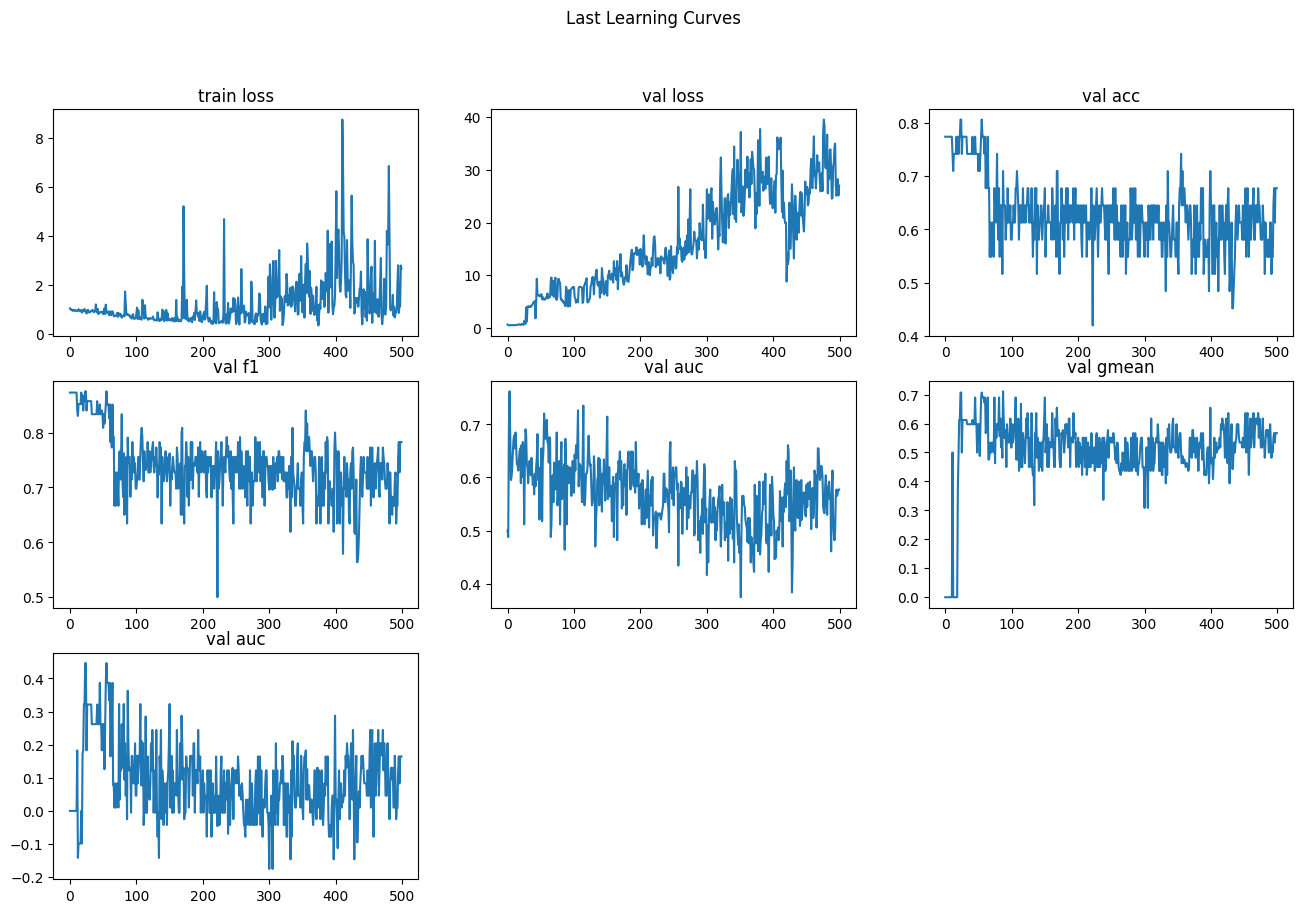

In [62]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [63]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: SetCoAttnTransformer_ft
val acc mean:  0.735483870967742
val f1 mean:  0.8428165297819017
val auc mean:  0.6348755116721869
val gmean mean:  0.0
val mcc mean:  0.0


model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619